In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

In [3]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
excel_file_path = r"C:\Users\achra\Downloads\Workbook.xlsx"
dfs_dict = pd.read_excel(excel_file_path, sheet_name=None)
orders = dfs_dict['Half Year Orders']
cafe_reviews = dfs_dict['Primary Cafe Reviews']
competitor_reviews = dfs_dict['Comp-A Cafe Review']

In [4]:
orders.head()

item id                  name  \
0  bda74f81-57b3-45f1-a849-d9c28aeae578                 Latte   
1  a3ad5245-9713-413a-b0e2-a30a4b7a08ff          Spicy Turkey   
2  f3f72673-09b4-4ac1-951b-1ac6ed1a0d79          Matcha Latte   
3  e366193e-b6fa-4dcd-a570-bef843003c96  Roasted Veggie Salad   
4  ddf5a1ad-e817-4eac-918c-62622da575b2        Grilled Cheese   

                               order id      order time (utc)  quantity  \
0  ba1b3725-8135-492d-86ec-8bcbb8d5a030  2023-09-29T16:26:06Z         2   
1  ba1b3725-8135-492d-86ec-8bcbb8d5a030  2023-09-29T16:26:06Z         1   
2  4dba82c1-ba62-434f-9659-b6171769ed8b  2023-09-29T16:24:57Z         1   
3  9cd8b191-208a-4bd3-bae7-492f9dab8ce5  2023-09-29T16:23:43Z         1   
4  9cd8b191-208a-4bd3-bae7-492f9dab8ce5  2023-09-29T16:23:43Z         1   

   total price  total Price in dollars  
0          900                     9.0  
1         1300                    13.0  
2          600                     6.0  
3         1450                    14.5  
4         1050                    10.5

In [5]:
cafe_reviews.head()

Review Score                                     Review Comment
0             5  A little cafe on a side street in NYC close to...
1             3  The food: 3/5 I came here because someone on Y...
2             3  Sip and Co is a cute shop where you can fulfil...
3             5  We wanted a quick breakfast, close to our Hote...
4             5  Sip and Co was a great stop for a light breakf...

In [6]:
competitor_reviews.head()

Review Score                                     Review Comment
0             5  Just perfect. Went each of the three mornings ...
1             4  I like this place! It makes me feel like at ho...
2             4  Wow! What a cute French coffee shop. The place...
3             5  I've had cappuccinos all over the world, and Z...
4             5  Love this little pocket of authentic Italian c...

# Data Cleaning

In [7]:
orders.isna().sum()
cafe_reviews.isna().sum()
competitor_reviews.isna().sum()

Review Score      0
Review Comment    0
dtype: int64

In [8]:
orders['order time (utc)'] = pd.to_datetime(orders['order time (utc)'])
orders['Year'] = orders['order time (utc)'].dt.year
orders['Month'] = orders['order time (utc)'].dt.month
orders['Day'] = orders['order time (utc)'].dt.day
orders['Hour'] = orders['order time (utc)'].dt.hour
orders['Minute'] = orders['order time (utc)'].dt.minute
orders['Second'] = orders['order time (utc)'].dt.second
orders = orders.sort_values(by = 'order time (utc)', ascending = True)
orders.head()

item id             name  \
139505  71ca8f5d-cdca-4727-855e-855ea48bb0d6      Drip Coffee   
139502  ef391fdf-98eb-428d-8b9f-cff21cfb2357            Bagel   
139504  c33e4639-2f07-4553-8f40-c78f7d67168f        Croissant   
139503  af7b5f63-ebda-4698-b5a8-41a25c45765c  Choc. Croissant   
139496  a5151d8c-5f01-42cc-8cfc-d1364b698632          Cortado   

                                    order id          order time (utc)  \
139505  b8fa367e-d978-42b6-aae7-7130d01a55fb 2023-04-08 12:33:25+00:00   
139502  b8fa367e-d978-42b6-aae7-7130d01a55fb 2023-04-08 12:33:25+00:00   
139504  b8fa367e-d978-42b6-aae7-7130d01a55fb 2023-04-08 12:33:25+00:00   
139503  b8fa367e-d978-42b6-aae7-7130d01a55fb 2023-04-08 12:33:25+00:00   
139496  c2e7350a-14db-4f49-9b17-750516d996f7 2023-04-08 12:36:05+00:00   

        quantity  total price  total Price in dollars  Year  Month  Day  Hour  \
139505         2          800                    8.00  2023      4    8    12   
139502         1          425                    4.25  2023      4    8    12   
139504         1          400                    4.00  2023      4    8    12   
139503         1          435                    4.35  2023      4    8    12   
139496         1          400                    4.00  2023      4    8    12   

        Minute  Second  
139505      33      25  
139502      33      25  
139504      33      25  
139503      33      25  
139496      36       5

# Exploratory Data Analysis of Half Year Order Data

Text(0, 0.5, 'Total Sales ($)')

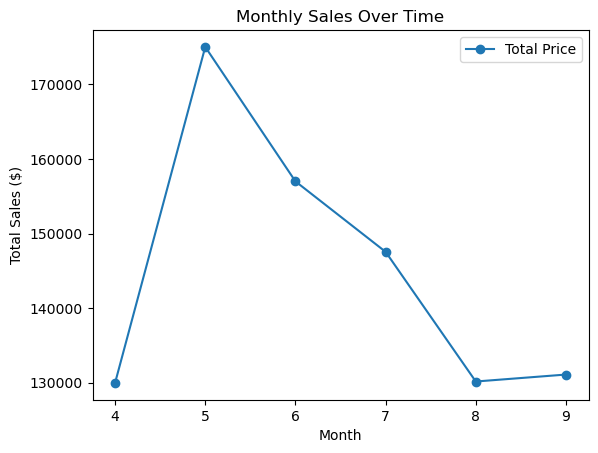

In [9]:
orders = orders.drop(labels = ['total price'], axis = 1)
orders = orders.rename({'total Price in dollars': 'Total Price'}, axis = 1)
orders.head()
monthly_sales = orders.groupby('Month').agg({'Total Price':'sum'})
monthly_sales.plot(kind='line', marker='o', color='tab:blue')
plt.title('Monthly Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')

In [10]:
orders['name'] = orders['name'].str.strip()
orders['name'].value_counts(ascending = True).head(75)
orders.head()

item id             name  \
139505  71ca8f5d-cdca-4727-855e-855ea48bb0d6      Drip Coffee   
139502  ef391fdf-98eb-428d-8b9f-cff21cfb2357            Bagel   
139504  c33e4639-2f07-4553-8f40-c78f7d67168f        Croissant   
139503  af7b5f63-ebda-4698-b5a8-41a25c45765c  Choc. Croissant   
139496  a5151d8c-5f01-42cc-8cfc-d1364b698632          Cortado   

                                    order id          order time (utc)  \
139505  b8fa367e-d978-42b6-aae7-7130d01a55fb 2023-04-08 12:33:25+00:00   
139502  b8fa367e-d978-42b6-aae7-7130d01a55fb 2023-04-08 12:33:25+00:00   
139504  b8fa367e-d978-42b6-aae7-7130d01a55fb 2023-04-08 12:33:25+00:00   
139503  b8fa367e-d978-42b6-aae7-7130d01a55fb 2023-04-08 12:33:25+00:00   
139496  c2e7350a-14db-4f49-9b17-750516d996f7 2023-04-08 12:36:05+00:00   

        quantity  Total Price  Year  Month  Day  Hour  Minute  Second  
139505         2         8.00  2023      4    8    12      33      25  
139502         1         4.25  2023      4    8    12      33      25  
139504         1         4.00  2023      4    8    12      33      25  
139503         1         4.35  2023      4    8    12      33      25  
139496         1         4.00  2023      4    8    12      36       5

In [11]:
orders['name'].unique()

array(['Drip Coffee', 'Bagel', 'Croissant', 'Choc. Croissant', 'Cortado',
       'Cappuccino', 'Egg and Cheese', 'Cranberry Scone',
       'Breakfast Burrito', 'Cinnamon Bun', 'Latte', 'Espresso', 'Muffin',
       'Everything Croissant', 'Chai Latte', 'Yogurt Parfait', 'Hot Tea',
       'Apple Juice', 'Still Water', 'Cookies', 'Loaf Breads', 'Macaron',
       'Grilled Cheese', 'Almond Croissant', 'Matcha Latte', 'Americano',
       'Eclair', 'Orange Juice', 'Caesar Wrap', 'Cold Brew', 'Flat White',
       'Spindrift', 'Iced Americano', 'Toast', 'Pecan Sticky Bun',
       'Avocado Toast', 'Custom Order', 'Danish', 'Hot Chocolate',
       'Specialty Croissants', 'Salmon Lox', 'Sip and Co MUG', 'Bahn Mi',
       'Soup of the day', 'Steamer', 'Banana', 'Choc. Brownie',
       'Brownie Bites', 'Macchiato', 'Latte (12 Oz)', 'Kouign Amann',
       'Sparkling Water', 'Iced Tea', 'Other Half - DDH Green City',
       'Tahini Choc Chip Cookie (V/GF)', 'Raaka Bars', 'Madeleine',
       'Ham and C

In [12]:
categories = {
    'Pastries': ['Macaron', 'Croissant', 'Scone', 'Bun', 'Muffin', 'Danish', 'Loaf', 'Bread', 'Bagel', 'Toast', 'Eclair', 'Brownie', 'Cookie', 'Tart', 'Pudding', 'Donut', 'Madeleine', 'Waffles'],
    'Hot Drinks': ['Coffee', 'Latte', 'Espresso', 'Tea', 'Cappuccino', 'Hot Chocolate', 'Americano', 'Chai', 'Cortado', 'Macchiato', 'Fog', 'Mocha'],
    'Cold Drinks': ['Iced', 'Cold Brew', 'Juice', 'Water', 'Lemonade', 'Arnold Palmer', 'Kombucha', 'Matcha', 'Cold'],
    'Snacks': ['Chips', 'Bar', 'Brownie', 'Cookie', 'Granola', 'Pretzel', 'Banana'],
    'Breakfast Foods': ['Egg', 'Breakfast Burrito', 'Avocado Toast', 'Yogurt Parfait', 'Baguette'],
    'Lunch Meals': ['Wrap', 'Bahn', 'Grilled', 'Salad', 'sandwiches', 'Soup', 'Melt', 'Spicy', 'Club', 'Salmon', 'Lox']
  
}

# Function to categorize menu item
def categorize_item(item, categories):
    for category, keywords in categories.items():
        if any(keyword.lower() in item.lower() for keyword in keywords):
            return category
    return 'Other'

product_categories = {}



orders['product_category'] = orders['name'].apply(lambda item: categorize_item(item, categories))

In [13]:
other_category_items = orders[orders['product_category'] == 'Other']['name']
other_category_items.unique()

array(['Flat White', 'Spindrift', 'Custom Order', 'Sip and Co MUG',
       'Kouign Amann', 'Other Half - DDH Green City', 'Raaka Cones',
       'Gift Cards', 'Honey', 'Cc', 'Other Half - Forever Ever',
       'Cream cheese', 'Gronla', 'Ice chocolate', 'Extra 2', 'Jam',
       'Espn', 'Ollipop', 'Milk', 'Olipop', 'Large', 'Vanilla',
       'Chocolate', 'Butter', 'Beans', 'DOH IS HERE!!!', 'Van in fw',
       'Extra shot in almond', 'Babychino', 'Medium', 'Chia', 'Ham',
       'Bean', 'Bacon side', 'Custom', '700g', 'Sip Co Tote',
       'Lamingtons', '700g bean', '5 ice', 'Xtra van', 'Van',
       'Drink difference', 'Sausage on side', 'Extra shot', '750g',
       'Extra', 'Tomato', 'Oval Drip Bag Box', 'Apple Cider'],
      dtype=object)

(array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 [Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8'),
  Text(9.0, 0, '9'),
  Text(10.0, 0, '10')])

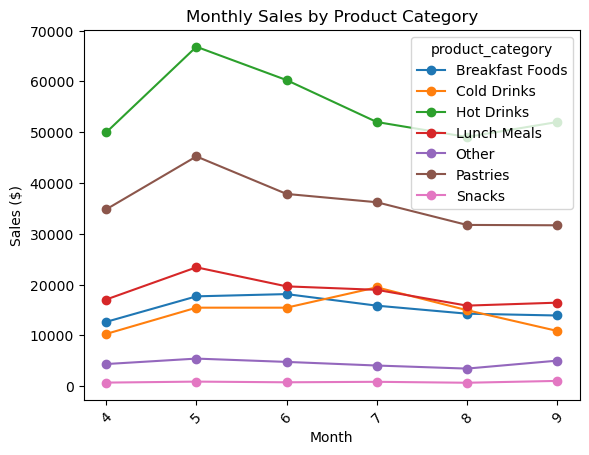

In [14]:
pivot_df = orders.pivot_table(values='Total Price', index='Month', columns='product_category', aggfunc='sum')

pivot_df.plot(kind='line', marker='o')
plt.title('Monthly Sales by Product Category')
plt.xlabel('Month')
plt.ylabel('Sales ($)')
plt.xticks(rotation=45)

In [15]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_pred)) * 100

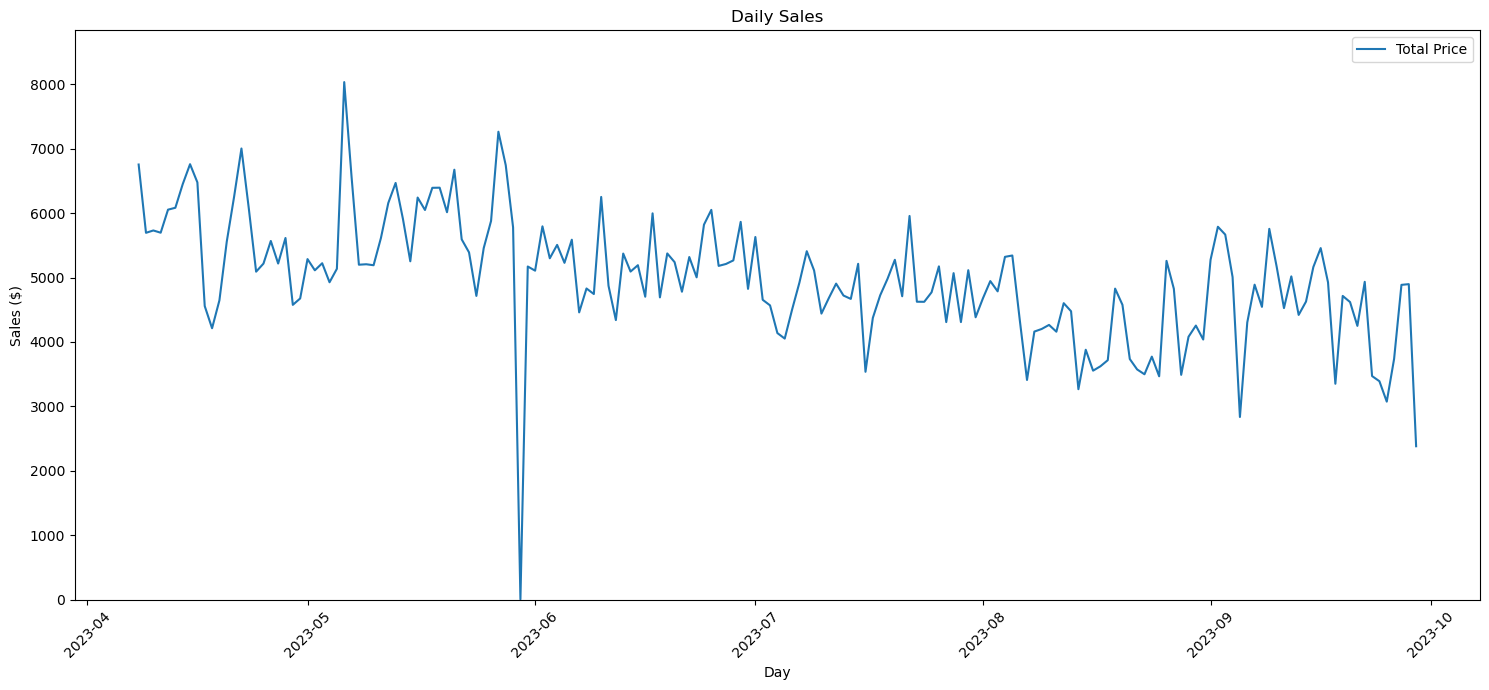

In [16]:
daily_sales = orders.groupby(orders['order time (utc)'].dt.date).agg({'Total Price': 'sum'}).reset_index()

daily_sales.set_index('order time (utc)', inplace=True)

daily_sales.plot(kind='line', figsize=(15,7))
plt.title('Daily Sales')
plt.xlabel('Day')
plt.ylabel('Sales ($)')
plt.ylim(0, daily_sales['Total Price'].max() + (0.1 * daily_sales['Total Price'].max())) # A bit higher than the max value
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the x-labels
plt.show()

<IntegerArray>
[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
 33, 34, 35, 36, 37, 38, 39]
Length: 26, dtype: UInt32

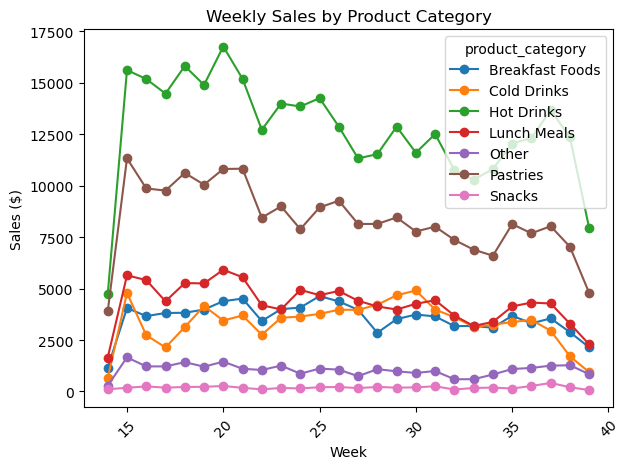

In [17]:
orders['week_of_year'] = orders['order time (utc)'].dt.isocalendar().week
pivot_df3 = orders.pivot_table(values='Total Price', index='week_of_year', columns='product_category', aggfunc='sum')

pivot_df3.plot(kind='line', marker='o')
plt.title('Weekly Sales by Product Category')
plt.xlabel('Week')
plt.ylabel('Sales ($)')
plt.xticks(rotation=45)

plt.tight_layout()
orders['week_of_year'].unique()

item id             name  \
139505  71ca8f5d-cdca-4727-855e-855ea48bb0d6      Drip Coffee   
139502  ef391fdf-98eb-428d-8b9f-cff21cfb2357            Bagel   
139504  c33e4639-2f07-4553-8f40-c78f7d67168f        Croissant   
139503  af7b5f63-ebda-4698-b5a8-41a25c45765c  Choc. Croissant   
139496  a5151d8c-5f01-42cc-8cfc-d1364b698632          Cortado   

                                    order id          order time (utc)  \
139505  b8fa367e-d978-42b6-aae7-7130d01a55fb 2023-04-08 12:33:25+00:00   
139502  b8fa367e-d978-42b6-aae7-7130d01a55fb 2023-04-08 12:33:25+00:00   
139504  b8fa367e-d978-42b6-aae7-7130d01a55fb 2023-04-08 12:33:25+00:00   
139503  b8fa367e-d978-42b6-aae7-7130d01a55fb 2023-04-08 12:33:25+00:00   
139496  c2e7350a-14db-4f49-9b17-750516d996f7 2023-04-08 12:36:05+00:00   

        quantity  Total Price  Year  Month  Day  Hour  Minute  Second  \
139505         2         8.00  2023      4    8    12      33      25   
139502         1         4.25  2023      4    8    12      33      25   
139504         1         4.00  2023      4    8    12      33      25   
139503         1         4.35  2023      4    8    12      33      25   
139496         1         4.00  2023      4    8    12      36       5   

       product_category  week_of_year  
139505       Hot Drinks            14  
139502         Pastries            14  
139504         Pastries            14  
139503         Pastries            14  
139496       Hot Drinks            14

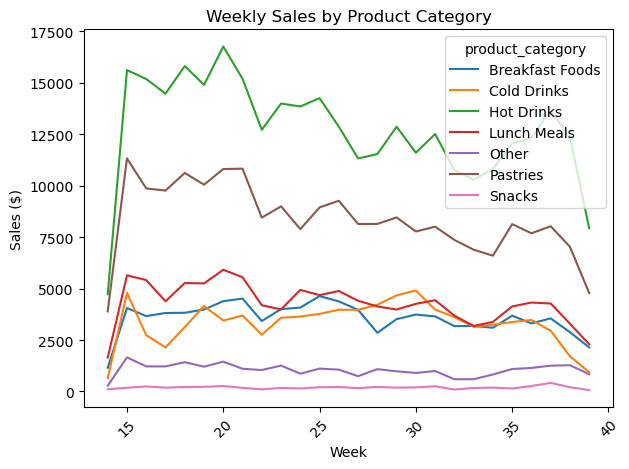

In [18]:
orders['week_of_year'] = orders['order time (utc)'].dt.isocalendar().week
pivot_df4 = orders.pivot_table(values='Total Price', index='week_of_year', columns='product_category', aggfunc='sum')

pivot_df4.plot(kind='line')
plt.title('Weekly Sales by Product Category')
plt.xlabel('Week')
plt.ylabel('Sales ($)')
plt.xticks(rotation=45)

plt.tight_layout()
orders['week_of_year'].unique()
orders.head()

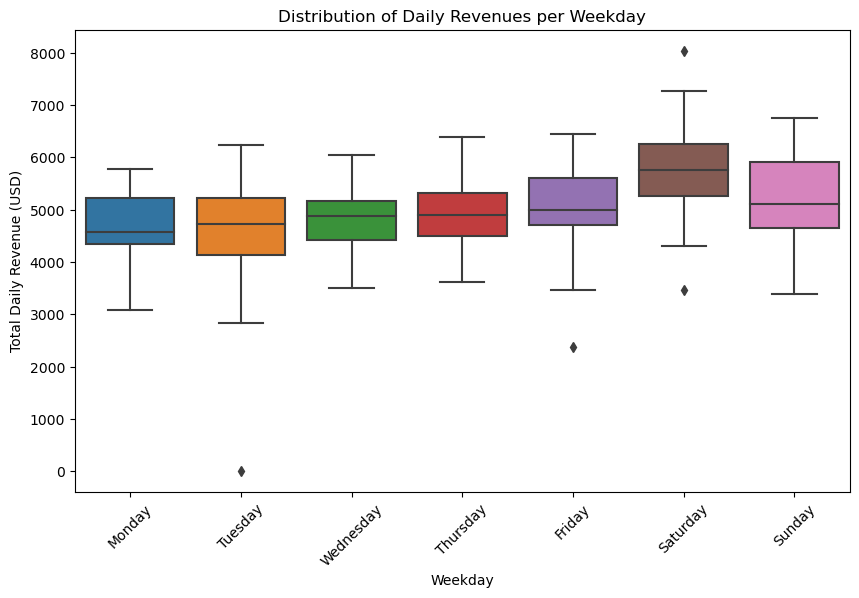

In [19]:
orders['weekday'] = orders['order time (utc)'].dt.day_name()

weekly_revenue = orders.groupby('weekday')['Total Price'].sum().reset_index()

daily_revenues = (
    orders.groupby([orders['order time (utc)'].dt.date, 'weekday'])['Total Price']
    .sum()
    .reset_index(name='Daily Revenue')
)


plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='weekday', y='Daily Revenue', data=daily_revenues,
                 order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title('Distribution of Daily Revenues per Weekday')
plt.xlabel('Weekday')
plt.ylabel('Total Daily Revenue (USD)')
plt.xticks(rotation=45)  
plt.show()

Text(0, 0.5, 'Sales ($)')

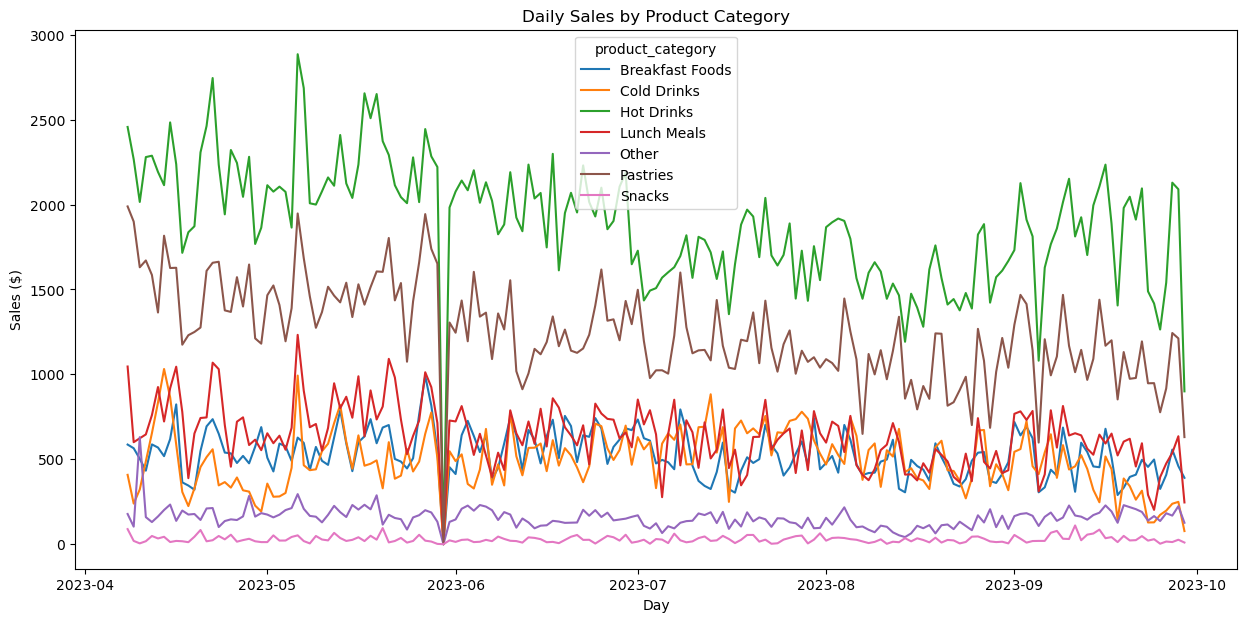

In [20]:
orders['order time (utc)'] = pd.to_datetime(orders['order time (utc)'])

orders_daily = orders.set_index('order time (utc)')

pivot_df2 = orders_daily.pivot_table(values='Total Price', index=orders_daily.index.date, aggfunc='sum', columns='product_category', fill_value=0)

pivot_df2.plot(kind='line', figsize=(15,7))
plt.title('Daily Sales by Product Category')
plt.xlabel('Day')
plt.ylabel('Sales ($)')

# Time Series Forecasting Data Preprocessing for each product category

In [52]:
#Creating dataframes for each product category daily sales
orders['Order Date'] = orders['order time (utc)'].dt.date
filtered_orders = orders[['product_category', 'Order Date', 'Total Price']]
category_dfs = {}
for category in filtered_orders['product_category'].unique():
    category_df = filtered_orders[filtered_orders['product_category'] == category]
    category_data = category_df.groupby('Order Date')['Total Price'].sum().reset_index()
    category_dfs[category] = category_data

print(category_dfs.keys())
print(category_dfs['Hot Drinks'].head())
print(category_dfs['Cold Drinks'].info())

dict_keys(['Hot Drinks', 'Pastries', 'Breakfast Foods', 'Cold Drinks', 'Lunch Meals', 'Other', 'Snacks'])
   Order Date  Total Price
0  2023-04-08      2456.75
1  2023-04-09      2266.50
2  2023-04-10      2015.25
3  2023-04-11      2279.35
4  2023-04-12      2287.53
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Order Date   174 non-null    object 
 1   Total Price  174 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.8+ KB
None


In [54]:
#Removing outliers from each product category dataframe
prediction_df_list = []
for category in category_dfs.keys():
    df_new = category_dfs[category]
    z = np.abs(stats.zscore(df_new['Total Price']))
    outlier_index = np.where(z > 2.5)[0]
    print('Dropping '+ str(len(outlier_index)) + ' rows for ' + category)
    df_new.drop(index = outlier_index, inplace = True)
    df_new.set_index('Order Date', inplace = True)
    prediction_df_list.append(df_new)

Dropping 2 rows for Hot Drinks
Dropping 2 rows for Pastries
Dropping 1 rows for Breakfast Foods
Dropping 2 rows for Cold Drinks
Dropping 2 rows for Lunch Meals
Dropping 1 rows for Other
Dropping 6 rows for Snacks


In [56]:
for df in prediction_df_list:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 169 entries, 2023-04-08 to 2023-09-28
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total Price  169 non-null    float64
dtypes: float64(1)
memory usage: 2.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 173 entries, 2023-04-09 to 2023-09-29
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total Price  173 non-null    float64
dtypes: float64(1)
memory usage: 2.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 173 entries, 2023-04-08 to 2023-09-29
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total Price  173 non-null    float64
dtypes: float64(1)
memory usage: 2.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, 2023-04-08 to 2023-09-29
Data columns (total 1 columns):
 #   Column       Non-Nu

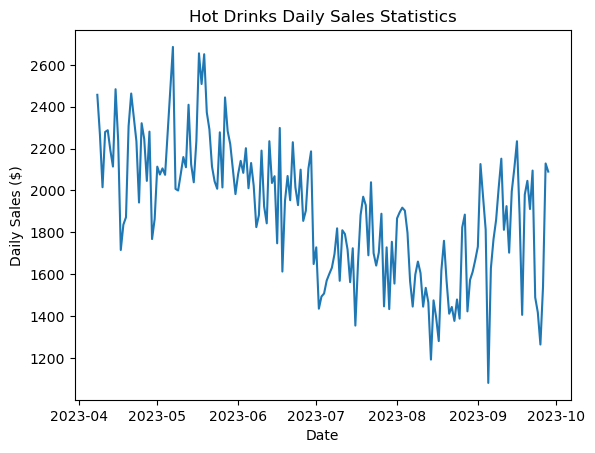

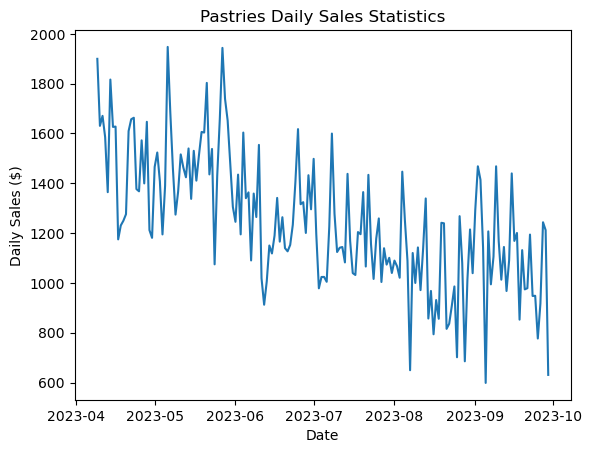

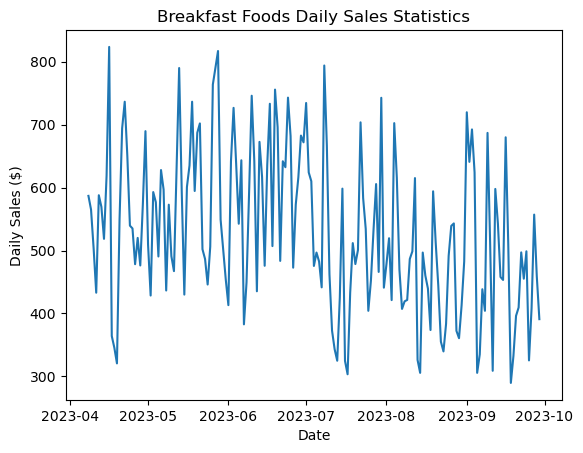

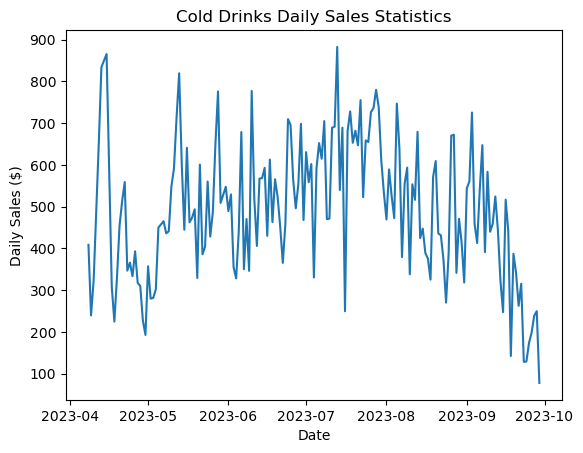

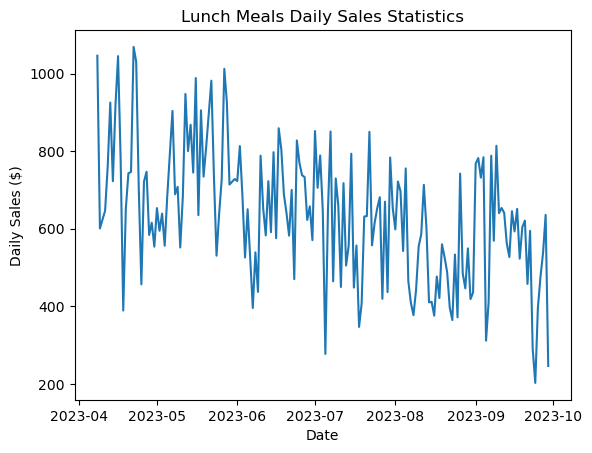

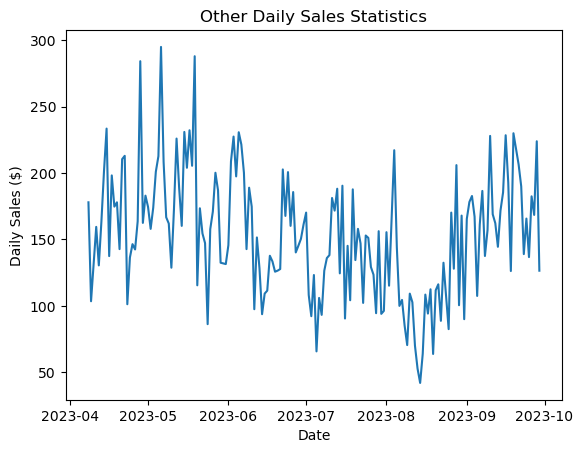

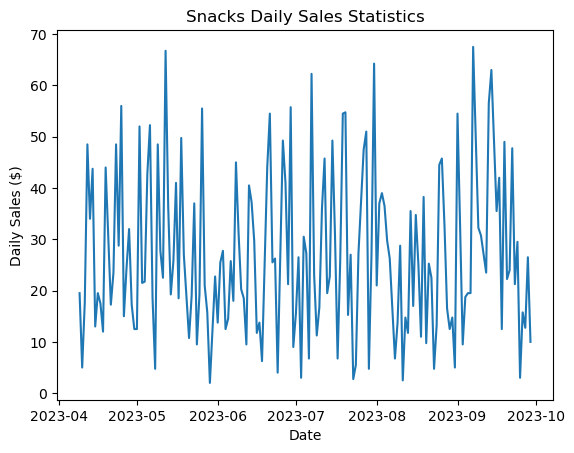

In [55]:
#Time Series Plotting/Inspection
for i in range(len(prediction_df_list)):
    plt.plot(prediction_df_list[i])
    plt.title(orders['product_category'].unique()[i] + ' Daily Sales Statistics')
    plt.xlabel('Date')
    plt.ylabel('Daily Sales ($)')
    plt.show()

# Hyperparamter Tuning Pipeline

In [71]:
import itertools
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num = 5).tolist()
seasonality_prior_scale_range = np.linspace(0.01, 0.5, num =5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num =5).tolist()
index = 0
dicts = {}
for df in prediction_df_list:
    feature = orders['product_category'].unique()[index]
    cat_df = df.reset_index()
    cat_df = cat_df.rename(mapper = {'Order Date':'ds', 'Total Price':'y'}, axis = 1)
    cat_df['y'] = cat_df[['y']].apply(pd.to_numeric)
    cat_df['ds'] = pd.to_datetime(cat_df['ds'])
    param_grid = {
        'changepoint_prior_scale':changepoint_prior_scale_range,
        'seasonality_prior_scale':seasonality_prior_scale_range
    }
    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(),v)) for v in itertools.product(*param_grid.values())]
    mapes = []
    # Cross Validation
    for params in all_params:
        m = Prophet(**params).fit(cat_df)
        df_cv = cross_validation(m, initial = '105 days', period = '10 days', horizon = '15 days')
        df_p = performance_metrics(df_cv, rolling_window = 1)
        print(df_p)
        mapes.append(df_p['mape'].values[0])
    # Finding Optimal Parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['mape'] = mapes
    print(feature)
    print(tuning_results.head())
    params_dict = dict(tuning_results.sort_values('mape').reset_index(drop = True).iloc[0])
    params_dict['column'] = feature
    dicts[feature] = params_dict
    index = index + 1

19:15:12 - cmdstanpy - INFO - Chain [1] start processing
19:15:12 - cmdstanpy - INFO - Chain [1] done processing
19:15:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:15:12 - cmdstanpy - INFO - Chain [1] start processing
19:15:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:15:13 - cmdstanpy - INFO - Chain [1] start processing
19:15:13 - cmdstanpy - INFO - Chain [1] done processing
19:15:14 - cmdstanpy - INFO - Chain [1] start processing
19:15:14 - cmdstanpy - INFO - Chain [1] done processing
19:15:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:15:14 - cmdstanpy - INFO - Chain [1] start processing
19:15:14 - cmdstanpy - INFO - Chain [1] done processing
19:15:14 - cmdstanpy - INFO - Chain [1] start processing
19:15:14 - cmdstanpy - INFO - Chain [1] done processing
19:15:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:15:14 - cmdstanpy - INFO - Chain [1] start processing
19:15:15 - cmdstanpy - INFO - Chain [1] done processing
19:15:15 - cmdstanpy - INFO - Chain [1] start processing
19:15:15 - cmdstanpy - INFO - Chain [1] done processing
19:15:15 -

  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  121719.46923  348.883174  287.609495  0.163421  0.150837  0.176701   

   coverage  
0  0.539326  


19:15:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:15:17 - cmdstanpy - INFO - Chain [1] start processing
19:15:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:15:18 - cmdstanpy - INFO - Chain [1] start processing
19:15:18 - cmdstanpy - INFO - Chain [1] done processing
19:15:18 - cmdstanpy - INFO - Chain [1] start processing
19:15:18 - cmdstanpy - INFO - Chain [1] done processing
19:15:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:15:18 - cmdstanpy - INFO - Chain [1] start processing
19:15:18 - cmdstanpy - INFO - Chain [1] done processing
19:15:18 - cmdstanpy - INFO - Chain [1] start processing
19:15:18 - cmdstanpy - INFO - Chain [1] done processing
19:15:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:15:18 - cmdstanpy - INFO - Chain [1] start processing
19:15:19 - cmdstanpy - INFO - Chain [1] done processing
19:15:19 - cmdstanpy - INFO - Chain [1] start processing
19:15:19 - cmdstanpy - INFO - Chain [1] done processing
19:15:19 -

  horizon            mse        rmse         mae      mape     mdape  \
0 15 days  121700.186234  348.855538  287.488052  0.163435  0.153595   

      smape  coverage  
0  0.176897  0.561798  


19:15:21 - cmdstanpy - INFO - Chain [1] done processing
19:15:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:15:22 - cmdstanpy - INFO - Chain [1] start processing
19:15:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:15:23 - cmdstanpy - INFO - Chain [1] start processing
19:15:23 - cmdstanpy - INFO - Chain [1] done processing
19:15:23 - cmdstanpy - INFO - Chain [1] start processing
19:15:23 - cmdstanpy - INFO - Chain [1] done processing
19:15:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:15:23 - cmdstanpy - INFO - Chain [1] start processing
19:15:24 - cmdstanpy - INFO - Chain [1] done processing
19:15:24 - cmdstanpy - INFO - Chain [1] start processing
19:15:24 - cmdstanpy - INFO - Chain [1] done processing
19:15:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:15:24 - cmdstanpy - INFO - Chain [1] start processing
19:15:24 - cmdstanpy - INFO - Chain [1] done processing
19:15:24 - cmdstanpy - INFO - Chain [1] start processing
19:15:25 - cmdstanpy - INFO - Chain [1] done processing
19:15:25 -

  horizon            mse        rmse         mae      mape    mdape     smape  \
0 15 days  121249.874108  348.209526  288.158224  0.164063  0.15296  0.177312   

   coverage  
0  0.539326  


19:15:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:15:26 - cmdstanpy - INFO - Chain [1] start processing
19:15:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:15:27 - cmdstanpy - INFO - Chain [1] start processing
19:15:27 - cmdstanpy - INFO - Chain [1] done processing
19:15:27 - cmdstanpy - INFO - Chain [1] start processing
19:15:27 - cmdstanpy - INFO - Chain [1] done processing
19:15:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:15:27 - cmdstanpy - INFO - Chain [1] start processing
19:15:27 - cmdstanpy - INFO - Chain [1] done processing
19:15:28 - cmdstanpy - INFO - Chain [1] start processing
19:15:28 - cmdstanpy - INFO - Chain [1] done processing
19:15:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:15:28 - cmdstanpy - INFO - Chain [1] start processing
19:15:28 - cmdstanpy - INFO - Chain [1] done processing
19:15:28 - cmdstanpy - INFO - Chain [1] start processing
19:15:28 - cmdstanpy - INFO - Chain [1] done processing
19:15:29 -

  horizon            mse        rmse         mae      mape    mdape     smape  \
0 15 days  120024.606406  346.445676  285.458876  0.162219  0.15277  0.175626   

   coverage  
0  0.550562  


19:15:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:15:30 - cmdstanpy - INFO - Chain [1] start processing
19:15:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:15:31 - cmdstanpy - INFO - Chain [1] start processing
19:15:31 - cmdstanpy - INFO - Chain [1] done processing
19:15:31 - cmdstanpy - INFO - Chain [1] start processing
19:15:31 - cmdstanpy - INFO - Chain [1] done processing
19:15:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:15:31 - cmdstanpy - INFO - Chain [1] start processing
19:15:31 - cmdstanpy - INFO - Chain [1] done processing
19:15:32 - cmdstanpy - INFO - Chain [1] start processing
19:15:32 - cmdstanpy - INFO - Chain [1] done processing
19:15:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:15:32 - cmdstanpy - INFO - Chain [1] start processing
19:15:32 - cmdstanpy - INFO - Chain [1] done processing
19:15:32 - cmdstanpy - INFO - Chain [1] start processing
19:15:32 - cmdstanpy - INFO - Chain [1] done processing
19:15:33 -

  horizon            mse        rmse         mae      mape     mdape  \
0 15 days  121672.408195  348.815722  287.408935  0.163287  0.152785   

      smape  coverage  
0  0.176907  0.550562  


19:15:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:15:34 - cmdstanpy - INFO - Chain [1] start processing
19:15:34 - cmdstanpy - INFO - Chain [1] done processing
19:15:35 - cmdstanpy - INFO - Chain [1] start processing
19:15:35 - cmdstanpy - INFO - Chain [1] done processing
19:15:35 - cmdstanpy - INFO - Chain [1] start processing
19:15:35 - cmdstanpy - INFO - Chain [1] done processing
19:15:35 - cmdstanpy - INFO - Chain [1] start processing
19:15:35 - cmdstanpy - INFO - Chain [1] done processing
19:15:35 - cmdstanpy - INFO - Chain [1] start processing
19:15:35 - cmdstanpy - INFO - Chain [1] done processing
19:15:36 - cmdstanpy - INFO - Chain [1] start processing
19:15:36 - cmdstanpy - INFO - Chain [1] done processing
19:15:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 15 days  90019.279148  300.03213  249.999542  0.145792  0.141611  0.151957   

   coverage  
0  0.505618  


19:15:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:15:37 - cmdstanpy - INFO - Chain [1] start processing
19:15:37 - cmdstanpy - INFO - Chain [1] done processing
19:15:37 - cmdstanpy - INFO - Chain [1] start processing
19:15:37 - cmdstanpy - INFO - Chain [1] done processing
19:15:37 - cmdstanpy - INFO - Chain [1] start processing
19:15:37 - cmdstanpy - INFO - Chain [1] done processing
19:15:37 - cmdstanpy - INFO - Chain [1] start processing
19:15:37 - cmdstanpy - INFO - Chain [1] done processing
19:15:38 - cmdstanpy - INFO - Chain [1] start processing
19:15:38 - cmdstanpy - INFO - Chain [1] done processing
19:15:38 - cmdstanpy - INFO - Chain [1] start processing
19:15:38 - cmdstanpy - INFO - Chain [1] done processing
19:15:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  89394.364531  298.988904  252.462872  0.147851  0.137514  0.153944   

   coverage  
0   0.52809  


19:15:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:15:39 - cmdstanpy - INFO - Chain [1] start processing
19:15:39 - cmdstanpy - INFO - Chain [1] done processing
19:15:39 - cmdstanpy - INFO - Chain [1] start processing
19:15:39 - cmdstanpy - INFO - Chain [1] done processing
19:15:39 - cmdstanpy - INFO - Chain [1] start processing
19:15:39 - cmdstanpy - INFO - Chain [1] done processing
19:15:40 - cmdstanpy - INFO - Chain [1] start processing
19:15:40 - cmdstanpy - INFO - Chain [1] done processing
19:15:40 - cmdstanpy - INFO - Chain [1] start processing
19:15:40 - cmdstanpy - INFO - Chain [1] done processing
19:15:40 - cmdstanpy - INFO - Chain [1] start processing
19:15:40 - cmdstanpy - INFO - Chain [1] done processing
19:15:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  88873.666225  298.116867  250.933875  0.146858  0.137589  0.152986   

   coverage  
0  0.516854  


19:15:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:15:41 - cmdstanpy - INFO - Chain [1] start processing
19:15:41 - cmdstanpy - INFO - Chain [1] done processing
19:15:41 - cmdstanpy - INFO - Chain [1] start processing
19:15:41 - cmdstanpy - INFO - Chain [1] done processing
19:15:42 - cmdstanpy - INFO - Chain [1] start processing
19:15:42 - cmdstanpy - INFO - Chain [1] done processing
19:15:42 - cmdstanpy - INFO - Chain [1] start processing
19:15:42 - cmdstanpy - INFO - Chain [1] done processing
19:15:42 - cmdstanpy - INFO - Chain [1] start processing
19:15:42 - cmdstanpy - INFO - Chain [1] done processing
19:15:42 - cmdstanpy - INFO - Chain [1] start processing
19:15:43 - cmdstanpy - INFO - Chain [1] done processing
19:15:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 15 days  88510.842388  297.507718  250.948494  0.147165  0.13881  0.152924   

   coverage  
0   0.52809  


19:15:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:15:43 - cmdstanpy - INFO - Chain [1] start processing
19:15:43 - cmdstanpy - INFO - Chain [1] done processing
19:15:44 - cmdstanpy - INFO - Chain [1] start processing
19:15:44 - cmdstanpy - INFO - Chain [1] done processing
19:15:44 - cmdstanpy - INFO - Chain [1] start processing
19:15:44 - cmdstanpy - INFO - Chain [1] done processing
19:15:44 - cmdstanpy - INFO - Chain [1] start processing
19:15:44 - cmdstanpy - INFO - Chain [1] done processing
19:15:44 - cmdstanpy - INFO - Chain [1] start processing
19:15:44 - cmdstanpy - INFO - Chain [1] done processing
19:15:45 - cmdstanpy - INFO - Chain [1] start processing
19:15:45 - cmdstanpy - INFO - Chain [1] done processing
19:15:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae     mape    mdape     smape  \
0 15 days  89814.923064  299.69138  252.692269  0.14801  0.13778  0.154127   

   coverage  
0   0.52809  


19:15:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:15:45 - cmdstanpy - INFO - Chain [1] start processing
19:15:46 - cmdstanpy - INFO - Chain [1] done processing
19:15:46 - cmdstanpy - INFO - Chain [1] start processing
19:15:46 - cmdstanpy - INFO - Chain [1] done processing
19:15:46 - cmdstanpy - INFO - Chain [1] start processing
19:15:46 - cmdstanpy - INFO - Chain [1] done processing
19:15:46 - cmdstanpy - INFO - Chain [1] start processing
19:15:47 - cmdstanpy - INFO - Chain [1] done processing
19:15:47 - cmdstanpy - INFO - Chain [1] start processing
19:15:47 - cmdstanpy - INFO - Chain [1] done processing
19:15:47 - cmdstanpy - INFO - Chain [1] start processing
19:15:47 - cmdstanpy - INFO - Chain [1] done processing
19:15:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse         mae     mape     mdape    smape  \
0 15 days  86951.90284  294.87608  246.506627  0.14734  0.131316  0.14921   

   coverage  
0  0.539326  


19:15:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:15:48 - cmdstanpy - INFO - Chain [1] start processing
19:15:48 - cmdstanpy - INFO - Chain [1] done processing
19:15:48 - cmdstanpy - INFO - Chain [1] start processing
19:15:48 - cmdstanpy - INFO - Chain [1] done processing
19:15:48 - cmdstanpy - INFO - Chain [1] start processing
19:15:49 - cmdstanpy - INFO - Chain [1] done processing
19:15:49 - cmdstanpy - INFO - Chain [1] start processing
19:15:49 - cmdstanpy - INFO - Chain [1] done processing
19:15:49 - cmdstanpy - INFO - Chain [1] start processing
19:15:49 - cmdstanpy - INFO - Chain [1] done processing
19:15:49 - cmdstanpy - INFO - Chain [1] start processing
19:15:49 - cmdstanpy - INFO - Chain [1] done processing
19:15:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  85382.145084  292.202233  244.062061  0.146556  0.122813  0.148022   

   coverage  
0  0.550562  


19:15:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:15:50 - cmdstanpy - INFO - Chain [1] start processing
19:15:50 - cmdstanpy - INFO - Chain [1] done processing
19:15:50 - cmdstanpy - INFO - Chain [1] start processing
19:15:51 - cmdstanpy - INFO - Chain [1] done processing
19:15:51 - cmdstanpy - INFO - Chain [1] start processing
19:15:51 - cmdstanpy - INFO - Chain [1] done processing
19:15:51 - cmdstanpy - INFO - Chain [1] start processing
19:15:51 - cmdstanpy - INFO - Chain [1] done processing
19:15:51 - cmdstanpy - INFO - Chain [1] start processing
19:15:51 - cmdstanpy - INFO - Chain [1] done processing
19:15:52 - cmdstanpy - INFO - Chain [1] start processing
19:15:52 - cmdstanpy - INFO - Chain [1] done processing
19:15:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 15 days  85123.424706  291.75919  243.472145  0.146359  0.122966  0.147662   

   coverage  
0  0.561798  


19:15:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:15:52 - cmdstanpy - INFO - Chain [1] start processing
19:15:53 - cmdstanpy - INFO - Chain [1] done processing
19:15:53 - cmdstanpy - INFO - Chain [1] start processing
19:15:53 - cmdstanpy - INFO - Chain [1] done processing
19:15:53 - cmdstanpy - INFO - Chain [1] start processing
19:15:53 - cmdstanpy - INFO - Chain [1] done processing
19:15:53 - cmdstanpy - INFO - Chain [1] start processing
19:15:53 - cmdstanpy - INFO - Chain [1] done processing
19:15:54 - cmdstanpy - INFO - Chain [1] start processing
19:15:54 - cmdstanpy - INFO - Chain [1] done processing
19:15:54 - cmdstanpy - INFO - Chain [1] start processing
19:15:54 - cmdstanpy - INFO - Chain [1] done processing
19:15:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 15 days  85200.741336  291.89166  244.072582  0.146551  0.123012  0.147995   

   coverage  
0  0.550562  


19:15:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:15:55 - cmdstanpy - INFO - Chain [1] start processing
19:15:55 - cmdstanpy - INFO - Chain [1] done processing
19:15:55 - cmdstanpy - INFO - Chain [1] start processing
19:15:55 - cmdstanpy - INFO - Chain [1] done processing
19:15:55 - cmdstanpy - INFO - Chain [1] start processing
19:15:55 - cmdstanpy - INFO - Chain [1] done processing
19:15:56 - cmdstanpy - INFO - Chain [1] start processing
19:15:56 - cmdstanpy - INFO - Chain [1] done processing
19:15:56 - cmdstanpy - INFO - Chain [1] start processing
19:15:56 - cmdstanpy - INFO - Chain [1] done processing
19:15:56 - cmdstanpy - INFO - Chain [1] start processing
19:15:56 - cmdstanpy - INFO - Chain [1] done processing
19:15:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae     mape     mdape     smape  \
0 15 days  85166.857045  291.833612  244.164536  0.14671  0.121788  0.147971   

   coverage  
0  0.550562  


19:15:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:15:57 - cmdstanpy - INFO - Chain [1] start processing
19:15:57 - cmdstanpy - INFO - Chain [1] done processing
19:15:57 - cmdstanpy - INFO - Chain [1] start processing
19:15:57 - cmdstanpy - INFO - Chain [1] done processing
19:15:58 - cmdstanpy - INFO - Chain [1] start processing
19:15:58 - cmdstanpy - INFO - Chain [1] done processing
19:15:58 - cmdstanpy - INFO - Chain [1] start processing
19:15:58 - cmdstanpy - INFO - Chain [1] done processing
19:15:58 - cmdstanpy - INFO - Chain [1] start processing
19:15:58 - cmdstanpy - INFO - Chain [1] done processing
19:15:59 - cmdstanpy - INFO - Chain [1] start processing
19:15:59 - cmdstanpy - INFO - Chain [1] done processing
19:15:59 - cmdstanpy - INFO - Chain [1] start processing
19:15:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 15 days  92317.939045  303.838673  253.42893  0.153167  0.124179  0.153657   

   coverage  
0  0.516854  


  0%|          | 0/6 [00:00<?, ?it/s]

19:15:59 - cmdstanpy - INFO - Chain [1] start processing
19:15:59 - cmdstanpy - INFO - Chain [1] done processing
19:16:00 - cmdstanpy - INFO - Chain [1] start processing
19:16:00 - cmdstanpy - INFO - Chain [1] done processing
19:16:00 - cmdstanpy - INFO - Chain [1] start processing
19:16:00 - cmdstanpy - INFO - Chain [1] done processing
19:16:00 - cmdstanpy - INFO - Chain [1] start processing
19:16:00 - cmdstanpy - INFO - Chain [1] done processing
19:16:01 - cmdstanpy - INFO - Chain [1] start processing
19:16:01 - cmdstanpy - INFO - Chain [1] done processing
19:16:01 - cmdstanpy - INFO - Chain [1] start processing
19:16:01 - cmdstanpy - INFO - Chain [1] done processing
19:16:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  91375.860441  302.284403  253.021479  0.153228  0.119137  0.153638   

   coverage  
0  0.561798  


19:16:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:16:02 - cmdstanpy - INFO - Chain [1] start processing
19:16:02 - cmdstanpy - INFO - Chain [1] done processing
19:16:02 - cmdstanpy - INFO - Chain [1] start processing
19:16:02 - cmdstanpy - INFO - Chain [1] done processing
19:16:02 - cmdstanpy - INFO - Chain [1] start processing
19:16:02 - cmdstanpy - INFO - Chain [1] done processing
19:16:03 - cmdstanpy - INFO - Chain [1] start processing
19:16:03 - cmdstanpy - INFO - Chain [1] done processing
19:16:03 - cmdstanpy - INFO - Chain [1] start processing
19:16:03 - cmdstanpy - INFO - Chain [1] done processing
19:16:03 - cmdstanpy - INFO - Chain [1] start processing
19:16:03 - cmdstanpy - INFO - Chain [1] done processing
19:16:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape    mdape     smape  \
0 15 days  91327.855896  302.20499  252.683047  0.153131  0.11878  0.153418   

   coverage  
0   0.52809  


19:16:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:16:04 - cmdstanpy - INFO - Chain [1] start processing
19:16:04 - cmdstanpy - INFO - Chain [1] done processing
19:16:04 - cmdstanpy - INFO - Chain [1] start processing
19:16:05 - cmdstanpy - INFO - Chain [1] done processing
19:16:05 - cmdstanpy - INFO - Chain [1] start processing
19:16:05 - cmdstanpy - INFO - Chain [1] done processing
19:16:05 - cmdstanpy - INFO - Chain [1] start processing
19:16:05 - cmdstanpy - INFO - Chain [1] done processing
19:16:05 - cmdstanpy - INFO - Chain [1] start processing
19:16:05 - cmdstanpy - INFO - Chain [1] done processing
19:16:06 - cmdstanpy - INFO - Chain [1] start processing
19:16:06 - cmdstanpy - INFO - Chain [1] done processing
19:16:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse      rmse         mae      mape     mdape     smape  \
0 15 days  90552.66583  300.9197  250.821794  0.151924  0.117529  0.152343   

   coverage  
0  0.561798  


19:16:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:16:07 - cmdstanpy - INFO - Chain [1] start processing
19:16:07 - cmdstanpy - INFO - Chain [1] done processing
19:16:07 - cmdstanpy - INFO - Chain [1] start processing
19:16:07 - cmdstanpy - INFO - Chain [1] done processing
19:16:07 - cmdstanpy - INFO - Chain [1] start processing
19:16:07 - cmdstanpy - INFO - Chain [1] done processing
19:16:08 - cmdstanpy - INFO - Chain [1] start processing
19:16:08 - cmdstanpy - INFO - Chain [1] done processing
19:16:08 - cmdstanpy - INFO - Chain [1] start processing
19:16:08 - cmdstanpy - INFO - Chain [1] done processing
19:16:08 - cmdstanpy - INFO - Chain [1] start processing
19:16:08 - cmdstanpy - INFO - Chain [1] done processing
19:16:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape    mdape    smape  \
0 15 days  91409.832428  302.34059  252.493922  0.153004  0.11772  0.15335   

   coverage  
0  0.550562  


19:16:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:16:09 - cmdstanpy - INFO - Chain [1] start processing
19:16:09 - cmdstanpy - INFO - Chain [1] done processing
19:16:09 - cmdstanpy - INFO - Chain [1] start processing
19:16:09 - cmdstanpy - INFO - Chain [1] done processing
19:16:10 - cmdstanpy - INFO - Chain [1] start processing
19:16:10 - cmdstanpy - INFO - Chain [1] done processing
19:16:10 - cmdstanpy - INFO - Chain [1] start processing
19:16:10 - cmdstanpy - INFO - Chain [1] done processing
19:16:10 - cmdstanpy - INFO - Chain [1] start processing
19:16:10 - cmdstanpy - INFO - Chain [1] done processing
19:16:11 - cmdstanpy - INFO - Chain [1] start processing
19:16:11 - cmdstanpy - INFO - Chain [1] done processing
19:16:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 15 days  97117.092977  311.636155  258.586457  0.156852  0.128405  0.15704   

   coverage  
0   0.52809  


19:16:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:16:12 - cmdstanpy - INFO - Chain [1] start processing
19:16:12 - cmdstanpy - INFO - Chain [1] done processing
19:16:12 - cmdstanpy - INFO - Chain [1] start processing
19:16:12 - cmdstanpy - INFO - Chain [1] done processing
19:16:12 - cmdstanpy - INFO - Chain [1] start processing
19:16:12 - cmdstanpy - INFO - Chain [1] done processing
19:16:13 - cmdstanpy - INFO - Chain [1] start processing
19:16:13 - cmdstanpy - INFO - Chain [1] done processing
19:16:13 - cmdstanpy - INFO - Chain [1] start processing
19:16:13 - cmdstanpy - INFO - Chain [1] done processing
19:16:13 - cmdstanpy - INFO - Chain [1] start processing
19:16:14 - cmdstanpy - INFO - Chain [1] done processing
19:16:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse         mae      mape     mdape     smape  \
0 15 days  96333.261077  310.376  258.941925  0.157605  0.128708  0.157465   

   coverage  
0  0.550562  


19:16:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:16:14 - cmdstanpy - INFO - Chain [1] start processing
19:16:14 - cmdstanpy - INFO - Chain [1] done processing
19:16:15 - cmdstanpy - INFO - Chain [1] start processing
19:16:15 - cmdstanpy - INFO - Chain [1] done processing
19:16:15 - cmdstanpy - INFO - Chain [1] start processing
19:16:15 - cmdstanpy - INFO - Chain [1] done processing
19:16:15 - cmdstanpy - INFO - Chain [1] start processing
19:16:15 - cmdstanpy - INFO - Chain [1] done processing
19:16:16 - cmdstanpy - INFO - Chain [1] start processing
19:16:16 - cmdstanpy - INFO - Chain [1] done processing
19:16:16 - cmdstanpy - INFO - Chain [1] start processing
19:16:16 - cmdstanpy - INFO - Chain [1] done processing
19:16:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  96053.637055  309.925212  258.366268  0.157234  0.128378  0.157155   

   coverage  
0  0.550562  


19:16:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:16:17 - cmdstanpy - INFO - Chain [1] start processing
19:16:17 - cmdstanpy - INFO - Chain [1] done processing
19:16:17 - cmdstanpy - INFO - Chain [1] start processing
19:16:17 - cmdstanpy - INFO - Chain [1] done processing
19:16:17 - cmdstanpy - INFO - Chain [1] start processing
19:16:18 - cmdstanpy - INFO - Chain [1] done processing
19:16:18 - cmdstanpy - INFO - Chain [1] start processing
19:16:18 - cmdstanpy - INFO - Chain [1] done processing
19:16:18 - cmdstanpy - INFO - Chain [1] start processing
19:16:18 - cmdstanpy - INFO - Chain [1] done processing
19:16:18 - cmdstanpy - INFO - Chain [1] start processing
19:16:19 - cmdstanpy - INFO - Chain [1] done processing
19:16:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  95764.628329  309.458605  258.097299  0.157186  0.127011  0.156899   

   coverage  
0  0.550562  


19:16:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:16:19 - cmdstanpy - INFO - Chain [1] start processing
19:16:19 - cmdstanpy - INFO - Chain [1] done processing
19:16:20 - cmdstanpy - INFO - Chain [1] start processing
19:16:20 - cmdstanpy - INFO - Chain [1] done processing
19:16:20 - cmdstanpy - INFO - Chain [1] start processing
19:16:20 - cmdstanpy - INFO - Chain [1] done processing
19:16:20 - cmdstanpy - INFO - Chain [1] start processing
19:16:20 - cmdstanpy - INFO - Chain [1] done processing
19:16:21 - cmdstanpy - INFO - Chain [1] start processing
19:16:21 - cmdstanpy - INFO - Chain [1] done processing
19:16:21 - cmdstanpy - INFO - Chain [1] start processing
19:16:21 - cmdstanpy - INFO - Chain [1] done processing
19:16:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 15 days  95706.392997  309.364499  258.923713  0.157337  0.128275  0.15745   

   coverage  
0  0.550562  
Hot Drinks
   changepoint_prior_scale  seasonality_prior_scale      mape
0                    0.001                   0.0100  0.163421
1                    0.001                   0.1325  0.163435
2                    0.001                   0.2550  0.164063
3                    0.001                   0.3775  0.162219
4                    0.001                   0.5000  0.163287


19:16:21 - cmdstanpy - INFO - Chain [1] done processing
19:16:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:21 - cmdstanpy - INFO - Chain [1] start processing
19:16:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:16:22 - cmdstanpy - INFO - Chain [1] start processing
19:16:22 - cmdstanpy - INFO - Chain [1] done processing
19:16:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:22 - cmdstanpy - INFO - Chain [1] start processing
19:16:22 - cmdstanpy - INFO - Chain [1] done processing
19:16:23 - cmdstanpy - INFO - Chain [1] start processing
19:16:23 - cmdstanpy - INFO - Chain [1] done processing
19:16:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:23 - cmdstanpy - INFO - Chain [1] start processing
19:16:23 - cmdstanpy - INFO - Chain [1] done processing
19:16:23 - cmdstanpy - INFO - Chain [1] start processing
19:16:23 - cmdstanpy - INFO - Chain [1] done processing
19:16:23 - cmdstanpy - INFO - Chain [1] start processing
19:16:24 - cmdstanpy - INFO - Chain [1] done processing
19:16:24 -

  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  62231.670214  249.462763  198.303865  0.191236  0.149249  0.203815   

   coverage  
0  0.633333  


19:16:26 - cmdstanpy - INFO - Chain [1] done processing
19:16:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:26 - cmdstanpy - INFO - Chain [1] start processing
19:16:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:16:27 - cmdstanpy - INFO - Chain [1] start processing
19:16:27 - cmdstanpy - INFO - Chain [1] done processing
19:16:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:27 - cmdstanpy - INFO - Chain [1] start processing
19:16:27 - cmdstanpy - INFO - Chain [1] done processing
19:16:27 - cmdstanpy - INFO - Chain [1] start processing
19:16:27 - cmdstanpy - INFO - Chain [1] done processing
19:16:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:27 - cmdstanpy - INFO - Chain [1] start processing
19:16:28 - cmdstanpy - INFO - Chain [1] done processing
19:16:29 - cmdstanpy - INFO - Chain [1] start processing
19:16:29 - cmdstanpy - INFO - Chain [1] done processing
19:16:29 - cmdstanpy - INFO - Chain [1] start processing
19:16:29 - cmdstanpy - INFO - Chain [1] done processing
19:16:29 -

  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  57193.595801  239.151826  190.092645  0.184072  0.149779  0.197145   

   coverage  
0  0.644444  


19:16:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:33 - cmdstanpy - INFO - Chain [1] start processing
19:16:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:16:33 - cmdstanpy - INFO - Chain [1] start processing
19:16:33 - cmdstanpy - INFO - Chain [1] done processing
19:16:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:33 - cmdstanpy - INFO - Chain [1] start processing
19:16:35 - cmdstanpy - INFO - Chain [1] done processing
19:16:35 - cmdstanpy - INFO - Chain [1] start processing
19:16:35 - cmdstanpy - INFO - Chain [1] done processing
19:16:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:35 - cmdstanpy - INFO - Chain [1] start processing
19:16:36 - cmdstanpy - INFO - Chain [1] done processing
19:16:36 - cmdstanpy - INFO - Chain [1] start processing
19:16:36 - cmdstanpy - INFO - Chain [1] done processing
19:16:36 - cmdstanpy - INFO - Chain [1] start processing
19:16:36 - cmdstanpy - INFO - Chain [1] done processing
19:16:36 -

  horizon           mse       rmse         mae      mape     mdape     smape  \
0 15 days  58105.758137  241.05136  192.752284  0.186487  0.145168  0.199981   

   coverage  
0  0.655556  


19:16:39 - cmdstanpy - INFO - Chain [1] done processing
19:16:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:39 - cmdstanpy - INFO - Chain [1] start processing
19:16:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:16:39 - cmdstanpy - INFO - Chain [1] start processing
19:16:39 - cmdstanpy - INFO - Chain [1] done processing
19:16:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:39 - cmdstanpy - INFO - Chain [1] start processing
19:16:40 - cmdstanpy - INFO - Chain [1] done processing
19:16:40 - cmdstanpy - INFO - Chain [1] start processing
19:16:40 - cmdstanpy - INFO - Chain [1] done processing
19:16:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:40 - cmdstanpy - INFO - Chain [1] start processing
19:16:40 - cmdstanpy - INFO - Chain [1] done processing
19:16:41 - cmdstanpy - INFO - Chain [1] start processing
19:16:41 - cmdstanpy - INFO - Chain [1] done processing
19:16:41 - cmdstanpy - INFO - Chain [1] start processing
19:16:41 - cmdstanpy - INFO - Chain [1] done processing
19:16:41 -

  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  59971.732338  244.891266  196.687728  0.189863  0.146547  0.204011   

   coverage  
0  0.666667  


19:16:46 - cmdstanpy - INFO - Chain [1] done processing
19:16:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:46 - cmdstanpy - INFO - Chain [1] start processing
19:16:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:16:46 - cmdstanpy - INFO - Chain [1] start processing
19:16:46 - cmdstanpy - INFO - Chain [1] done processing
19:16:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:46 - cmdstanpy - INFO - Chain [1] start processing
19:16:47 - cmdstanpy - INFO - Chain [1] done processing
19:16:47 - cmdstanpy - INFO - Chain [1] start processing
19:16:47 - cmdstanpy - INFO - Chain [1] done processing
19:16:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:16:47 - cmdstanpy - INFO - Chain [1] start processing
19:16:47 - cmdstanpy - INFO - Chain [1] done processing
19:16:48 - cmdstanpy - INFO - Chain [1] start processing
19:16:48 - cmdstanpy - INFO - Chain [1] done processing
19:16:48 - cmdstanpy - INFO - Chain [1] start processing
19:16:48 - cmdstanpy - INFO - Chain [1] done processing
19:16:48 -

  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  59349.934145  243.618419  195.252386  0.188361  0.146398  0.202687   

   coverage  
0  0.655556  


19:16:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:16:51 - cmdstanpy - INFO - Chain [1] start processing
19:16:51 - cmdstanpy - INFO - Chain [1] done processing
19:16:51 - cmdstanpy - INFO - Chain [1] start processing
19:16:51 - cmdstanpy - INFO - Chain [1] done processing
19:16:51 - cmdstanpy - INFO - Chain [1] start processing
19:16:52 - cmdstanpy - INFO - Chain [1] done processing
19:16:52 - cmdstanpy - INFO - Chain [1] start processing
19:16:52 - cmdstanpy - INFO - Chain [1] done processing
19:16:52 - cmdstanpy - INFO - Chain [1] start processing
19:16:52 - cmdstanpy - INFO - Chain [1] done processing
19:16:52 - cmdstanpy - INFO - Chain [1] start processing
19:16:52 - cmdstanpy - INFO - Chain [1] done processing
19:16:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  44075.737957  209.942225  169.051579  0.168858  0.126736  0.165165   

   coverage  
0  0.722222  


19:16:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:16:53 - cmdstanpy - INFO - Chain [1] start processing
19:16:53 - cmdstanpy - INFO - Chain [1] done processing
19:16:53 - cmdstanpy - INFO - Chain [1] start processing
19:16:53 - cmdstanpy - INFO - Chain [1] done processing
19:16:54 - cmdstanpy - INFO - Chain [1] start processing
19:16:54 - cmdstanpy - INFO - Chain [1] done processing
19:16:54 - cmdstanpy - INFO - Chain [1] start processing
19:16:54 - cmdstanpy - INFO - Chain [1] done processing
19:16:54 - cmdstanpy - INFO - Chain [1] start processing
19:16:54 - cmdstanpy - INFO - Chain [1] done processing
19:16:55 - cmdstanpy - INFO - Chain [1] start processing
19:16:55 - cmdstanpy - INFO - Chain [1] done processing
19:16:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse        rmse         mae      mape     mdape     smape  \
0 15 days  40176.53746  200.440858  159.483658  0.159555  0.119759  0.156249   

   coverage  
0       0.7  


19:16:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:16:55 - cmdstanpy - INFO - Chain [1] start processing
19:16:55 - cmdstanpy - INFO - Chain [1] done processing
19:16:56 - cmdstanpy - INFO - Chain [1] start processing
19:16:56 - cmdstanpy - INFO - Chain [1] done processing
19:16:56 - cmdstanpy - INFO - Chain [1] start processing
19:16:56 - cmdstanpy - INFO - Chain [1] done processing
19:16:56 - cmdstanpy - INFO - Chain [1] start processing
19:16:56 - cmdstanpy - INFO - Chain [1] done processing
19:16:57 - cmdstanpy - INFO - Chain [1] start processing
19:16:57 - cmdstanpy - INFO - Chain [1] done processing
19:16:57 - cmdstanpy - INFO - Chain [1] start processing
19:16:57 - cmdstanpy - INFO - Chain [1] done processing
19:16:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  40136.016882  200.339754  159.452928  0.159726  0.118936  0.156192   

   coverage  
0  0.711111  


19:16:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:16:58 - cmdstanpy - INFO - Chain [1] start processing
19:16:58 - cmdstanpy - INFO - Chain [1] done processing
19:16:58 - cmdstanpy - INFO - Chain [1] start processing
19:16:58 - cmdstanpy - INFO - Chain [1] done processing
19:16:58 - cmdstanpy - INFO - Chain [1] start processing
19:16:58 - cmdstanpy - INFO - Chain [1] done processing
19:16:58 - cmdstanpy - INFO - Chain [1] start processing
19:16:58 - cmdstanpy - INFO - Chain [1] done processing
19:16:59 - cmdstanpy - INFO - Chain [1] start processing
19:16:59 - cmdstanpy - INFO - Chain [1] done processing
19:16:59 - cmdstanpy - INFO - Chain [1] start processing
19:16:59 - cmdstanpy - INFO - Chain [1] done processing
19:17:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 15 days  40229.540458  200.57303  159.621672  0.159841  0.119099  0.156346   

   coverage  
0  0.711111  


19:17:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:00 - cmdstanpy - INFO - Chain [1] start processing
19:17:00 - cmdstanpy - INFO - Chain [1] done processing
19:17:00 - cmdstanpy - INFO - Chain [1] start processing
19:17:00 - cmdstanpy - INFO - Chain [1] done processing
19:17:00 - cmdstanpy - INFO - Chain [1] start processing
19:17:01 - cmdstanpy - INFO - Chain [1] done processing
19:17:01 - cmdstanpy - INFO - Chain [1] start processing
19:17:01 - cmdstanpy - INFO - Chain [1] done processing
19:17:01 - cmdstanpy - INFO - Chain [1] start processing
19:17:01 - cmdstanpy - INFO - Chain [1] done processing
19:17:01 - cmdstanpy - INFO - Chain [1] start processing
19:17:01 - cmdstanpy - INFO - Chain [1] done processing
19:17:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape   smape  \
0 15 days  40236.251878  200.58976  159.640495  0.159867  0.119373  0.1564   

   coverage  
0       0.7  


19:17:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:02 - cmdstanpy - INFO - Chain [1] start processing
19:17:02 - cmdstanpy - INFO - Chain [1] done processing
19:17:02 - cmdstanpy - INFO - Chain [1] start processing
19:17:03 - cmdstanpy - INFO - Chain [1] done processing
19:17:03 - cmdstanpy - INFO - Chain [1] start processing
19:17:03 - cmdstanpy - INFO - Chain [1] done processing
19:17:03 - cmdstanpy - INFO - Chain [1] start processing
19:17:03 - cmdstanpy - INFO - Chain [1] done processing
19:17:03 - cmdstanpy - INFO - Chain [1] start processing
19:17:03 - cmdstanpy - INFO - Chain [1] done processing
19:17:04 - cmdstanpy - INFO - Chain [1] start processing
19:17:04 - cmdstanpy - INFO - Chain [1] done processing
19:17:04 - cmdstanpy - INFO - Chain [1] start processing
19:17:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse        rmse         mae      mape     mdape     smape  \
0 15 days  44161.79593  210.147082  168.581775  0.172043  0.127878  0.164476   

   coverage  
0  0.711111  


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:04 - cmdstanpy - INFO - Chain [1] start processing
19:17:04 - cmdstanpy - INFO - Chain [1] done processing
19:17:05 - cmdstanpy - INFO - Chain [1] start processing
19:17:05 - cmdstanpy - INFO - Chain [1] done processing
19:17:05 - cmdstanpy - INFO - Chain [1] start processing
19:17:05 - cmdstanpy - INFO - Chain [1] done processing
19:17:05 - cmdstanpy - INFO - Chain [1] start processing
19:17:05 - cmdstanpy - INFO - Chain [1] done processing
19:17:06 - cmdstanpy - INFO - Chain [1] start processing
19:17:06 - cmdstanpy - INFO - Chain [1] done processing
19:17:06 - cmdstanpy - INFO - Chain [1] start processing
19:17:06 - cmdstanpy - INFO - Chain [1] done processing
19:17:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae    mape     mdape     smape  \
0 15 days  40844.486399  202.100189  159.640695  0.1633  0.124529  0.155917   

   coverage  
0  0.677778  


19:17:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:07 - cmdstanpy - INFO - Chain [1] start processing
19:17:07 - cmdstanpy - INFO - Chain [1] done processing
19:17:07 - cmdstanpy - INFO - Chain [1] start processing
19:17:07 - cmdstanpy - INFO - Chain [1] done processing
19:17:07 - cmdstanpy - INFO - Chain [1] start processing
19:17:07 - cmdstanpy - INFO - Chain [1] done processing
19:17:08 - cmdstanpy - INFO - Chain [1] start processing
19:17:08 - cmdstanpy - INFO - Chain [1] done processing
19:17:08 - cmdstanpy - INFO - Chain [1] start processing
19:17:08 - cmdstanpy - INFO - Chain [1] done processing
19:17:08 - cmdstanpy - INFO - Chain [1] start processing
19:17:08 - cmdstanpy - INFO - Chain [1] done processing
19:17:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  40999.096956  202.482337  159.800171  0.163562  0.122312  0.156078   

   coverage  
0  0.711111  


19:17:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:09 - cmdstanpy - INFO - Chain [1] start processing
19:17:09 - cmdstanpy - INFO - Chain [1] done processing
19:17:09 - cmdstanpy - INFO - Chain [1] start processing
19:17:09 - cmdstanpy - INFO - Chain [1] done processing
19:17:10 - cmdstanpy - INFO - Chain [1] start processing
19:17:10 - cmdstanpy - INFO - Chain [1] done processing
19:17:10 - cmdstanpy - INFO - Chain [1] start processing
19:17:10 - cmdstanpy - INFO - Chain [1] done processing
19:17:10 - cmdstanpy - INFO - Chain [1] start processing
19:17:10 - cmdstanpy - INFO - Chain [1] done processing
19:17:10 - cmdstanpy - INFO - Chain [1] start processing
19:17:11 - cmdstanpy - INFO - Chain [1] done processing
19:17:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse        rmse         mae      mape     mdape     smape  \
0 15 days  41154.31527  202.865264  160.357462  0.163924  0.124907  0.156601   

   coverage  
0       0.7  


19:17:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:11 - cmdstanpy - INFO - Chain [1] start processing
19:17:11 - cmdstanpy - INFO - Chain [1] done processing
19:17:12 - cmdstanpy - INFO - Chain [1] start processing
19:17:12 - cmdstanpy - INFO - Chain [1] done processing
19:17:12 - cmdstanpy - INFO - Chain [1] start processing
19:17:12 - cmdstanpy - INFO - Chain [1] done processing
19:17:12 - cmdstanpy - INFO - Chain [1] start processing
19:17:12 - cmdstanpy - INFO - Chain [1] done processing
19:17:12 - cmdstanpy - INFO - Chain [1] start processing
19:17:12 - cmdstanpy - INFO - Chain [1] done processing
19:17:13 - cmdstanpy - INFO - Chain [1] start processing
19:17:13 - cmdstanpy - INFO - Chain [1] done processing
19:17:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae     mape     mdape     smape  \
0 15 days  41080.322017  202.682811  160.157027  0.16389  0.124689  0.156398   

   coverage  
0  0.688889  


19:17:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:13 - cmdstanpy - INFO - Chain [1] start processing
19:17:13 - cmdstanpy - INFO - Chain [1] done processing
19:17:14 - cmdstanpy - INFO - Chain [1] start processing
19:17:14 - cmdstanpy - INFO - Chain [1] done processing
19:17:14 - cmdstanpy - INFO - Chain [1] start processing
19:17:14 - cmdstanpy - INFO - Chain [1] done processing
19:17:14 - cmdstanpy - INFO - Chain [1] start processing
19:17:14 - cmdstanpy - INFO - Chain [1] done processing
19:17:15 - cmdstanpy - INFO - Chain [1] start processing
19:17:15 - cmdstanpy - INFO - Chain [1] done processing
19:17:15 - cmdstanpy - INFO - Chain [1] start processing
19:17:15 - cmdstanpy - INFO - Chain [1] done processing
19:17:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 15 days  47880.547803  218.816242  175.029462  0.179295  0.132405  0.17089   

   coverage  
0       0.7  


19:17:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:16 - cmdstanpy - INFO - Chain [1] start processing
19:17:16 - cmdstanpy - INFO - Chain [1] done processing
19:17:16 - cmdstanpy - INFO - Chain [1] start processing
19:17:16 - cmdstanpy - INFO - Chain [1] done processing
19:17:16 - cmdstanpy - INFO - Chain [1] start processing
19:17:16 - cmdstanpy - INFO - Chain [1] done processing
19:17:17 - cmdstanpy - INFO - Chain [1] start processing
19:17:17 - cmdstanpy - INFO - Chain [1] done processing
19:17:17 - cmdstanpy - INFO - Chain [1] start processing
19:17:17 - cmdstanpy - INFO - Chain [1] done processing
19:17:17 - cmdstanpy - INFO - Chain [1] start processing
19:17:17 - cmdstanpy - INFO - Chain [1] done processing
19:17:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  44915.785989  211.933447  167.142838  0.171172  0.130495  0.163106   

   coverage  
0  0.688889  


19:17:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:18 - cmdstanpy - INFO - Chain [1] start processing
19:17:18 - cmdstanpy - INFO - Chain [1] done processing
19:17:18 - cmdstanpy - INFO - Chain [1] start processing
19:17:18 - cmdstanpy - INFO - Chain [1] done processing
19:17:19 - cmdstanpy - INFO - Chain [1] start processing
19:17:19 - cmdstanpy - INFO - Chain [1] done processing
19:17:19 - cmdstanpy - INFO - Chain [1] start processing
19:17:19 - cmdstanpy - INFO - Chain [1] done processing
19:17:19 - cmdstanpy - INFO - Chain [1] start processing
19:17:19 - cmdstanpy - INFO - Chain [1] done processing
19:17:20 - cmdstanpy - INFO - Chain [1] start processing
19:17:20 - cmdstanpy - INFO - Chain [1] done processing
19:17:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae     mape     mdape     smape  \
0 15 days  44353.295775  210.602222  165.213194  0.16949  0.126098  0.161271   

   coverage  
0  0.677778  


19:17:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:20 - cmdstanpy - INFO - Chain [1] start processing
19:17:20 - cmdstanpy - INFO - Chain [1] done processing
19:17:21 - cmdstanpy - INFO - Chain [1] start processing
19:17:21 - cmdstanpy - INFO - Chain [1] done processing
19:17:21 - cmdstanpy - INFO - Chain [1] start processing
19:17:21 - cmdstanpy - INFO - Chain [1] done processing
19:17:21 - cmdstanpy - INFO - Chain [1] start processing
19:17:21 - cmdstanpy - INFO - Chain [1] done processing
19:17:21 - cmdstanpy - INFO - Chain [1] start processing
19:17:22 - cmdstanpy - INFO - Chain [1] done processing
19:17:22 - cmdstanpy - INFO - Chain [1] start processing
19:17:22 - cmdstanpy - INFO - Chain [1] done processing
19:17:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  44248.504714  210.353285  165.658488  0.169944  0.128669  0.161654   

   coverage  
0  0.677778  


19:17:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:23 - cmdstanpy - INFO - Chain [1] start processing
19:17:23 - cmdstanpy - INFO - Chain [1] done processing
19:17:23 - cmdstanpy - INFO - Chain [1] start processing
19:17:23 - cmdstanpy - INFO - Chain [1] done processing
19:17:23 - cmdstanpy - INFO - Chain [1] start processing
19:17:23 - cmdstanpy - INFO - Chain [1] done processing
19:17:23 - cmdstanpy - INFO - Chain [1] start processing
19:17:24 - cmdstanpy - INFO - Chain [1] done processing
19:17:24 - cmdstanpy - INFO - Chain [1] start processing
19:17:24 - cmdstanpy - INFO - Chain [1] done processing
19:17:24 - cmdstanpy - INFO - Chain [1] start processing
19:17:24 - cmdstanpy - INFO - Chain [1] done processing
19:17:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  44909.263883  211.918059  166.940958  0.171272  0.130805  0.162914   

   coverage  
0  0.677778  


19:17:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:25 - cmdstanpy - INFO - Chain [1] start processing
19:17:25 - cmdstanpy - INFO - Chain [1] done processing
19:17:25 - cmdstanpy - INFO - Chain [1] start processing
19:17:25 - cmdstanpy - INFO - Chain [1] done processing
19:17:25 - cmdstanpy - INFO - Chain [1] start processing
19:17:26 - cmdstanpy - INFO - Chain [1] done processing
19:17:26 - cmdstanpy - INFO - Chain [1] start processing
19:17:26 - cmdstanpy - INFO - Chain [1] done processing
19:17:26 - cmdstanpy - INFO - Chain [1] start processing
19:17:26 - cmdstanpy - INFO - Chain [1] done processing
19:17:27 - cmdstanpy - INFO - Chain [1] start processing
19:17:27 - cmdstanpy - INFO - Chain [1] done processing
19:17:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  49255.780593  221.936434  176.759766  0.181256  0.132982  0.172587   

   coverage  
0  0.677778  


19:17:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:27 - cmdstanpy - INFO - Chain [1] start processing
19:17:27 - cmdstanpy - INFO - Chain [1] done processing
19:17:28 - cmdstanpy - INFO - Chain [1] start processing
19:17:28 - cmdstanpy - INFO - Chain [1] done processing
19:17:28 - cmdstanpy - INFO - Chain [1] start processing
19:17:28 - cmdstanpy - INFO - Chain [1] done processing
19:17:28 - cmdstanpy - INFO - Chain [1] start processing
19:17:28 - cmdstanpy - INFO - Chain [1] done processing
19:17:29 - cmdstanpy - INFO - Chain [1] start processing
19:17:29 - cmdstanpy - INFO - Chain [1] done processing
19:17:29 - cmdstanpy - INFO - Chain [1] start processing
19:17:29 - cmdstanpy - INFO - Chain [1] done processing
19:17:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  45757.855231  213.910858  167.307099  0.171107  0.120285  0.163235   

   coverage  
0  0.666667  


19:17:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:30 - cmdstanpy - INFO - Chain [1] start processing
19:17:30 - cmdstanpy - INFO - Chain [1] done processing
19:17:30 - cmdstanpy - INFO - Chain [1] start processing
19:17:30 - cmdstanpy - INFO - Chain [1] done processing
19:17:31 - cmdstanpy - INFO - Chain [1] start processing
19:17:31 - cmdstanpy - INFO - Chain [1] done processing
19:17:31 - cmdstanpy - INFO - Chain [1] start processing
19:17:31 - cmdstanpy - INFO - Chain [1] done processing
19:17:31 - cmdstanpy - INFO - Chain [1] start processing
19:17:31 - cmdstanpy - INFO - Chain [1] done processing
19:17:32 - cmdstanpy - INFO - Chain [1] start processing
19:17:32 - cmdstanpy - INFO - Chain [1] done processing
19:17:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  46718.724558  216.145147  169.478547  0.173281  0.121698  0.165182   

   coverage  
0  0.666667  


19:17:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:32 - cmdstanpy - INFO - Chain [1] start processing
19:17:32 - cmdstanpy - INFO - Chain [1] done processing
19:17:33 - cmdstanpy - INFO - Chain [1] start processing
19:17:33 - cmdstanpy - INFO - Chain [1] done processing
19:17:33 - cmdstanpy - INFO - Chain [1] start processing
19:17:33 - cmdstanpy - INFO - Chain [1] done processing
19:17:33 - cmdstanpy - INFO - Chain [1] start processing
19:17:33 - cmdstanpy - INFO - Chain [1] done processing
19:17:33 - cmdstanpy - INFO - Chain [1] start processing
19:17:34 - cmdstanpy - INFO - Chain [1] done processing
19:17:34 - cmdstanpy - INFO - Chain [1] start processing
19:17:34 - cmdstanpy - INFO - Chain [1] done processing
19:17:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 15 days  45830.828228  214.081359  166.937916  0.171001  0.116242  0.16295   

   coverage  
0  0.666667  


19:17:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:35 - cmdstanpy - INFO - Chain [1] start processing
19:17:35 - cmdstanpy - INFO - Chain [1] done processing
19:17:35 - cmdstanpy - INFO - Chain [1] start processing
19:17:35 - cmdstanpy - INFO - Chain [1] done processing
19:17:35 - cmdstanpy - INFO - Chain [1] start processing
19:17:35 - cmdstanpy - INFO - Chain [1] done processing
19:17:35 - cmdstanpy - INFO - Chain [1] start processing
19:17:35 - cmdstanpy - INFO - Chain [1] done processing
19:17:36 - cmdstanpy - INFO - Chain [1] start processing
19:17:36 - cmdstanpy - INFO - Chain [1] done processing
19:17:36 - cmdstanpy - INFO - Chain [1] start processing
19:17:36 - cmdstanpy - INFO - Chain [1] done processing
19:17:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 15 days  45858.356492  214.145643  167.89372  0.171676  0.120059  0.163719   

   coverage  
0  0.666667  
Pastries
   changepoint_prior_scale  seasonality_prior_scale      mape
0                    0.001                   0.0100  0.191236
1                    0.001                   0.1325  0.184072
2                    0.001                   0.2550  0.186487
3                    0.001                   0.3775  0.189863
4                    0.001                   0.5000  0.188361


19:17:37 - cmdstanpy - INFO - Chain [1] done processing
19:17:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:37 - cmdstanpy - INFO - Chain [1] start processing
19:17:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:37 - cmdstanpy - INFO - Chain [1] start processing
19:17:37 - cmdstanpy - INFO - Chain [1] done processing
19:17:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:37 - cmdstanpy - INFO - Chain [1] start processing
19:17:38 - cmdstanpy - INFO - Chain [1] done processing
19:17:38 - cmdstanpy - INFO - Chain [1] start processing
19:17:38 - cmdstanpy - INFO - Chain [1] done processing
19:17:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:38 - cmdstanpy - INFO - Chain [1] start processing
19:17:39 - cmdstanpy - INFO - Chain [1] done processing
19:17:39 - cmdstanpy - INFO - Chain [1] start processing
19:17:39 - cmdstanpy - INFO - Chain [1] done processing
19:17:39 - cmdstanpy - INFO - Chain [1] start processing
19:17:39 - cmdstanpy - INFO - Chain [1] done processing
19:17:40 -

  horizon           mse       rmse        mae      mape     mdape     smape  \
0 15 days  10895.501673  104.38152  87.710646  0.207761  0.172645  0.186096   

   coverage  
0  0.833333  


19:17:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:41 - cmdstanpy - INFO - Chain [1] start processing
19:17:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:41 - cmdstanpy - INFO - Chain [1] start processing
19:17:41 - cmdstanpy - INFO - Chain [1] done processing
19:17:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:41 - cmdstanpy - INFO - Chain [1] start processing
19:17:42 - cmdstanpy - INFO - Chain [1] done processing
19:17:42 - cmdstanpy - INFO - Chain [1] start processing
19:17:42 - cmdstanpy - INFO - Chain [1] done processing
19:17:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:42 - cmdstanpy - INFO - Chain [1] start processing
19:17:43 - cmdstanpy - INFO - Chain [1] done processing
19:17:43 - cmdstanpy - INFO - Chain [1] start processing
19:17:43 - cmdstanpy - INFO - Chain [1] done processing
19:17:44 - cmdstanpy - INFO - Chain [1] start processing
19:17:44 - cmdstanpy - INFO - Chain [1] done processing
19:17:44 -

  horizon           mse      rmse        mae      mape     mdape    smape  \
0 15 days  10312.747748  101.5517  84.652748  0.198295  0.164674  0.17744   

   coverage  
0  0.777778  


19:17:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:45 - cmdstanpy - INFO - Chain [1] start processing
19:17:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:46 - cmdstanpy - INFO - Chain [1] start processing
19:17:46 - cmdstanpy - INFO - Chain [1] done processing
19:17:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:46 - cmdstanpy - INFO - Chain [1] start processing
19:17:47 - cmdstanpy - INFO - Chain [1] done processing
19:17:47 - cmdstanpy - INFO - Chain [1] start processing
19:17:47 - cmdstanpy - INFO - Chain [1] done processing
19:17:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:47 - cmdstanpy - INFO - Chain [1] start processing
19:17:47 - cmdstanpy - INFO - Chain [1] done processing
19:17:47 - cmdstanpy - INFO - Chain [1] start processing
19:17:47 - cmdstanpy - INFO - Chain [1] done processing
19:17:48 - cmdstanpy - INFO - Chain [1] start processing
19:17:48 - cmdstanpy - INFO - Chain [1] done processing
19:17:48 -

  horizon        mse       rmse        mae      mape     mdape     smape  \
0 15 days  9961.4199  99.806913  82.930956  0.193847  0.150628  0.174266   

   coverage  
0  0.811111  


19:17:49 - cmdstanpy - INFO - Chain [1] done processing
19:17:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:49 - cmdstanpy - INFO - Chain [1] start processing
19:17:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:50 - cmdstanpy - INFO - Chain [1] start processing
19:17:50 - cmdstanpy - INFO - Chain [1] done processing
19:17:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:50 - cmdstanpy - INFO - Chain [1] start processing
19:17:50 - cmdstanpy - INFO - Chain [1] done processing
19:17:50 - cmdstanpy - INFO - Chain [1] start processing
19:17:50 - cmdstanpy - INFO - Chain [1] done processing
19:17:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:50 - cmdstanpy - INFO - Chain [1] start processing
19:17:51 - cmdstanpy - INFO - Chain [1] done processing
19:17:51 - cmdstanpy - INFO - Chain [1] start processing
19:17:51 - cmdstanpy - INFO - Chain [1] done processing
19:17:51 - cmdstanpy - INFO - Chain [1] start processing
19:17:51 - cmdstanpy - INFO - Chain [1] done processing
19:17:51 -

  horizon          mse       rmse        mae      mape     mdape     smape  \
0 15 days  9927.696269  99.637825  82.660398  0.193048  0.149823  0.173622   

   coverage  
0       0.8  


19:17:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:53 - cmdstanpy - INFO - Chain [1] start processing
19:17:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:53 - cmdstanpy - INFO - Chain [1] start processing
19:17:53 - cmdstanpy - INFO - Chain [1] done processing
19:17:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:53 - cmdstanpy - INFO - Chain [1] start processing
19:17:54 - cmdstanpy - INFO - Chain [1] done processing
19:17:54 - cmdstanpy - INFO - Chain [1] start processing
19:17:54 - cmdstanpy - INFO - Chain [1] done processing
19:17:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:54 - cmdstanpy - INFO - Chain [1] start processing
19:17:55 - cmdstanpy - INFO - Chain [1] done processing
19:17:55 - cmdstanpy - INFO - Chain [1] start processing
19:17:55 - cmdstanpy - INFO - Chain [1] done processing
19:17:56 - cmdstanpy - INFO - Chain [1] start processing
19:17:56 - cmdstanpy - INFO - Chain [1] done processing
19:17:56 -

  horizon          mse       rmse        mae      mape     mdape     smape  \
0 15 days  9935.724173  99.678103  82.836331  0.193597  0.150869  0.174113   

   coverage  
0  0.766667  


19:17:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:17:58 - cmdstanpy - INFO - Chain [1] start processing
19:17:58 - cmdstanpy - INFO - Chain [1] done processing
19:17:58 - cmdstanpy - INFO - Chain [1] start processing
19:17:58 - cmdstanpy - INFO - Chain [1] done processing
19:17:58 - cmdstanpy - INFO - Chain [1] start processing
19:17:59 - cmdstanpy - INFO - Chain [1] done processing
19:17:59 - cmdstanpy - INFO - Chain [1] start processing
19:17:59 - cmdstanpy - INFO - Chain [1] done processing
19:17:59 - cmdstanpy - INFO - Chain [1] start processing
19:17:59 - cmdstanpy - INFO - Chain [1] done processing
19:17:59 - cmdstanpy - INFO - Chain [1] start processing
19:17:59 - cmdstanpy - INFO - Chain [1] done processing
19:18:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 15 days  10801.004811  103.927883  79.121451  0.170831  0.126172  0.167703   

   coverage  
0  0.822222  


19:18:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:00 - cmdstanpy - INFO - Chain [1] start processing
19:18:00 - cmdstanpy - INFO - Chain [1] done processing
19:18:00 - cmdstanpy - INFO - Chain [1] start processing
19:18:00 - cmdstanpy - INFO - Chain [1] done processing
19:18:01 - cmdstanpy - INFO - Chain [1] start processing
19:18:01 - cmdstanpy - INFO - Chain [1] done processing
19:18:01 - cmdstanpy - INFO - Chain [1] start processing
19:18:01 - cmdstanpy - INFO - Chain [1] done processing
19:18:01 - cmdstanpy - INFO - Chain [1] start processing
19:18:01 - cmdstanpy - INFO - Chain [1] done processing
19:18:02 - cmdstanpy - INFO - Chain [1] start processing
19:18:02 - cmdstanpy - INFO - Chain [1] done processing
19:18:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae      mape     mdape     smape  \
0 15 days  8762.948999  93.610624  68.234977  0.144572  0.117118  0.145839   

   coverage  
0  0.855556  


19:18:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:02 - cmdstanpy - INFO - Chain [1] start processing
19:18:02 - cmdstanpy - INFO - Chain [1] done processing
19:18:03 - cmdstanpy - INFO - Chain [1] start processing
19:18:03 - cmdstanpy - INFO - Chain [1] done processing
19:18:03 - cmdstanpy - INFO - Chain [1] start processing
19:18:03 - cmdstanpy - INFO - Chain [1] done processing
19:18:03 - cmdstanpy - INFO - Chain [1] start processing
19:18:03 - cmdstanpy - INFO - Chain [1] done processing
19:18:04 - cmdstanpy - INFO - Chain [1] start processing
19:18:04 - cmdstanpy - INFO - Chain [1] done processing
19:18:04 - cmdstanpy - INFO - Chain [1] start processing
19:18:04 - cmdstanpy - INFO - Chain [1] done processing
19:18:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae      mape     mdape     smape  \
0 15 days  8728.579179  93.426865  68.071576  0.144151  0.116776  0.145519   

   coverage  
0  0.833333  


19:18:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:05 - cmdstanpy - INFO - Chain [1] start processing
19:18:05 - cmdstanpy - INFO - Chain [1] done processing
19:18:05 - cmdstanpy - INFO - Chain [1] start processing
19:18:05 - cmdstanpy - INFO - Chain [1] done processing
19:18:05 - cmdstanpy - INFO - Chain [1] start processing
19:18:05 - cmdstanpy - INFO - Chain [1] done processing
19:18:06 - cmdstanpy - INFO - Chain [1] start processing
19:18:06 - cmdstanpy - INFO - Chain [1] done processing
19:18:06 - cmdstanpy - INFO - Chain [1] start processing
19:18:06 - cmdstanpy - INFO - Chain [1] done processing
19:18:06 - cmdstanpy - INFO - Chain [1] start processing
19:18:06 - cmdstanpy - INFO - Chain [1] done processing
19:18:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae      mape    mdape     smape  \
0 15 days  8709.117581  93.322653  68.142648  0.144691  0.11457  0.145628   

   coverage  
0  0.866667  


19:18:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:07 - cmdstanpy - INFO - Chain [1] start processing
19:18:07 - cmdstanpy - INFO - Chain [1] done processing
19:18:07 - cmdstanpy - INFO - Chain [1] start processing
19:18:07 - cmdstanpy - INFO - Chain [1] done processing
19:18:08 - cmdstanpy - INFO - Chain [1] start processing
19:18:08 - cmdstanpy - INFO - Chain [1] done processing
19:18:08 - cmdstanpy - INFO - Chain [1] start processing
19:18:08 - cmdstanpy - INFO - Chain [1] done processing
19:18:08 - cmdstanpy - INFO - Chain [1] start processing
19:18:08 - cmdstanpy - INFO - Chain [1] done processing
19:18:09 - cmdstanpy - INFO - Chain [1] start processing
19:18:09 - cmdstanpy - INFO - Chain [1] done processing
19:18:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse       rmse        mae      mape     mdape    smape  \
0 15 days  8715.82545  93.358585  68.229674  0.144846  0.115534  0.14585   

   coverage  
0  0.833333  


19:18:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:09 - cmdstanpy - INFO - Chain [1] start processing
19:18:09 - cmdstanpy - INFO - Chain [1] done processing
19:18:10 - cmdstanpy - INFO - Chain [1] start processing
19:18:10 - cmdstanpy - INFO - Chain [1] done processing
19:18:10 - cmdstanpy - INFO - Chain [1] start processing
19:18:10 - cmdstanpy - INFO - Chain [1] done processing
19:18:10 - cmdstanpy - INFO - Chain [1] start processing
19:18:10 - cmdstanpy - INFO - Chain [1] done processing
19:18:10 - cmdstanpy - INFO - Chain [1] start processing
19:18:11 - cmdstanpy - INFO - Chain [1] done processing
19:18:11 - cmdstanpy - INFO - Chain [1] start processing
19:18:11 - cmdstanpy - INFO - Chain [1] done processing
19:18:11 - cmdstanpy - INFO - Chain [1] start processing
19:18:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 15 days  11501.126058  107.243303  80.500569  0.170233  0.137223  0.170833   

   coverage  
0       0.8  


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:12 - cmdstanpy - INFO - Chain [1] start processing
19:18:12 - cmdstanpy - INFO - Chain [1] done processing
19:18:12 - cmdstanpy - INFO - Chain [1] start processing
19:18:12 - cmdstanpy - INFO - Chain [1] done processing
19:18:12 - cmdstanpy - INFO - Chain [1] start processing
19:18:12 - cmdstanpy - INFO - Chain [1] done processing
19:18:12 - cmdstanpy - INFO - Chain [1] start processing
19:18:13 - cmdstanpy - INFO - Chain [1] done processing
19:18:13 - cmdstanpy - INFO - Chain [1] start processing
19:18:13 - cmdstanpy - INFO - Chain [1] done processing
19:18:13 - cmdstanpy - INFO - Chain [1] start processing
19:18:13 - cmdstanpy - INFO - Chain [1] done processing
19:18:14 - cmdstanpy - INFO - Chain [1] start processing
19:18:14 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse       rmse        mae      mape     mdape     smape  \
0 15 days  9689.482088  98.435167  74.265848  0.158348  0.138011  0.160367   

   coverage  
0  0.811111  


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:14 - cmdstanpy - INFO - Chain [1] start processing
19:18:14 - cmdstanpy - INFO - Chain [1] done processing
19:18:14 - cmdstanpy - INFO - Chain [1] start processing
19:18:14 - cmdstanpy - INFO - Chain [1] done processing
19:18:15 - cmdstanpy - INFO - Chain [1] start processing
19:18:15 - cmdstanpy - INFO - Chain [1] done processing
19:18:15 - cmdstanpy - INFO - Chain [1] start processing
19:18:15 - cmdstanpy - INFO - Chain [1] done processing
19:18:16 - cmdstanpy - INFO - Chain [1] start processing
19:18:16 - cmdstanpy - INFO - Chain [1] done processing
19:18:16 - cmdstanpy - INFO - Chain [1] start processing
19:18:16 - cmdstanpy - INFO - Chain [1] done processing
19:18:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse     rmse        mae      mape     mdape     smape  \
0 15 days  9761.716701  98.8014  74.810158  0.160024  0.137291  0.161448   

   coverage  
0       0.8  


19:18:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:17 - cmdstanpy - INFO - Chain [1] start processing
19:18:17 - cmdstanpy - INFO - Chain [1] done processing
19:18:17 - cmdstanpy - INFO - Chain [1] start processing
19:18:17 - cmdstanpy - INFO - Chain [1] done processing
19:18:17 - cmdstanpy - INFO - Chain [1] start processing
19:18:17 - cmdstanpy - INFO - Chain [1] done processing
19:18:17 - cmdstanpy - INFO - Chain [1] start processing
19:18:18 - cmdstanpy - INFO - Chain [1] done processing
19:18:18 - cmdstanpy - INFO - Chain [1] start processing
19:18:18 - cmdstanpy - INFO - Chain [1] done processing
19:18:18 - cmdstanpy - INFO - Chain [1] start processing
19:18:18 - cmdstanpy - INFO - Chain [1] done processing
19:18:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae      mape     mdape     smape  \
0 15 days  9827.207245  99.132271  75.007524  0.160329  0.135331  0.162125   

   coverage  
0  0.788889  


19:18:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:19 - cmdstanpy - INFO - Chain [1] start processing
19:18:19 - cmdstanpy - INFO - Chain [1] done processing
19:18:19 - cmdstanpy - INFO - Chain [1] start processing
19:18:19 - cmdstanpy - INFO - Chain [1] done processing
19:18:19 - cmdstanpy - INFO - Chain [1] start processing
19:18:19 - cmdstanpy - INFO - Chain [1] done processing
19:18:20 - cmdstanpy - INFO - Chain [1] start processing
19:18:20 - cmdstanpy - INFO - Chain [1] done processing
19:18:20 - cmdstanpy - INFO - Chain [1] start processing
19:18:20 - cmdstanpy - INFO - Chain [1] done processing
19:18:20 - cmdstanpy - INFO - Chain [1] start processing
19:18:20 - cmdstanpy - INFO - Chain [1] done processing
19:18:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae     mape    mdape     smape  \
0 15 days  9791.897766  98.954018  74.792899  0.15984  0.13552  0.161573   

   coverage  
0  0.822222  


19:18:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:21 - cmdstanpy - INFO - Chain [1] start processing
19:18:21 - cmdstanpy - INFO - Chain [1] done processing
19:18:21 - cmdstanpy - INFO - Chain [1] start processing
19:18:22 - cmdstanpy - INFO - Chain [1] done processing
19:18:22 - cmdstanpy - INFO - Chain [1] start processing
19:18:22 - cmdstanpy - INFO - Chain [1] done processing
19:18:22 - cmdstanpy - INFO - Chain [1] start processing
19:18:22 - cmdstanpy - INFO - Chain [1] done processing
19:18:22 - cmdstanpy - INFO - Chain [1] start processing
19:18:22 - cmdstanpy - INFO - Chain [1] done processing
19:18:23 - cmdstanpy - INFO - Chain [1] start processing
19:18:23 - cmdstanpy - INFO - Chain [1] done processing
19:18:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 15 days  12264.874228  110.746893  83.802476  0.179775  0.140835  0.178548   

   coverage  
0  0.788889  


19:18:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:24 - cmdstanpy - INFO - Chain [1] start processing
19:18:24 - cmdstanpy - INFO - Chain [1] done processing
19:18:24 - cmdstanpy - INFO - Chain [1] start processing
19:18:24 - cmdstanpy - INFO - Chain [1] done processing
19:18:24 - cmdstanpy - INFO - Chain [1] start processing
19:18:24 - cmdstanpy - INFO - Chain [1] done processing
19:18:24 - cmdstanpy - INFO - Chain [1] start processing
19:18:25 - cmdstanpy - INFO - Chain [1] done processing
19:18:25 - cmdstanpy - INFO - Chain [1] start processing
19:18:25 - cmdstanpy - INFO - Chain [1] done processing
19:18:25 - cmdstanpy - INFO - Chain [1] start processing
19:18:25 - cmdstanpy - INFO - Chain [1] done processing
19:18:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse        mae      mape     mdape     smape  \
0 15 days  10720.985009  103.54219  80.214717  0.175228  0.128402  0.172701   

   coverage  
0  0.755556  


19:18:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:26 - cmdstanpy - INFO - Chain [1] start processing
19:18:26 - cmdstanpy - INFO - Chain [1] done processing
19:18:26 - cmdstanpy - INFO - Chain [1] start processing
19:18:26 - cmdstanpy - INFO - Chain [1] done processing
19:18:27 - cmdstanpy - INFO - Chain [1] start processing
19:18:27 - cmdstanpy - INFO - Chain [1] done processing
19:18:27 - cmdstanpy - INFO - Chain [1] start processing
19:18:27 - cmdstanpy - INFO - Chain [1] done processing
19:18:27 - cmdstanpy - INFO - Chain [1] start processing
19:18:27 - cmdstanpy - INFO - Chain [1] done processing
19:18:28 - cmdstanpy - INFO - Chain [1] start processing
19:18:28 - cmdstanpy - INFO - Chain [1] done processing
19:18:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 15 days  10510.117753  102.518865  79.159808  0.172638  0.126664  0.170727   

   coverage  
0  0.766667  


19:18:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:28 - cmdstanpy - INFO - Chain [1] start processing
19:18:28 - cmdstanpy - INFO - Chain [1] done processing
19:18:29 - cmdstanpy - INFO - Chain [1] start processing
19:18:29 - cmdstanpy - INFO - Chain [1] done processing
19:18:29 - cmdstanpy - INFO - Chain [1] start processing
19:18:29 - cmdstanpy - INFO - Chain [1] done processing
19:18:29 - cmdstanpy - INFO - Chain [1] start processing
19:18:29 - cmdstanpy - INFO - Chain [1] done processing
19:18:30 - cmdstanpy - INFO - Chain [1] start processing
19:18:30 - cmdstanpy - INFO - Chain [1] done processing
19:18:30 - cmdstanpy - INFO - Chain [1] start processing
19:18:30 - cmdstanpy - INFO - Chain [1] done processing
19:18:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 15 days  10685.801919  103.372153  80.117358  0.175143  0.130004  0.172405   

   coverage  
0  0.755556  


19:18:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:31 - cmdstanpy - INFO - Chain [1] start processing
19:18:31 - cmdstanpy - INFO - Chain [1] done processing
19:18:31 - cmdstanpy - INFO - Chain [1] start processing
19:18:31 - cmdstanpy - INFO - Chain [1] done processing
19:18:31 - cmdstanpy - INFO - Chain [1] start processing
19:18:32 - cmdstanpy - INFO - Chain [1] done processing
19:18:32 - cmdstanpy - INFO - Chain [1] start processing
19:18:32 - cmdstanpy - INFO - Chain [1] done processing
19:18:32 - cmdstanpy - INFO - Chain [1] start processing
19:18:32 - cmdstanpy - INFO - Chain [1] done processing
19:18:32 - cmdstanpy - INFO - Chain [1] start processing
19:18:33 - cmdstanpy - INFO - Chain [1] done processing
19:18:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon        mse        rmse        mae      mape     mdape    smape  \
0 15 days  10921.973  104.508244  81.328544  0.177982  0.126641  0.17468   

   coverage  
0  0.744444  


19:18:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:33 - cmdstanpy - INFO - Chain [1] start processing
19:18:33 - cmdstanpy - INFO - Chain [1] done processing
19:18:34 - cmdstanpy - INFO - Chain [1] start processing
19:18:34 - cmdstanpy - INFO - Chain [1] done processing
19:18:34 - cmdstanpy - INFO - Chain [1] start processing
19:18:34 - cmdstanpy - INFO - Chain [1] done processing
19:18:34 - cmdstanpy - INFO - Chain [1] start processing
19:18:34 - cmdstanpy - INFO - Chain [1] done processing
19:18:35 - cmdstanpy - INFO - Chain [1] start processing
19:18:35 - cmdstanpy - INFO - Chain [1] done processing
19:18:35 - cmdstanpy - INFO - Chain [1] start processing
19:18:35 - cmdstanpy - INFO - Chain [1] done processing
19:18:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape    mdape     smape  \
0 15 days  12818.409822  113.218416  87.698755  0.192509  0.15561  0.187022   

   coverage  
0  0.733333  


19:18:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:36 - cmdstanpy - INFO - Chain [1] start processing
19:18:36 - cmdstanpy - INFO - Chain [1] done processing
19:18:36 - cmdstanpy - INFO - Chain [1] start processing
19:18:36 - cmdstanpy - INFO - Chain [1] done processing
19:18:36 - cmdstanpy - INFO - Chain [1] start processing
19:18:36 - cmdstanpy - INFO - Chain [1] done processing
19:18:37 - cmdstanpy - INFO - Chain [1] start processing
19:18:37 - cmdstanpy - INFO - Chain [1] done processing
19:18:37 - cmdstanpy - INFO - Chain [1] start processing
19:18:37 - cmdstanpy - INFO - Chain [1] done processing
19:18:37 - cmdstanpy - INFO - Chain [1] start processing
19:18:37 - cmdstanpy - INFO - Chain [1] done processing
19:18:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 15 days  11165.714134  105.667943  82.880184  0.183009  0.133207  0.178093   

   coverage  
0  0.744444  


19:18:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:38 - cmdstanpy - INFO - Chain [1] start processing
19:18:38 - cmdstanpy - INFO - Chain [1] done processing
19:18:38 - cmdstanpy - INFO - Chain [1] start processing
19:18:38 - cmdstanpy - INFO - Chain [1] done processing
19:18:39 - cmdstanpy - INFO - Chain [1] start processing
19:18:39 - cmdstanpy - INFO - Chain [1] done processing
19:18:39 - cmdstanpy - INFO - Chain [1] start processing
19:18:39 - cmdstanpy - INFO - Chain [1] done processing
19:18:39 - cmdstanpy - INFO - Chain [1] start processing
19:18:39 - cmdstanpy - INFO - Chain [1] done processing
19:18:40 - cmdstanpy - INFO - Chain [1] start processing
19:18:40 - cmdstanpy - INFO - Chain [1] done processing
19:18:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 15 days  11610.294143  107.751075  85.307632  0.189368  0.148514  0.182263   

   coverage  
0  0.711111  


19:18:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:40 - cmdstanpy - INFO - Chain [1] start processing
19:18:40 - cmdstanpy - INFO - Chain [1] done processing
19:18:41 - cmdstanpy - INFO - Chain [1] start processing
19:18:41 - cmdstanpy - INFO - Chain [1] done processing
19:18:41 - cmdstanpy - INFO - Chain [1] start processing
19:18:41 - cmdstanpy - INFO - Chain [1] done processing
19:18:41 - cmdstanpy - INFO - Chain [1] start processing
19:18:41 - cmdstanpy - INFO - Chain [1] done processing
19:18:42 - cmdstanpy - INFO - Chain [1] start processing
19:18:42 - cmdstanpy - INFO - Chain [1] done processing
19:18:42 - cmdstanpy - INFO - Chain [1] start processing
19:18:42 - cmdstanpy - INFO - Chain [1] done processing
19:18:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 15 days  11613.393799  107.765457  84.921078  0.187903  0.144293  0.181682   

   coverage  
0  0.722222  


19:18:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:43 - cmdstanpy - INFO - Chain [1] start processing
19:18:43 - cmdstanpy - INFO - Chain [1] done processing
19:18:43 - cmdstanpy - INFO - Chain [1] start processing
19:18:43 - cmdstanpy - INFO - Chain [1] done processing
19:18:43 - cmdstanpy - INFO - Chain [1] start processing
19:18:44 - cmdstanpy - INFO - Chain [1] done processing
19:18:44 - cmdstanpy - INFO - Chain [1] start processing
19:18:44 - cmdstanpy - INFO - Chain [1] done processing
19:18:44 - cmdstanpy - INFO - Chain [1] start processing
19:18:44 - cmdstanpy - INFO - Chain [1] done processing
19:18:44 - cmdstanpy - INFO - Chain [1] start processing
19:18:44 - cmdstanpy - INFO - Chain [1] done processing
19:18:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 15 days  11525.152202  107.355262  84.600317  0.187259  0.141552  0.181149   

   coverage  
0  0.711111  
Breakfast Foods
   changepoint_prior_scale  seasonality_prior_scale      mape
0                    0.001                   0.0100  0.207761
1                    0.001                   0.1325  0.198295
2                    0.001                   0.2550  0.193847
3                    0.001                   0.3775  0.193048
4                    0.001                   0.5000  0.193597


19:18:45 - cmdstanpy - INFO - Chain [1] done processing
19:18:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:18:45 - cmdstanpy - INFO - Chain [1] start processing
19:18:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:46 - cmdstanpy - INFO - Chain [1] start processing
19:18:46 - cmdstanpy - INFO - Chain [1] done processing
19:18:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:18:46 - cmdstanpy - INFO - Chain [1] start processing
19:18:46 - cmdstanpy - INFO - Chain [1] done processing
19:18:46 - cmdstanpy - INFO - Chain [1] start processing
19:18:46 - cmdstanpy - INFO - Chain [1] done processing
19:18:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:18:46 - cmdstanpy - INFO - Chain [1] start processing
19:18:46 - cmdstanpy - INFO - Chain [1] done processing
19:18:47 - cmdstanpy - INFO - Chain [1] start processing
19:18:47 - cmdstanpy - INFO - Chain [1] done processing
19:18:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon           mse        rmse        mae      mape     mdape     smape  \
0 15 days  45988.719168  214.449806  177.86372  0.640531  0.357792  0.381651   

   coverage  
0  0.544444  


19:18:50 - cmdstanpy - INFO - Chain [1] done processing
19:18:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:18:50 - cmdstanpy - INFO - Chain [1] start processing
19:18:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:50 - cmdstanpy - INFO - Chain [1] start processing
19:18:50 - cmdstanpy - INFO - Chain [1] done processing
19:18:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:18:50 - cmdstanpy - INFO - Chain [1] start processing
19:18:51 - cmdstanpy - INFO - Chain [1] done processing
19:18:51 - cmdstanpy - INFO - Chain [1] start processing
19:18:51 - cmdstanpy - INFO - Chain [1] done processing
19:18:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:18:51 - cmdstanpy - INFO - Chain [1] start processing
19:18:51 - cmdstanpy - INFO - Chain [1] done processing
19:18:52 - cmdstanpy - INFO - Chain [1] start processing
19:18:52 - cmdstanpy - INFO - Chain [1] done processing
19:18:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  45451.790818  213.194256  177.560864  0.633624  0.366254  0.380508   

   coverage  
0  0.577778  


19:18:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:18:55 - cmdstanpy - INFO - Chain [1] start processing
19:18:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:18:55 - cmdstanpy - INFO - Chain [1] start processing
19:18:55 - cmdstanpy - INFO - Chain [1] done processing
19:18:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:18:55 - cmdstanpy - INFO - Chain [1] start processing
19:18:56 - cmdstanpy - INFO - Chain [1] done processing
19:18:56 - cmdstanpy - INFO - Chain [1] start processing
19:18:56 - cmdstanpy - INFO - Chain [1] done processing
19:18:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:18:56 - cmdstanpy - INFO - Chain [1] start processing
19:18:56 - cmdstanpy - INFO - Chain [1] done processing
19:18:56 - cmdstanpy - INFO - Chain [1] start processing
19:18:56 - cmdstanpy - INFO - Chain [1] done processing
19:18:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon           mse        rmse         mae     mape     mdape    smape  \
0 15 days  45083.594143  212.328976  175.974591  0.62994  0.341301  0.37774   

   coverage  
0  0.555556  


19:18:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:18:59 - cmdstanpy - INFO - Chain [1] start processing
19:18:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:00 - cmdstanpy - INFO - Chain [1] start processing
19:19:00 - cmdstanpy - INFO - Chain [1] done processing
19:19:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:19:00 - cmdstanpy - INFO - Chain [1] start processing
19:19:00 - cmdstanpy - INFO - Chain [1] done processing
19:19:00 - cmdstanpy - INFO - Chain [1] start processing
19:19:00 - cmdstanpy - INFO - Chain [1] done processing
19:19:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:19:00 - cmdstanpy - INFO - Chain [1] start processing
19:19:02 - cmdstanpy - INFO - Chain [1] done processing
19:19:03 - cmdstanpy - INFO - Chain [1] start processing
19:19:03 - cmdstanpy - INFO - Chain [1] done processing
19:19:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  44686.292849  211.391326  175.298731  0.628122  0.342258  0.376857   

   coverage  
0  0.555556  


19:19:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:19:06 - cmdstanpy - INFO - Chain [1] start processing
19:19:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:06 - cmdstanpy - INFO - Chain [1] start processing
19:19:06 - cmdstanpy - INFO - Chain [1] done processing
19:19:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:19:06 - cmdstanpy - INFO - Chain [1] start processing
19:19:07 - cmdstanpy - INFO - Chain [1] done processing
19:19:07 - cmdstanpy - INFO - Chain [1] start processing
19:19:07 - cmdstanpy - INFO - Chain [1] done processing
19:19:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:19:07 - cmdstanpy - INFO - Chain [1] start processing
19:19:07 - cmdstanpy - INFO - Chain [1] done processing
19:19:08 - cmdstanpy - INFO - Chain [1] start processing
19:19:08 - cmdstanpy - INFO - Chain [1] done processing
19:19:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon          mse        rmse         mae      mape     mdape     smape  \
0 15 days  45376.92771  213.018609  177.048567  0.632043  0.346507  0.379453   

   coverage  
0  0.566667  


19:19:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:10 - cmdstanpy - INFO - Chain [1] start processing
19:19:11 - cmdstanpy - INFO - Chain [1] done processing
19:19:11 - cmdstanpy - INFO - Chain [1] start processing
19:19:11 - cmdstanpy - INFO - Chain [1] done processing
19:19:11 - cmdstanpy - INFO - Chain [1] start processing
19:19:11 - cmdstanpy - INFO - Chain [1] done processing
19:19:11 - cmdstanpy - INFO - Chain [1] start processing
19:19:11 - cmdstanpy - INFO - Chain [1] done processing
19:19:12 - cmdstanpy - INFO - Chain [1] start processing
19:19:12 - cmdstanpy - INFO - Chain [1] done processing
19:19:12 - cmdstanpy - INFO - Chain [1] start processing
19:19:12 - cmdstanpy - INFO - Chain [1] done processing
19:19:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 15 days  32840.476911  181.219416  148.738503  0.504594  0.242367  0.33332   

   coverage  
0  0.588889  


19:19:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:13 - cmdstanpy - INFO - Chain [1] start processing
19:19:13 - cmdstanpy - INFO - Chain [1] done processing
19:19:13 - cmdstanpy - INFO - Chain [1] start processing
19:19:13 - cmdstanpy - INFO - Chain [1] done processing
19:19:13 - cmdstanpy - INFO - Chain [1] start processing
19:19:13 - cmdstanpy - INFO - Chain [1] done processing
19:19:14 - cmdstanpy - INFO - Chain [1] start processing
19:19:14 - cmdstanpy - INFO - Chain [1] done processing
19:19:14 - cmdstanpy - INFO - Chain [1] start processing
19:19:14 - cmdstanpy - INFO - Chain [1] done processing
19:19:14 - cmdstanpy - INFO - Chain [1] start processing
19:19:14 - cmdstanpy - INFO - Chain [1] done processing
19:19:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 15 days  31524.591737  177.551659  142.22991  0.486041  0.264436  0.320754   

   coverage  
0  0.611111  


19:19:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:15 - cmdstanpy - INFO - Chain [1] start processing
19:19:15 - cmdstanpy - INFO - Chain [1] done processing
19:19:15 - cmdstanpy - INFO - Chain [1] start processing
19:19:15 - cmdstanpy - INFO - Chain [1] done processing
19:19:16 - cmdstanpy - INFO - Chain [1] start processing
19:19:16 - cmdstanpy - INFO - Chain [1] done processing
19:19:16 - cmdstanpy - INFO - Chain [1] start processing
19:19:16 - cmdstanpy - INFO - Chain [1] done processing
19:19:16 - cmdstanpy - INFO - Chain [1] start processing
19:19:16 - cmdstanpy - INFO - Chain [1] done processing
19:19:17 - cmdstanpy - INFO - Chain [1] start processing
19:19:17 - cmdstanpy - INFO - Chain [1] done processing
19:19:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  31355.677085  177.075343  141.802955  0.482662  0.257647  0.319913   

   coverage  
0       0.6  


19:19:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:17 - cmdstanpy - INFO - Chain [1] start processing
19:19:17 - cmdstanpy - INFO - Chain [1] done processing
19:19:18 - cmdstanpy - INFO - Chain [1] start processing
19:19:18 - cmdstanpy - INFO - Chain [1] done processing
19:19:18 - cmdstanpy - INFO - Chain [1] start processing
19:19:18 - cmdstanpy - INFO - Chain [1] done processing
19:19:18 - cmdstanpy - INFO - Chain [1] start processing
19:19:18 - cmdstanpy - INFO - Chain [1] done processing
19:19:19 - cmdstanpy - INFO - Chain [1] start processing
19:19:19 - cmdstanpy - INFO - Chain [1] done processing
19:19:19 - cmdstanpy - INFO - Chain [1] start processing
19:19:19 - cmdstanpy - INFO - Chain [1] done processing
19:19:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  31456.375242  177.359452  142.112025  0.485527  0.259555  0.320614   

   coverage  
0  0.611111  


19:19:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:20 - cmdstanpy - INFO - Chain [1] start processing
19:19:20 - cmdstanpy - INFO - Chain [1] done processing
19:19:20 - cmdstanpy - INFO - Chain [1] start processing
19:19:20 - cmdstanpy - INFO - Chain [1] done processing
19:19:20 - cmdstanpy - INFO - Chain [1] start processing
19:19:20 - cmdstanpy - INFO - Chain [1] done processing
19:19:21 - cmdstanpy - INFO - Chain [1] start processing
19:19:21 - cmdstanpy - INFO - Chain [1] done processing
19:19:21 - cmdstanpy - INFO - Chain [1] start processing
19:19:21 - cmdstanpy - INFO - Chain [1] done processing
19:19:21 - cmdstanpy - INFO - Chain [1] start processing
19:19:21 - cmdstanpy - INFO - Chain [1] done processing
19:19:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse        rmse         mae      mape     mdape     smape  \
0 15 days  31243.3223  176.757807  141.646249  0.482728  0.262749  0.319676   

   coverage  
0  0.611111  


19:19:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:22 - cmdstanpy - INFO - Chain [1] start processing
19:19:22 - cmdstanpy - INFO - Chain [1] done processing
19:19:22 - cmdstanpy - INFO - Chain [1] start processing
19:19:22 - cmdstanpy - INFO - Chain [1] done processing
19:19:23 - cmdstanpy - INFO - Chain [1] start processing
19:19:23 - cmdstanpy - INFO - Chain [1] done processing
19:19:23 - cmdstanpy - INFO - Chain [1] start processing
19:19:23 - cmdstanpy - INFO - Chain [1] done processing
19:19:23 - cmdstanpy - INFO - Chain [1] start processing
19:19:23 - cmdstanpy - INFO - Chain [1] done processing
19:19:24 - cmdstanpy - INFO - Chain [1] start processing
19:19:24 - cmdstanpy - INFO - Chain [1] done processing
19:19:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  29814.108322  172.667624  142.969892  0.463601  0.263375  0.325161   

   coverage  
0  0.588889  


19:19:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:24 - cmdstanpy - INFO - Chain [1] start processing
19:19:25 - cmdstanpy - INFO - Chain [1] done processing
19:19:25 - cmdstanpy - INFO - Chain [1] start processing
19:19:25 - cmdstanpy - INFO - Chain [1] done processing
19:19:25 - cmdstanpy - INFO - Chain [1] start processing
19:19:25 - cmdstanpy - INFO - Chain [1] done processing
19:19:25 - cmdstanpy - INFO - Chain [1] start processing
19:19:25 - cmdstanpy - INFO - Chain [1] done processing
19:19:26 - cmdstanpy - INFO - Chain [1] start processing
19:19:26 - cmdstanpy - INFO - Chain [1] done processing
19:19:26 - cmdstanpy - INFO - Chain [1] start processing
19:19:26 - cmdstanpy - INFO - Chain [1] done processing
19:19:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  28360.960952  168.407129  134.791501  0.443133  0.242322  0.308966   

   coverage  
0       0.6  


19:19:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:27 - cmdstanpy - INFO - Chain [1] start processing
19:19:27 - cmdstanpy - INFO - Chain [1] done processing
19:19:27 - cmdstanpy - INFO - Chain [1] start processing
19:19:27 - cmdstanpy - INFO - Chain [1] done processing
19:19:27 - cmdstanpy - INFO - Chain [1] start processing
19:19:28 - cmdstanpy - INFO - Chain [1] done processing
19:19:28 - cmdstanpy - INFO - Chain [1] start processing
19:19:28 - cmdstanpy - INFO - Chain [1] done processing
19:19:28 - cmdstanpy - INFO - Chain [1] start processing
19:19:28 - cmdstanpy - INFO - Chain [1] done processing
19:19:28 - cmdstanpy - INFO - Chain [1] start processing
19:19:28 - cmdstanpy - INFO - Chain [1] done processing
19:19:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 15 days  29397.439789  171.456816  137.911767  0.449599  0.26839  0.315971   

   coverage  
0  0.588889  


19:19:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:29 - cmdstanpy - INFO - Chain [1] start processing
19:19:29 - cmdstanpy - INFO - Chain [1] done processing
19:19:30 - cmdstanpy - INFO - Chain [1] start processing
19:19:30 - cmdstanpy - INFO - Chain [1] done processing
19:19:30 - cmdstanpy - INFO - Chain [1] start processing
19:19:30 - cmdstanpy - INFO - Chain [1] done processing
19:19:30 - cmdstanpy - INFO - Chain [1] start processing
19:19:30 - cmdstanpy - INFO - Chain [1] done processing
19:19:31 - cmdstanpy - INFO - Chain [1] start processing
19:19:31 - cmdstanpy - INFO - Chain [1] done processing
19:19:31 - cmdstanpy - INFO - Chain [1] start processing
19:19:31 - cmdstanpy - INFO - Chain [1] done processing
19:19:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 15 days  28164.169884  167.82184  134.119716  0.441574  0.239927  0.307549   

   coverage  
0  0.622222  


19:19:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:32 - cmdstanpy - INFO - Chain [1] start processing
19:19:32 - cmdstanpy - INFO - Chain [1] done processing
19:19:32 - cmdstanpy - INFO - Chain [1] start processing
19:19:32 - cmdstanpy - INFO - Chain [1] done processing
19:19:32 - cmdstanpy - INFO - Chain [1] start processing
19:19:32 - cmdstanpy - INFO - Chain [1] done processing
19:19:32 - cmdstanpy - INFO - Chain [1] start processing
19:19:33 - cmdstanpy - INFO - Chain [1] done processing
19:19:33 - cmdstanpy - INFO - Chain [1] start processing
19:19:33 - cmdstanpy - INFO - Chain [1] done processing
19:19:33 - cmdstanpy - INFO - Chain [1] start processing
19:19:33 - cmdstanpy - INFO - Chain [1] done processing
19:19:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 15 days  28515.103249  168.864156  135.09821  0.444123  0.241893  0.309234   

   coverage  
0  0.622222  


19:19:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:34 - cmdstanpy - INFO - Chain [1] start processing
19:19:34 - cmdstanpy - INFO - Chain [1] done processing
19:19:34 - cmdstanpy - INFO - Chain [1] start processing
19:19:34 - cmdstanpy - INFO - Chain [1] done processing
19:19:35 - cmdstanpy - INFO - Chain [1] start processing
19:19:35 - cmdstanpy - INFO - Chain [1] done processing
19:19:35 - cmdstanpy - INFO - Chain [1] start processing
19:19:35 - cmdstanpy - INFO - Chain [1] done processing
19:19:35 - cmdstanpy - INFO - Chain [1] start processing
19:19:35 - cmdstanpy - INFO - Chain [1] done processing
19:19:35 - cmdstanpy - INFO - Chain [1] start processing
19:19:36 - cmdstanpy - INFO - Chain [1] done processing
19:19:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  30334.040289  174.166703  145.253101  0.459058  0.264768  0.331855   

   coverage  
0  0.611111  


19:19:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:36 - cmdstanpy - INFO - Chain [1] start processing
19:19:36 - cmdstanpy - INFO - Chain [1] done processing
19:19:37 - cmdstanpy - INFO - Chain [1] start processing
19:19:37 - cmdstanpy - INFO - Chain [1] done processing
19:19:37 - cmdstanpy - INFO - Chain [1] start processing
19:19:37 - cmdstanpy - INFO - Chain [1] done processing
19:19:37 - cmdstanpy - INFO - Chain [1] start processing
19:19:37 - cmdstanpy - INFO - Chain [1] done processing
19:19:38 - cmdstanpy - INFO - Chain [1] start processing
19:19:38 - cmdstanpy - INFO - Chain [1] done processing
19:19:38 - cmdstanpy - INFO - Chain [1] start processing
19:19:38 - cmdstanpy - INFO - Chain [1] done processing
19:19:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  28958.486239  170.171931  137.605452  0.438194  0.246613  0.315807   

   coverage  
0  0.622222  


19:19:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:39 - cmdstanpy - INFO - Chain [1] start processing
19:19:39 - cmdstanpy - INFO - Chain [1] done processing
19:19:39 - cmdstanpy - INFO - Chain [1] start processing
19:19:39 - cmdstanpy - INFO - Chain [1] done processing
19:19:39 - cmdstanpy - INFO - Chain [1] start processing
19:19:40 - cmdstanpy - INFO - Chain [1] done processing
19:19:40 - cmdstanpy - INFO - Chain [1] start processing
19:19:40 - cmdstanpy - INFO - Chain [1] done processing
19:19:40 - cmdstanpy - INFO - Chain [1] start processing
19:19:40 - cmdstanpy - INFO - Chain [1] done processing
19:19:41 - cmdstanpy - INFO - Chain [1] start processing
19:19:41 - cmdstanpy - INFO - Chain [1] done processing
19:19:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  29233.702421  170.978661  137.858462  0.436221  0.242091  0.318181   

   coverage  
0  0.611111  


19:19:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:41 - cmdstanpy - INFO - Chain [1] start processing
19:19:42 - cmdstanpy - INFO - Chain [1] done processing
19:19:42 - cmdstanpy - INFO - Chain [1] start processing
19:19:42 - cmdstanpy - INFO - Chain [1] done processing
19:19:42 - cmdstanpy - INFO - Chain [1] start processing
19:19:42 - cmdstanpy - INFO - Chain [1] done processing
19:19:42 - cmdstanpy - INFO - Chain [1] start processing
19:19:43 - cmdstanpy - INFO - Chain [1] done processing
19:19:43 - cmdstanpy - INFO - Chain [1] start processing
19:19:43 - cmdstanpy - INFO - Chain [1] done processing
19:19:43 - cmdstanpy - INFO - Chain [1] start processing
19:19:43 - cmdstanpy - INFO - Chain [1] done processing
19:19:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape     mdape     smape  \
0 15 days  28827.278139  169.785977  137.22618  0.43916  0.245838  0.315411   

   coverage  
0  0.611111  


19:19:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:44 - cmdstanpy - INFO - Chain [1] start processing
19:19:44 - cmdstanpy - INFO - Chain [1] done processing
19:19:44 - cmdstanpy - INFO - Chain [1] start processing
19:19:44 - cmdstanpy - INFO - Chain [1] done processing
19:19:44 - cmdstanpy - INFO - Chain [1] start processing
19:19:45 - cmdstanpy - INFO - Chain [1] done processing
19:19:45 - cmdstanpy - INFO - Chain [1] start processing
19:19:45 - cmdstanpy - INFO - Chain [1] done processing
19:19:45 - cmdstanpy - INFO - Chain [1] start processing
19:19:45 - cmdstanpy - INFO - Chain [1] done processing
19:19:45 - cmdstanpy - INFO - Chain [1] start processing
19:19:46 - cmdstanpy - INFO - Chain [1] done processing
19:19:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape     mdape     smape  \
0 15 days  28540.011227  168.937892  136.58282  0.43624  0.250925  0.313679   

   coverage  
0  0.633333  


19:19:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:46 - cmdstanpy - INFO - Chain [1] start processing
19:19:46 - cmdstanpy - INFO - Chain [1] done processing
19:19:47 - cmdstanpy - INFO - Chain [1] start processing
19:19:47 - cmdstanpy - INFO - Chain [1] done processing
19:19:47 - cmdstanpy - INFO - Chain [1] start processing
19:19:47 - cmdstanpy - INFO - Chain [1] done processing
19:19:47 - cmdstanpy - INFO - Chain [1] start processing
19:19:47 - cmdstanpy - INFO - Chain [1] done processing
19:19:48 - cmdstanpy - INFO - Chain [1] start processing
19:19:48 - cmdstanpy - INFO - Chain [1] done processing
19:19:48 - cmdstanpy - INFO - Chain [1] start processing
19:19:48 - cmdstanpy - INFO - Chain [1] done processing
19:19:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  31003.871979  176.079164  147.039283  0.451781  0.250954  0.338299   

   coverage  
0  0.633333  


19:19:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:49 - cmdstanpy - INFO - Chain [1] start processing
19:19:49 - cmdstanpy - INFO - Chain [1] done processing
19:19:49 - cmdstanpy - INFO - Chain [1] start processing
19:19:49 - cmdstanpy - INFO - Chain [1] done processing
19:19:49 - cmdstanpy - INFO - Chain [1] start processing
19:19:49 - cmdstanpy - INFO - Chain [1] done processing
19:19:50 - cmdstanpy - INFO - Chain [1] start processing
19:19:50 - cmdstanpy - INFO - Chain [1] done processing
19:19:50 - cmdstanpy - INFO - Chain [1] start processing
19:19:50 - cmdstanpy - INFO - Chain [1] done processing
19:19:50 - cmdstanpy - INFO - Chain [1] start processing
19:19:50 - cmdstanpy - INFO - Chain [1] done processing
19:19:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 15 days  28955.381654  170.162809  136.834588  0.428437  0.25377  0.316549   

   coverage  
0  0.611111  


19:19:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:51 - cmdstanpy - INFO - Chain [1] start processing
19:19:51 - cmdstanpy - INFO - Chain [1] done processing
19:19:51 - cmdstanpy - INFO - Chain [1] start processing
19:19:51 - cmdstanpy - INFO - Chain [1] done processing
19:19:52 - cmdstanpy - INFO - Chain [1] start processing
19:19:52 - cmdstanpy - INFO - Chain [1] done processing
19:19:52 - cmdstanpy - INFO - Chain [1] start processing
19:19:52 - cmdstanpy - INFO - Chain [1] done processing
19:19:52 - cmdstanpy - INFO - Chain [1] start processing
19:19:52 - cmdstanpy - INFO - Chain [1] done processing
19:19:52 - cmdstanpy - INFO - Chain [1] start processing
19:19:53 - cmdstanpy - INFO - Chain [1] done processing
19:19:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  29557.632401  171.923333  138.608708  0.431292  0.264602  0.321391   

   coverage  
0  0.622222  


19:19:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:53 - cmdstanpy - INFO - Chain [1] start processing
19:19:53 - cmdstanpy - INFO - Chain [1] done processing
19:19:54 - cmdstanpy - INFO - Chain [1] start processing
19:19:54 - cmdstanpy - INFO - Chain [1] done processing
19:19:54 - cmdstanpy - INFO - Chain [1] start processing
19:19:54 - cmdstanpy - INFO - Chain [1] done processing
19:19:54 - cmdstanpy - INFO - Chain [1] start processing
19:19:54 - cmdstanpy - INFO - Chain [1] done processing
19:19:55 - cmdstanpy - INFO - Chain [1] start processing
19:19:55 - cmdstanpy - INFO - Chain [1] done processing
19:19:55 - cmdstanpy - INFO - Chain [1] start processing
19:19:55 - cmdstanpy - INFO - Chain [1] done processing
19:19:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 15 days  28922.099372  170.064986  136.979881  0.428221  0.24842  0.316496   

   coverage  
0  0.611111  


19:19:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:56 - cmdstanpy - INFO - Chain [1] start processing
19:19:56 - cmdstanpy - INFO - Chain [1] done processing
19:19:56 - cmdstanpy - INFO - Chain [1] start processing
19:19:56 - cmdstanpy - INFO - Chain [1] done processing
19:19:56 - cmdstanpy - INFO - Chain [1] start processing
19:19:56 - cmdstanpy - INFO - Chain [1] done processing
19:19:57 - cmdstanpy - INFO - Chain [1] start processing
19:19:57 - cmdstanpy - INFO - Chain [1] done processing
19:19:57 - cmdstanpy - INFO - Chain [1] start processing
19:19:57 - cmdstanpy - INFO - Chain [1] done processing
19:19:57 - cmdstanpy - INFO - Chain [1] start processing
19:19:57 - cmdstanpy - INFO - Chain [1] done processing
19:19:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae     mape     mdape     smape  \
0 15 days  29318.020451  171.225058  138.372112  0.43333  0.251286  0.319023   

   coverage  
0       0.6  
Cold Drinks
   changepoint_prior_scale  seasonality_prior_scale      mape
0                    0.001                   0.0100  0.640531
1                    0.001                   0.1325  0.633624
2                    0.001                   0.2550  0.629940
3                    0.001                   0.3775  0.628122
4                    0.001                   0.5000  0.632043


19:19:58 - cmdstanpy - INFO - Chain [1] done processing
19:19:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:19:58 - cmdstanpy - INFO - Chain [1] start processing
19:19:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:19:58 - cmdstanpy - INFO - Chain [1] start processing
19:19:58 - cmdstanpy - INFO - Chain [1] done processing
19:19:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:19:58 - cmdstanpy - INFO - Chain [1] start processing
19:20:02 - cmdstanpy - INFO - Chain [1] done processing
19:20:02 - cmdstanpy - INFO - Chain [1] start processing
19:20:02 - cmdstanpy - INFO - Chain [1] done processing
19:20:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:20:02 - cmdstanpy - INFO - Chain [1] start processing
19:20:03 - cmdstanpy - INFO - Chain [1] done processing
19:20:03 - cmdstanpy - INFO - Chain [1] start processing
19:20:03 - cmdstanpy - INFO - Chain [1] done processing
19:20:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  20704.103189  143.889205  120.468472  0.251465  0.199461  0.228583   

   coverage  
0  0.777778  


19:20:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:20:06 - cmdstanpy - INFO - Chain [1] start processing
19:20:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:20:07 - cmdstanpy - INFO - Chain [1] start processing
19:20:07 - cmdstanpy - INFO - Chain [1] done processing
19:20:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:20:07 - cmdstanpy - INFO - Chain [1] start processing
19:20:08 - cmdstanpy - INFO - Chain [1] done processing
19:20:08 - cmdstanpy - INFO - Chain [1] start processing
19:20:08 - cmdstanpy - INFO - Chain [1] done processing
19:20:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:20:08 - cmdstanpy - INFO - Chain [1] start processing
19:20:09 - cmdstanpy - INFO - Chain [1] done processing
19:20:09 - cmdstanpy - INFO - Chain [1] start processing
19:20:09 - cmdstanpy - INFO - Chain [1] done processing
19:20:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  19216.855486  138.624873  114.820856  0.240934  0.191865  0.218161   

   coverage  
0  0.766667  


19:20:18 - cmdstanpy - INFO - Chain [1] done processing
19:20:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:20:18 - cmdstanpy - INFO - Chain [1] start processing
19:20:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:20:18 - cmdstanpy - INFO - Chain [1] start processing
19:20:18 - cmdstanpy - INFO - Chain [1] done processing
19:20:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:20:18 - cmdstanpy - INFO - Chain [1] start processing
19:20:18 - cmdstanpy - INFO - Chain [1] done processing
19:20:19 - cmdstanpy - INFO - Chain [1] start processing
19:20:19 - cmdstanpy - INFO - Chain [1] done processing
19:20:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:20:19 - cmdstanpy - INFO - Chain [1] start processing
19:20:19 - cmdstanpy - INFO - Chain [1] done processing
19:20:19 - cmdstanpy - INFO - Chain [1] start processing
19:20:19 - cmdstanpy - INFO - Chain [1] done processing
19:20:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  20354.128194  142.667895  118.390036  0.246891  0.201348  0.224413   

   coverage  
0  0.766667  


19:20:23 - cmdstanpy - INFO - Chain [1] done processing
19:20:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:20:23 - cmdstanpy - INFO - Chain [1] start processing
19:20:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:20:23 - cmdstanpy - INFO - Chain [1] start processing
19:20:23 - cmdstanpy - INFO - Chain [1] done processing
19:20:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:20:24 - cmdstanpy - INFO - Chain [1] start processing
19:20:25 - cmdstanpy - INFO - Chain [1] done processing
19:20:25 - cmdstanpy - INFO - Chain [1] start processing
19:20:25 - cmdstanpy - INFO - Chain [1] done processing
19:20:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:20:25 - cmdstanpy - INFO - Chain [1] start processing
19:20:25 - cmdstanpy - INFO - Chain [1] done processing
19:20:25 - cmdstanpy - INFO - Chain [1] start processing
19:20:26 - cmdstanpy - INFO - Chain [1] done processing
19:20:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  20377.502868  142.749791  118.502874  0.247008  0.205956  0.224727   

   coverage  
0  0.755556  


19:20:29 - cmdstanpy - INFO - Chain [1] done processing
19:20:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:20:29 - cmdstanpy - INFO - Chain [1] start processing
19:20:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:20:29 - cmdstanpy - INFO - Chain [1] start processing
19:20:30 - cmdstanpy - INFO - Chain [1] done processing
19:20:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:20:30 - cmdstanpy - INFO - Chain [1] start processing
19:20:30 - cmdstanpy - INFO - Chain [1] done processing
19:20:30 - cmdstanpy - INFO - Chain [1] start processing
19:20:30 - cmdstanpy - INFO - Chain [1] done processing
19:20:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:20:30 - cmdstanpy - INFO - Chain [1] start processing
19:20:30 - cmdstanpy - INFO - Chain [1] done processing
19:20:31 - cmdstanpy - INFO - Chain [1] start processing
19:20:31 - cmdstanpy - INFO - Chain [1] done processing
19:20:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  20288.846569  142.438922  118.581895  0.246516  0.205183  0.225214   

   coverage  
0  0.755556  


19:20:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:20:34 - cmdstanpy - INFO - Chain [1] start processing
19:20:34 - cmdstanpy - INFO - Chain [1] done processing
19:20:34 - cmdstanpy - INFO - Chain [1] start processing
19:20:34 - cmdstanpy - INFO - Chain [1] done processing
19:20:35 - cmdstanpy - INFO - Chain [1] start processing
19:20:35 - cmdstanpy - INFO - Chain [1] done processing
19:20:35 - cmdstanpy - INFO - Chain [1] start processing
19:20:35 - cmdstanpy - INFO - Chain [1] done processing
19:20:35 - cmdstanpy - INFO - Chain [1] start processing
19:20:35 - cmdstanpy - INFO - Chain [1] done processing
19:20:35 - cmdstanpy - INFO - Chain [1] start processing
19:20:36 - cmdstanpy - INFO - Chain [1] done processing
19:20:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae     mape   mdape     smape  \
0 15 days  21491.185925  146.598724  122.350895  0.25396  0.2034  0.231838   

   coverage  
0  0.788889  


19:20:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:20:36 - cmdstanpy - INFO - Chain [1] start processing
19:20:36 - cmdstanpy - INFO - Chain [1] done processing
19:20:37 - cmdstanpy - INFO - Chain [1] start processing
19:20:37 - cmdstanpy - INFO - Chain [1] done processing
19:20:37 - cmdstanpy - INFO - Chain [1] start processing
19:20:37 - cmdstanpy - INFO - Chain [1] done processing
19:20:37 - cmdstanpy - INFO - Chain [1] start processing
19:20:37 - cmdstanpy - INFO - Chain [1] done processing
19:20:37 - cmdstanpy - INFO - Chain [1] start processing
19:20:37 - cmdstanpy - INFO - Chain [1] done processing
19:20:38 - cmdstanpy - INFO - Chain [1] start processing
19:20:38 - cmdstanpy - INFO - Chain [1] done processing
19:20:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  20967.541238  144.801731  119.092311  0.248436  0.193516  0.225402   

   coverage  
0  0.777778  


19:20:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:20:38 - cmdstanpy - INFO - Chain [1] start processing
19:20:38 - cmdstanpy - INFO - Chain [1] done processing
19:20:39 - cmdstanpy - INFO - Chain [1] start processing
19:20:39 - cmdstanpy - INFO - Chain [1] done processing
19:20:39 - cmdstanpy - INFO - Chain [1] start processing
19:20:39 - cmdstanpy - INFO - Chain [1] done processing
19:20:39 - cmdstanpy - INFO - Chain [1] start processing
19:20:39 - cmdstanpy - INFO - Chain [1] done processing
19:20:40 - cmdstanpy - INFO - Chain [1] start processing
19:20:40 - cmdstanpy - INFO - Chain [1] done processing
19:20:40 - cmdstanpy - INFO - Chain [1] start processing
19:20:40 - cmdstanpy - INFO - Chain [1] done processing
19:20:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 15 days  21218.806375  145.666765  119.929427  0.250277  0.20021  0.226966   

   coverage  
0  0.755556  


19:20:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:20:41 - cmdstanpy - INFO - Chain [1] start processing
19:20:41 - cmdstanpy - INFO - Chain [1] done processing
19:20:41 - cmdstanpy - INFO - Chain [1] start processing
19:20:41 - cmdstanpy - INFO - Chain [1] done processing
19:20:41 - cmdstanpy - INFO - Chain [1] start processing
19:20:41 - cmdstanpy - INFO - Chain [1] done processing
19:20:41 - cmdstanpy - INFO - Chain [1] start processing
19:20:42 - cmdstanpy - INFO - Chain [1] done processing
19:20:42 - cmdstanpy - INFO - Chain [1] start processing
19:20:42 - cmdstanpy - INFO - Chain [1] done processing
19:20:42 - cmdstanpy - INFO - Chain [1] start processing
19:20:42 - cmdstanpy - INFO - Chain [1] done processing
19:20:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 15 days  21148.474156  145.42515  119.842992  0.249896  0.200641  0.226817   

   coverage  
0  0.766667  


19:20:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:20:43 - cmdstanpy - INFO - Chain [1] start processing
19:20:43 - cmdstanpy - INFO - Chain [1] done processing
19:20:43 - cmdstanpy - INFO - Chain [1] start processing
19:20:43 - cmdstanpy - INFO - Chain [1] done processing
19:20:43 - cmdstanpy - INFO - Chain [1] start processing
19:20:43 - cmdstanpy - INFO - Chain [1] done processing
19:20:44 - cmdstanpy - INFO - Chain [1] start processing
19:20:44 - cmdstanpy - INFO - Chain [1] done processing
19:20:44 - cmdstanpy - INFO - Chain [1] start processing
19:20:44 - cmdstanpy - INFO - Chain [1] done processing
19:20:44 - cmdstanpy - INFO - Chain [1] start processing
19:20:44 - cmdstanpy - INFO - Chain [1] done processing
19:20:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 15 days  21147.534362  145.421918  119.579142  0.249426  0.19912  0.226302   

   coverage  
0  0.766667  


19:20:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:20:45 - cmdstanpy - INFO - Chain [1] start processing
19:20:45 - cmdstanpy - INFO - Chain [1] done processing
19:20:45 - cmdstanpy - INFO - Chain [1] start processing
19:20:45 - cmdstanpy - INFO - Chain [1] done processing
19:20:46 - cmdstanpy - INFO - Chain [1] start processing
19:20:46 - cmdstanpy - INFO - Chain [1] done processing
19:20:46 - cmdstanpy - INFO - Chain [1] start processing
19:20:46 - cmdstanpy - INFO - Chain [1] done processing
19:20:46 - cmdstanpy - INFO - Chain [1] start processing
19:20:46 - cmdstanpy - INFO - Chain [1] done processing
19:20:46 - cmdstanpy - INFO - Chain [1] start processing
19:20:47 - cmdstanpy - INFO - Chain [1] done processing
19:20:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  23295.299154  152.627976  122.699691  0.256652  0.203167  0.231861   

   coverage  
0  0.777778  


19:20:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:20:47 - cmdstanpy - INFO - Chain [1] start processing
19:20:47 - cmdstanpy - INFO - Chain [1] done processing
19:20:48 - cmdstanpy - INFO - Chain [1] start processing
19:20:48 - cmdstanpy - INFO - Chain [1] done processing
19:20:48 - cmdstanpy - INFO - Chain [1] start processing
19:20:48 - cmdstanpy - INFO - Chain [1] done processing
19:20:48 - cmdstanpy - INFO - Chain [1] start processing
19:20:48 - cmdstanpy - INFO - Chain [1] done processing
19:20:48 - cmdstanpy - INFO - Chain [1] start processing
19:20:48 - cmdstanpy - INFO - Chain [1] done processing
19:20:49 - cmdstanpy - INFO - Chain [1] start processing
19:20:49 - cmdstanpy - INFO - Chain [1] done processing
19:20:49 - cmdstanpy - INFO - Chain [1] start processing
19:20:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  22676.028433  150.585618  120.236889  0.252732  0.184859  0.226493   

   coverage  
0  0.744444  


  0%|          | 0/6 [00:00<?, ?it/s]

19:20:49 - cmdstanpy - INFO - Chain [1] start processing
19:20:49 - cmdstanpy - INFO - Chain [1] done processing
19:20:50 - cmdstanpy - INFO - Chain [1] start processing
19:20:50 - cmdstanpy - INFO - Chain [1] done processing
19:20:50 - cmdstanpy - INFO - Chain [1] start processing
19:20:50 - cmdstanpy - INFO - Chain [1] done processing
19:20:50 - cmdstanpy - INFO - Chain [1] start processing
19:20:50 - cmdstanpy - INFO - Chain [1] done processing
19:20:51 - cmdstanpy - INFO - Chain [1] start processing
19:20:51 - cmdstanpy - INFO - Chain [1] done processing
19:20:51 - cmdstanpy - INFO - Chain [1] start processing
19:20:51 - cmdstanpy - INFO - Chain [1] done processing
19:20:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 15 days  22827.423529  151.08747  120.492249  0.252553  0.186347  0.227148   

   coverage  
0  0.766667  


19:20:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:20:52 - cmdstanpy - INFO - Chain [1] start processing
19:20:52 - cmdstanpy - INFO - Chain [1] done processing
19:20:52 - cmdstanpy - INFO - Chain [1] start processing
19:20:52 - cmdstanpy - INFO - Chain [1] done processing
19:20:52 - cmdstanpy - INFO - Chain [1] start processing
19:20:52 - cmdstanpy - INFO - Chain [1] done processing
19:20:53 - cmdstanpy - INFO - Chain [1] start processing
19:20:53 - cmdstanpy - INFO - Chain [1] done processing
19:20:53 - cmdstanpy - INFO - Chain [1] start processing
19:20:53 - cmdstanpy - INFO - Chain [1] done processing
19:20:53 - cmdstanpy - INFO - Chain [1] start processing
19:20:53 - cmdstanpy - INFO - Chain [1] done processing
19:20:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  22504.416457  150.014721  119.796144  0.251875  0.186497  0.225696   

   coverage  
0  0.766667  


19:20:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:20:54 - cmdstanpy - INFO - Chain [1] start processing
19:20:54 - cmdstanpy - INFO - Chain [1] done processing
19:20:54 - cmdstanpy - INFO - Chain [1] start processing
19:20:54 - cmdstanpy - INFO - Chain [1] done processing
19:20:54 - cmdstanpy - INFO - Chain [1] start processing
19:20:54 - cmdstanpy - INFO - Chain [1] done processing
19:20:55 - cmdstanpy - INFO - Chain [1] start processing
19:20:55 - cmdstanpy - INFO - Chain [1] done processing
19:20:55 - cmdstanpy - INFO - Chain [1] start processing
19:20:55 - cmdstanpy - INFO - Chain [1] done processing
19:20:55 - cmdstanpy - INFO - Chain [1] start processing
19:20:55 - cmdstanpy - INFO - Chain [1] done processing
19:20:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  22590.816226  150.302416  120.028699  0.252241  0.185241  0.226125   

   coverage  
0  0.766667  


19:20:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:20:56 - cmdstanpy - INFO - Chain [1] start processing
19:20:56 - cmdstanpy - INFO - Chain [1] done processing
19:20:56 - cmdstanpy - INFO - Chain [1] start processing
19:20:56 - cmdstanpy - INFO - Chain [1] done processing
19:20:57 - cmdstanpy - INFO - Chain [1] start processing
19:20:57 - cmdstanpy - INFO - Chain [1] done processing
19:20:57 - cmdstanpy - INFO - Chain [1] start processing
19:20:57 - cmdstanpy - INFO - Chain [1] done processing
19:20:57 - cmdstanpy - INFO - Chain [1] start processing
19:20:57 - cmdstanpy - INFO - Chain [1] done processing
19:20:58 - cmdstanpy - INFO - Chain [1] start processing
19:20:58 - cmdstanpy - INFO - Chain [1] done processing
19:20:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  24855.594639  157.656572  124.056125  0.258792  0.210302  0.234201   

   coverage  
0  0.777778  


19:20:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:20:58 - cmdstanpy - INFO - Chain [1] start processing
19:20:58 - cmdstanpy - INFO - Chain [1] done processing
19:20:59 - cmdstanpy - INFO - Chain [1] start processing
19:20:59 - cmdstanpy - INFO - Chain [1] done processing
19:20:59 - cmdstanpy - INFO - Chain [1] start processing
19:20:59 - cmdstanpy - INFO - Chain [1] done processing
19:20:59 - cmdstanpy - INFO - Chain [1] start processing
19:20:59 - cmdstanpy - INFO - Chain [1] done processing
19:21:00 - cmdstanpy - INFO - Chain [1] start processing
19:21:00 - cmdstanpy - INFO - Chain [1] done processing
19:21:00 - cmdstanpy - INFO - Chain [1] start processing
19:21:00 - cmdstanpy - INFO - Chain [1] done processing
19:21:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape    smape  \
0 15 days  24577.323455  156.771565  121.625579  0.256651  0.182141  0.22861   

   coverage  
0  0.744444  


19:21:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:01 - cmdstanpy - INFO - Chain [1] start processing
19:21:01 - cmdstanpy - INFO - Chain [1] done processing
19:21:01 - cmdstanpy - INFO - Chain [1] start processing
19:21:01 - cmdstanpy - INFO - Chain [1] done processing
19:21:01 - cmdstanpy - INFO - Chain [1] start processing
19:21:01 - cmdstanpy - INFO - Chain [1] done processing
19:21:02 - cmdstanpy - INFO - Chain [1] start processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing
19:21:02 - cmdstanpy - INFO - Chain [1] start processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing
19:21:02 - cmdstanpy - INFO - Chain [1] start processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing
19:21:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape    smape  \
0 15 days  24538.078989  156.64635  121.124033  0.255689  0.182125  0.22758   

   coverage  
0  0.744444  


19:21:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:03 - cmdstanpy - INFO - Chain [1] start processing
19:21:03 - cmdstanpy - INFO - Chain [1] done processing
19:21:03 - cmdstanpy - INFO - Chain [1] start processing
19:21:03 - cmdstanpy - INFO - Chain [1] done processing
19:21:04 - cmdstanpy - INFO - Chain [1] start processing
19:21:04 - cmdstanpy - INFO - Chain [1] done processing
19:21:04 - cmdstanpy - INFO - Chain [1] start processing
19:21:04 - cmdstanpy - INFO - Chain [1] done processing
19:21:04 - cmdstanpy - INFO - Chain [1] start processing
19:21:04 - cmdstanpy - INFO - Chain [1] done processing
19:21:05 - cmdstanpy - INFO - Chain [1] start processing
19:21:05 - cmdstanpy - INFO - Chain [1] done processing
19:21:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  24611.625084  156.880926  121.555042  0.256032  0.184383  0.228579   

   coverage  
0  0.722222  


19:21:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:05 - cmdstanpy - INFO - Chain [1] start processing
19:21:05 - cmdstanpy - INFO - Chain [1] done processing
19:21:06 - cmdstanpy - INFO - Chain [1] start processing
19:21:06 - cmdstanpy - INFO - Chain [1] done processing
19:21:06 - cmdstanpy - INFO - Chain [1] start processing
19:21:06 - cmdstanpy - INFO - Chain [1] done processing
19:21:06 - cmdstanpy - INFO - Chain [1] start processing
19:21:06 - cmdstanpy - INFO - Chain [1] done processing
19:21:06 - cmdstanpy - INFO - Chain [1] start processing
19:21:07 - cmdstanpy - INFO - Chain [1] done processing
19:21:07 - cmdstanpy - INFO - Chain [1] start processing
19:21:07 - cmdstanpy - INFO - Chain [1] done processing
19:21:07 - cmdstanpy - INFO - Chain [1] start processing
19:21:07 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 15 days  24314.453424  155.930925  121.429094  0.255556  0.187624  0.228398   

   coverage  
0  0.755556  


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:08 - cmdstanpy - INFO - Chain [1] start processing
19:21:08 - cmdstanpy - INFO - Chain [1] done processing
19:21:08 - cmdstanpy - INFO - Chain [1] start processing
19:21:08 - cmdstanpy - INFO - Chain [1] done processing
19:21:08 - cmdstanpy - INFO - Chain [1] start processing
19:21:08 - cmdstanpy - INFO - Chain [1] done processing
19:21:08 - cmdstanpy - INFO - Chain [1] start processing
19:21:09 - cmdstanpy - INFO - Chain [1] done processing
19:21:09 - cmdstanpy - INFO - Chain [1] start processing
19:21:09 - cmdstanpy - INFO - Chain [1] done processing
19:21:09 - cmdstanpy - INFO - Chain [1] start processing
19:21:09 - cmdstanpy - INFO - Chain [1] done processing
19:21:10 - cmdstanpy - INFO - Chain [1] start processing
19:21:10 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 15 days  25863.773689  160.82218  125.029525  0.261063  0.215962  0.235925   

   coverage  
0  0.766667  


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:10 - cmdstanpy - INFO - Chain [1] start processing
19:21:10 - cmdstanpy - INFO - Chain [1] done processing
19:21:10 - cmdstanpy - INFO - Chain [1] start processing
19:21:10 - cmdstanpy - INFO - Chain [1] done processing
19:21:10 - cmdstanpy - INFO - Chain [1] start processing
19:21:10 - cmdstanpy - INFO - Chain [1] done processing
19:21:11 - cmdstanpy - INFO - Chain [1] start processing
19:21:11 - cmdstanpy - INFO - Chain [1] done processing
19:21:11 - cmdstanpy - INFO - Chain [1] start processing
19:21:11 - cmdstanpy - INFO - Chain [1] done processing
19:21:11 - cmdstanpy - INFO - Chain [1] start processing
19:21:11 - cmdstanpy - INFO - Chain [1] done processing
19:21:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 15 days  25429.501482  159.466302  122.822698  0.259621  0.19164  0.230515   

   coverage  
0  0.733333  


19:21:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:12 - cmdstanpy - INFO - Chain [1] start processing
19:21:12 - cmdstanpy - INFO - Chain [1] done processing
19:21:12 - cmdstanpy - INFO - Chain [1] start processing
19:21:12 - cmdstanpy - INFO - Chain [1] done processing
19:21:13 - cmdstanpy - INFO - Chain [1] start processing
19:21:13 - cmdstanpy - INFO - Chain [1] done processing
19:21:13 - cmdstanpy - INFO - Chain [1] start processing
19:21:13 - cmdstanpy - INFO - Chain [1] done processing
19:21:13 - cmdstanpy - INFO - Chain [1] start processing
19:21:13 - cmdstanpy - INFO - Chain [1] done processing
19:21:14 - cmdstanpy - INFO - Chain [1] start processing
19:21:14 - cmdstanpy - INFO - Chain [1] done processing
19:21:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 15 days  25756.826219  160.489334  123.31659  0.260767  0.192502  0.231272   

   coverage  
0  0.744444  


19:21:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:14 - cmdstanpy - INFO - Chain [1] start processing
19:21:14 - cmdstanpy - INFO - Chain [1] done processing
19:21:15 - cmdstanpy - INFO - Chain [1] start processing
19:21:15 - cmdstanpy - INFO - Chain [1] done processing
19:21:15 - cmdstanpy - INFO - Chain [1] start processing
19:21:15 - cmdstanpy - INFO - Chain [1] done processing
19:21:15 - cmdstanpy - INFO - Chain [1] start processing
19:21:15 - cmdstanpy - INFO - Chain [1] done processing
19:21:16 - cmdstanpy - INFO - Chain [1] start processing
19:21:16 - cmdstanpy - INFO - Chain [1] done processing
19:21:16 - cmdstanpy - INFO - Chain [1] start processing
19:21:16 - cmdstanpy - INFO - Chain [1] done processing
19:21:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape     mdape     smape  \
0 15 days  25327.554805  159.146331  122.48711  0.25924  0.187252  0.229684   

   coverage  
0  0.744444  


19:21:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:17 - cmdstanpy - INFO - Chain [1] start processing
19:21:17 - cmdstanpy - INFO - Chain [1] done processing
19:21:17 - cmdstanpy - INFO - Chain [1] start processing
19:21:17 - cmdstanpy - INFO - Chain [1] done processing
19:21:17 - cmdstanpy - INFO - Chain [1] start processing
19:21:17 - cmdstanpy - INFO - Chain [1] done processing
19:21:17 - cmdstanpy - INFO - Chain [1] start processing
19:21:18 - cmdstanpy - INFO - Chain [1] done processing
19:21:18 - cmdstanpy - INFO - Chain [1] start processing
19:21:18 - cmdstanpy - INFO - Chain [1] done processing
19:21:18 - cmdstanpy - INFO - Chain [1] start processing
19:21:18 - cmdstanpy - INFO - Chain [1] done processing
19:21:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 15 days  25649.516708  160.154665  123.066115  0.260344  0.19236  0.230772   

   coverage  
0  0.744444  
Lunch Meals
   changepoint_prior_scale  seasonality_prior_scale      mape
0                    0.001                   0.0100  0.251465
1                    0.001                   0.1325  0.240934
2                    0.001                   0.2550  0.246891
3                    0.001                   0.3775  0.247008
4                    0.001                   0.5000  0.246516


19:21:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:19 - cmdstanpy - INFO - Chain [1] start processing
19:21:19 - cmdstanpy - INFO - Chain [1] done processing
19:21:19 - cmdstanpy - INFO - Chain [1] start processing
19:21:19 - cmdstanpy - INFO - Chain [1] done processing
19:21:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:21:19 - cmdstanpy - INFO - Chain [1] start processing
19:21:20 - cmdstanpy - INFO - Chain [1] done processing
19:21:20 - cmdstanpy - INFO - Chain [1] start processing
19:21:20 - cmdstanpy - INFO - Chain [1] done processing
19:21:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:21:20 - cmdstanpy - INFO - Chain [1] start processing
19:21:20 - cmdstanpy - INFO - Chain [1] done processing
19:21:20 - cmdstanpy - INFO - Chain [1] start processing
19:21:20 - cmdstanpy - INFO - Chain [1] done processing
19:21:20 -

  horizon          mse       rmse       mae      mape   mdape     smape  \
0 15 days  3462.202564  58.840484  48.86279  0.370595  0.3415  0.369413   

   coverage  
0  0.533333  


19:21:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:25 - cmdstanpy - INFO - Chain [1] start processing
19:21:25 - cmdstanpy - INFO - Chain [1] done processing
19:21:25 - cmdstanpy - INFO - Chain [1] start processing
19:21:25 - cmdstanpy - INFO - Chain [1] done processing
19:21:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:21:25 - cmdstanpy - INFO - Chain [1] start processing
19:21:26 - cmdstanpy - INFO - Chain [1] done processing
19:21:26 - cmdstanpy - INFO - Chain [1] start processing
19:21:26 - cmdstanpy - INFO - Chain [1] done processing
19:21:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:21:26 - cmdstanpy - INFO - Chain [1] start processing
19:21:26 - cmdstanpy - INFO - Chain [1] done processing
19:21:27 - cmdstanpy - INFO - Chain [1] start processing
19:21:27 - cmdstanpy - INFO - Chain [1] done processing
19:21:27 -

  horizon          mse       rmse        mae     mape     mdape    smape  \
0 15 days  3668.165912  60.565385  50.114959  0.38108  0.341625  0.38168   

   coverage  
0       0.5  


19:21:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:29 - cmdstanpy - INFO - Chain [1] start processing
19:21:30 - cmdstanpy - INFO - Chain [1] done processing
19:21:30 - cmdstanpy - INFO - Chain [1] start processing
19:21:30 - cmdstanpy - INFO - Chain [1] done processing
19:21:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:21:30 - cmdstanpy - INFO - Chain [1] start processing
19:21:30 - cmdstanpy - INFO - Chain [1] done processing
19:21:31 - cmdstanpy - INFO - Chain [1] start processing
19:21:31 - cmdstanpy - INFO - Chain [1] done processing
19:21:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:21:31 - cmdstanpy - INFO - Chain [1] start processing
19:21:31 - cmdstanpy - INFO - Chain [1] done processing
19:21:31 - cmdstanpy - INFO - Chain [1] start processing
19:21:31 - cmdstanpy - INFO - Chain [1] done processing
19:21:31 -

  horizon          mse       rmse       mae      mape     mdape     smape  \
0 15 days  3668.300392  60.566496  50.29004  0.385771  0.342347  0.382639   

   coverage  
0  0.544444  


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:33 - cmdstanpy - INFO - Chain [1] start processing
19:21:33 - cmdstanpy - INFO - Chain [1] done processing
19:21:34 - cmdstanpy - INFO - Chain [1] start processing
19:21:34 - cmdstanpy - INFO - Chain [1] done processing
19:21:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:21:34 - cmdstanpy - INFO - Chain [1] start processing
19:21:34 - cmdstanpy - INFO - Chain [1] done processing
19:21:34 - cmdstanpy - INFO - Chain [1] start processing
19:21:34 - cmdstanpy - INFO - Chain [1] done processing
19:21:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:21:34 - cmdstanpy - INFO - Chain [1] start processing
19:21:35 - cmdstanpy - INFO - Chain [1] done processing
19:21:35 - cmdstanpy - INFO - Chain [1] start processing
19:21:35 - cmdstanpy - INFO - Chain [1] done processing
19:21:35 -

  horizon          mse       rmse        mae      mape     mdape     smape  \
0 15 days  3583.391693  59.861437  49.482952  0.377581  0.335693  0.376183   

   coverage  
0  0.544444  


19:21:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:39 - cmdstanpy - INFO - Chain [1] start processing
19:21:39 - cmdstanpy - INFO - Chain [1] done processing
19:21:39 - cmdstanpy - INFO - Chain [1] start processing
19:21:39 - cmdstanpy - INFO - Chain [1] done processing
19:21:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:21:39 - cmdstanpy - INFO - Chain [1] start processing
19:21:40 - cmdstanpy - INFO - Chain [1] done processing
19:21:40 - cmdstanpy - INFO - Chain [1] start processing
19:21:40 - cmdstanpy - INFO - Chain [1] done processing
19:21:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:21:40 - cmdstanpy - INFO - Chain [1] start processing
19:21:40 - cmdstanpy - INFO - Chain [1] done processing
19:21:41 - cmdstanpy - INFO - Chain [1] start processing
19:21:41 - cmdstanpy - INFO - Chain [1] done processing
19:21:41 -

  horizon          mse       rmse        mae      mape     mdape     smape  \
0 15 days  3630.565597  60.254175  49.863392  0.380682  0.338088  0.379421   

   coverage  
0  0.544444  


19:21:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:43 - cmdstanpy - INFO - Chain [1] start processing
19:21:43 - cmdstanpy - INFO - Chain [1] done processing
19:21:43 - cmdstanpy - INFO - Chain [1] start processing
19:21:43 - cmdstanpy - INFO - Chain [1] done processing
19:21:44 - cmdstanpy - INFO - Chain [1] start processing
19:21:44 - cmdstanpy - INFO - Chain [1] done processing
19:21:44 - cmdstanpy - INFO - Chain [1] start processing
19:21:44 - cmdstanpy - INFO - Chain [1] done processing
19:21:44 - cmdstanpy - INFO - Chain [1] start processing
19:21:44 - cmdstanpy - INFO - Chain [1] done processing
19:21:45 - cmdstanpy - INFO - Chain [1] start processing
19:21:45 - cmdstanpy - INFO - Chain [1] done processing
19:21:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae      mape     mdape     smape  \
0 15 days  3129.337719  55.940484  46.011433  0.346719  0.297398  0.352072   

   coverage  
0  0.588889  


19:21:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:45 - cmdstanpy - INFO - Chain [1] start processing
19:21:45 - cmdstanpy - INFO - Chain [1] done processing
19:21:46 - cmdstanpy - INFO - Chain [1] start processing
19:21:46 - cmdstanpy - INFO - Chain [1] done processing
19:21:46 - cmdstanpy - INFO - Chain [1] start processing
19:21:46 - cmdstanpy - INFO - Chain [1] done processing
19:21:46 - cmdstanpy - INFO - Chain [1] start processing
19:21:46 - cmdstanpy - INFO - Chain [1] done processing
19:21:47 - cmdstanpy - INFO - Chain [1] start processing
19:21:47 - cmdstanpy - INFO - Chain [1] done processing
19:21:47 - cmdstanpy - INFO - Chain [1] start processing
19:21:47 - cmdstanpy - INFO - Chain [1] done processing
19:21:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae     mape     mdape     smape  \
0 15 days  3239.081791  56.912932  46.480477  0.35113  0.309392  0.359464   

   coverage  
0  0.544444  


19:21:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:48 - cmdstanpy - INFO - Chain [1] start processing
19:21:48 - cmdstanpy - INFO - Chain [1] done processing
19:21:48 - cmdstanpy - INFO - Chain [1] start processing
19:21:48 - cmdstanpy - INFO - Chain [1] done processing
19:21:48 - cmdstanpy - INFO - Chain [1] start processing
19:21:48 - cmdstanpy - INFO - Chain [1] done processing
19:21:48 - cmdstanpy - INFO - Chain [1] start processing
19:21:48 - cmdstanpy - INFO - Chain [1] done processing
19:21:49 - cmdstanpy - INFO - Chain [1] start processing
19:21:49 - cmdstanpy - INFO - Chain [1] done processing
19:21:49 - cmdstanpy - INFO - Chain [1] start processing
19:21:49 - cmdstanpy - INFO - Chain [1] done processing
19:21:49 - cmdstanpy - INFO - Chain [1] start processing
19:21:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse       rmse        mae      mape     mdape     smape  \
0 15 days  3253.283666  57.037564  46.596327  0.352094  0.310338  0.360459   

   coverage  
0  0.555556  


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:50 - cmdstanpy - INFO - Chain [1] start processing
19:21:50 - cmdstanpy - INFO - Chain [1] done processing
19:21:50 - cmdstanpy - INFO - Chain [1] start processing
19:21:50 - cmdstanpy - INFO - Chain [1] done processing
19:21:50 - cmdstanpy - INFO - Chain [1] start processing
19:21:50 - cmdstanpy - INFO - Chain [1] done processing
19:21:51 - cmdstanpy - INFO - Chain [1] start processing
19:21:51 - cmdstanpy - INFO - Chain [1] done processing
19:21:51 - cmdstanpy - INFO - Chain [1] start processing
19:21:51 - cmdstanpy - INFO - Chain [1] done processing
19:21:51 - cmdstanpy - INFO - Chain [1] start processing
19:21:51 - cmdstanpy - INFO - Chain [1] done processing
19:21:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae      mape    mdape     smape  \
0 15 days  3277.066874  57.245671  46.562092  0.349128  0.31055  0.360155   

   coverage  
0  0.533333  


19:21:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:52 - cmdstanpy - INFO - Chain [1] start processing
19:21:52 - cmdstanpy - INFO - Chain [1] done processing
19:21:52 - cmdstanpy - INFO - Chain [1] start processing
19:21:52 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:54 - cmdstanpy - INFO - Chain [1] start processing
19:21:54 - cmdstanpy - INFO - Chain [1] done processing
19:21:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae     mape     mdape     smape  \
0 15 days  3243.639977  56.952963  46.337084  0.34862  0.309556  0.358395   

   coverage  
0  0.533333  


19:21:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:54 - cmdstanpy - INFO - Chain [1] start processing
19:21:54 - cmdstanpy - INFO - Chain [1] done processing
19:21:55 - cmdstanpy - INFO - Chain [1] start processing
19:21:55 - cmdstanpy - INFO - Chain [1] done processing
19:21:55 - cmdstanpy - INFO - Chain [1] start processing
19:21:55 - cmdstanpy - INFO - Chain [1] done processing
19:21:55 - cmdstanpy - INFO - Chain [1] start processing
19:21:55 - cmdstanpy - INFO - Chain [1] done processing
19:21:56 - cmdstanpy - INFO - Chain [1] start processing
19:21:56 - cmdstanpy - INFO - Chain [1] done processing
19:21:56 - cmdstanpy - INFO - Chain [1] start processing
19:21:56 - cmdstanpy - INFO - Chain [1] done processing
19:21:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae      mape     mdape     smape  \
0 15 days  2814.687505  53.053629  43.195697  0.333189  0.287033  0.334486   

   coverage  
0  0.655556  


19:21:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:57 - cmdstanpy - INFO - Chain [1] start processing
19:21:57 - cmdstanpy - INFO - Chain [1] done processing
19:21:57 - cmdstanpy - INFO - Chain [1] start processing
19:21:57 - cmdstanpy - INFO - Chain [1] done processing
19:21:57 - cmdstanpy - INFO - Chain [1] start processing
19:21:57 - cmdstanpy - INFO - Chain [1] done processing
19:21:58 - cmdstanpy - INFO - Chain [1] start processing
19:21:58 - cmdstanpy - INFO - Chain [1] done processing
19:21:58 - cmdstanpy - INFO - Chain [1] start processing
19:21:58 - cmdstanpy - INFO - Chain [1] done processing
19:21:58 - cmdstanpy - INFO - Chain [1] start processing
19:21:58 - cmdstanpy - INFO - Chain [1] done processing
19:21:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae      mape     mdape    smape  \
0 15 days  2958.903329  54.395802  43.534422  0.337668  0.304393  0.34072   

   coverage  
0  0.588889  


19:21:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:21:59 - cmdstanpy - INFO - Chain [1] start processing
19:21:59 - cmdstanpy - INFO - Chain [1] done processing
19:21:59 - cmdstanpy - INFO - Chain [1] start processing
19:21:59 - cmdstanpy - INFO - Chain [1] done processing
19:22:00 - cmdstanpy - INFO - Chain [1] start processing
19:22:00 - cmdstanpy - INFO - Chain [1] done processing
19:22:00 - cmdstanpy - INFO - Chain [1] start processing
19:22:00 - cmdstanpy - INFO - Chain [1] done processing
19:22:00 - cmdstanpy - INFO - Chain [1] start processing
19:22:00 - cmdstanpy - INFO - Chain [1] done processing
19:22:01 - cmdstanpy - INFO - Chain [1] start processing
19:22:01 - cmdstanpy - INFO - Chain [1] done processing
19:22:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae     mape     mdape     smape  \
0 15 days  2953.496679  54.346082  43.456522  0.33681  0.304547  0.340164   

   coverage  
0       0.6  


19:22:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:01 - cmdstanpy - INFO - Chain [1] start processing
19:22:01 - cmdstanpy - INFO - Chain [1] done processing
19:22:02 - cmdstanpy - INFO - Chain [1] start processing
19:22:02 - cmdstanpy - INFO - Chain [1] done processing
19:22:02 - cmdstanpy - INFO - Chain [1] start processing
19:22:02 - cmdstanpy - INFO - Chain [1] done processing
19:22:02 - cmdstanpy - INFO - Chain [1] start processing
19:22:02 - cmdstanpy - INFO - Chain [1] done processing
19:22:02 - cmdstanpy - INFO - Chain [1] start processing
19:22:03 - cmdstanpy - INFO - Chain [1] done processing
19:22:03 - cmdstanpy - INFO - Chain [1] start processing
19:22:03 - cmdstanpy - INFO - Chain [1] done processing
19:22:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse       mae     mape     mdape     smape  \
0 15 days  2982.815497  54.615158  43.66891  0.33859  0.306396  0.342531   

   coverage  
0  0.588889  


19:22:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:04 - cmdstanpy - INFO - Chain [1] start processing
19:22:04 - cmdstanpy - INFO - Chain [1] done processing
19:22:04 - cmdstanpy - INFO - Chain [1] start processing
19:22:04 - cmdstanpy - INFO - Chain [1] done processing
19:22:04 - cmdstanpy - INFO - Chain [1] start processing
19:22:04 - cmdstanpy - INFO - Chain [1] done processing
19:22:04 - cmdstanpy - INFO - Chain [1] start processing
19:22:05 - cmdstanpy - INFO - Chain [1] done processing
19:22:05 - cmdstanpy - INFO - Chain [1] start processing
19:22:05 - cmdstanpy - INFO - Chain [1] done processing
19:22:05 - cmdstanpy - INFO - Chain [1] start processing
19:22:05 - cmdstanpy - INFO - Chain [1] done processing
19:22:05 - cmdstanpy - INFO - Chain [1] start processing
19:22:06 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse     rmse        mae      mape     mdape     smape  \
0 15 days  2947.773235  54.2934  43.363709  0.336773  0.305501  0.338841   

   coverage  
0  0.566667  


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:06 - cmdstanpy - INFO - Chain [1] start processing
19:22:06 - cmdstanpy - INFO - Chain [1] done processing
19:22:06 - cmdstanpy - INFO - Chain [1] start processing
19:22:06 - cmdstanpy - INFO - Chain [1] done processing
19:22:06 - cmdstanpy - INFO - Chain [1] start processing
19:22:06 - cmdstanpy - INFO - Chain [1] done processing
19:22:07 - cmdstanpy - INFO - Chain [1] start processing
19:22:07 - cmdstanpy - INFO - Chain [1] done processing
19:22:07 - cmdstanpy - INFO - Chain [1] start processing
19:22:07 - cmdstanpy - INFO - Chain [1] done processing
19:22:07 - cmdstanpy - INFO - Chain [1] start processing
19:22:07 - cmdstanpy - INFO - Chain [1] done processing
19:22:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse      rmse        mae      mape     mdape     smape  \
0 15 days  2933.365161  54.16055  44.662604  0.355267  0.270684  0.348917   

   coverage  
0  0.588889  


19:22:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:08 - cmdstanpy - INFO - Chain [1] start processing
19:22:08 - cmdstanpy - INFO - Chain [1] done processing
19:22:08 - cmdstanpy - INFO - Chain [1] start processing
19:22:08 - cmdstanpy - INFO - Chain [1] done processing
19:22:09 - cmdstanpy - INFO - Chain [1] start processing
19:22:09 - cmdstanpy - INFO - Chain [1] done processing
19:22:09 - cmdstanpy - INFO - Chain [1] start processing
19:22:09 - cmdstanpy - INFO - Chain [1] done processing
19:22:09 - cmdstanpy - INFO - Chain [1] start processing
19:22:09 - cmdstanpy - INFO - Chain [1] done processing
19:22:09 - cmdstanpy - INFO - Chain [1] start processing
19:22:10 - cmdstanpy - INFO - Chain [1] done processing
19:22:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae      mape     mdape     smape  \
0 15 days  3114.850486  55.810846  45.338428  0.361518  0.285633  0.359051   

   coverage  
0  0.577778  


19:22:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:10 - cmdstanpy - INFO - Chain [1] start processing
19:22:10 - cmdstanpy - INFO - Chain [1] done processing
19:22:11 - cmdstanpy - INFO - Chain [1] start processing
19:22:11 - cmdstanpy - INFO - Chain [1] done processing
19:22:11 - cmdstanpy - INFO - Chain [1] start processing
19:22:11 - cmdstanpy - INFO - Chain [1] done processing
19:22:11 - cmdstanpy - INFO - Chain [1] start processing
19:22:11 - cmdstanpy - INFO - Chain [1] done processing
19:22:11 - cmdstanpy - INFO - Chain [1] start processing
19:22:11 - cmdstanpy - INFO - Chain [1] done processing
19:22:12 - cmdstanpy - INFO - Chain [1] start processing
19:22:12 - cmdstanpy - INFO - Chain [1] done processing
19:22:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae      mape     mdape     smape  \
0 15 days  3117.539885  55.834934  45.297456  0.361248  0.283631  0.358907   

   coverage  
0  0.588889  


19:22:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:13 - cmdstanpy - INFO - Chain [1] start processing
19:22:13 - cmdstanpy - INFO - Chain [1] done processing
19:22:13 - cmdstanpy - INFO - Chain [1] start processing
19:22:13 - cmdstanpy - INFO - Chain [1] done processing
19:22:13 - cmdstanpy - INFO - Chain [1] start processing
19:22:13 - cmdstanpy - INFO - Chain [1] done processing
19:22:13 - cmdstanpy - INFO - Chain [1] start processing
19:22:13 - cmdstanpy - INFO - Chain [1] done processing
19:22:14 - cmdstanpy - INFO - Chain [1] start processing
19:22:14 - cmdstanpy - INFO - Chain [1] done processing
19:22:14 - cmdstanpy - INFO - Chain [1] start processing
19:22:14 - cmdstanpy - INFO - Chain [1] done processing
19:22:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae      mape     mdape     smape  \
0 15 days  3129.055201  55.937958  45.469361  0.363373  0.278963  0.359856   

   coverage  
0  0.588889  


19:22:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:15 - cmdstanpy - INFO - Chain [1] start processing
19:22:15 - cmdstanpy - INFO - Chain [1] done processing
19:22:15 - cmdstanpy - INFO - Chain [1] start processing
19:22:15 - cmdstanpy - INFO - Chain [1] done processing
19:22:15 - cmdstanpy - INFO - Chain [1] start processing
19:22:15 - cmdstanpy - INFO - Chain [1] done processing
19:22:16 - cmdstanpy - INFO - Chain [1] start processing
19:22:16 - cmdstanpy - INFO - Chain [1] done processing
19:22:16 - cmdstanpy - INFO - Chain [1] start processing
19:22:16 - cmdstanpy - INFO - Chain [1] done processing
19:22:16 - cmdstanpy - INFO - Chain [1] start processing
19:22:16 - cmdstanpy - INFO - Chain [1] done processing
19:22:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae     mape     mdape     smape  \
0 15 days  3128.562677  55.933556  45.503382  0.36307  0.288724  0.360535   

   coverage  
0  0.577778  


19:22:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:17 - cmdstanpy - INFO - Chain [1] start processing
19:22:17 - cmdstanpy - INFO - Chain [1] done processing
19:22:17 - cmdstanpy - INFO - Chain [1] start processing
19:22:17 - cmdstanpy - INFO - Chain [1] done processing
19:22:18 - cmdstanpy - INFO - Chain [1] start processing
19:22:18 - cmdstanpy - INFO - Chain [1] done processing
19:22:18 - cmdstanpy - INFO - Chain [1] start processing
19:22:18 - cmdstanpy - INFO - Chain [1] done processing
19:22:18 - cmdstanpy - INFO - Chain [1] start processing
19:22:18 - cmdstanpy - INFO - Chain [1] done processing
19:22:19 - cmdstanpy - INFO - Chain [1] start processing
19:22:19 - cmdstanpy - INFO - Chain [1] done processing
19:22:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae      mape    mdape     smape  \
0 15 days  3019.976835  54.954316  45.558908  0.369971  0.29344  0.358314   

   coverage  
0  0.588889  


19:22:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:20 - cmdstanpy - INFO - Chain [1] start processing
19:22:20 - cmdstanpy - INFO - Chain [1] done processing
19:22:20 - cmdstanpy - INFO - Chain [1] start processing
19:22:20 - cmdstanpy - INFO - Chain [1] done processing
19:22:20 - cmdstanpy - INFO - Chain [1] start processing
19:22:20 - cmdstanpy - INFO - Chain [1] done processing
19:22:20 - cmdstanpy - INFO - Chain [1] start processing
19:22:20 - cmdstanpy - INFO - Chain [1] done processing
19:22:21 - cmdstanpy - INFO - Chain [1] start processing
19:22:21 - cmdstanpy - INFO - Chain [1] done processing
19:22:21 - cmdstanpy - INFO - Chain [1] start processing
19:22:21 - cmdstanpy - INFO - Chain [1] done processing
19:22:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae      mape     mdape    smape  \
0 15 days  3273.965119  57.218573  46.929818  0.378284  0.313247  0.37482   

   coverage  
0  0.566667  


19:22:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:22 - cmdstanpy - INFO - Chain [1] start processing
19:22:22 - cmdstanpy - INFO - Chain [1] done processing
19:22:22 - cmdstanpy - INFO - Chain [1] start processing
19:22:22 - cmdstanpy - INFO - Chain [1] done processing
19:22:22 - cmdstanpy - INFO - Chain [1] start processing
19:22:22 - cmdstanpy - INFO - Chain [1] done processing
19:22:23 - cmdstanpy - INFO - Chain [1] start processing
19:22:23 - cmdstanpy - INFO - Chain [1] done processing
19:22:23 - cmdstanpy - INFO - Chain [1] start processing
19:22:23 - cmdstanpy - INFO - Chain [1] done processing
19:22:23 - cmdstanpy - INFO - Chain [1] start processing
19:22:24 - cmdstanpy - INFO - Chain [1] done processing
19:22:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae      mape    mdape     smape  \
0 15 days  3274.770657  57.225612  46.986065  0.379567  0.31252  0.375579   

   coverage  
0  0.544444  


19:22:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:24 - cmdstanpy - INFO - Chain [1] start processing
19:22:24 - cmdstanpy - INFO - Chain [1] done processing
19:22:25 - cmdstanpy - INFO - Chain [1] start processing
19:22:25 - cmdstanpy - INFO - Chain [1] done processing
19:22:25 - cmdstanpy - INFO - Chain [1] start processing
19:22:25 - cmdstanpy - INFO - Chain [1] done processing
19:22:25 - cmdstanpy - INFO - Chain [1] start processing
19:22:25 - cmdstanpy - INFO - Chain [1] done processing
19:22:26 - cmdstanpy - INFO - Chain [1] start processing
19:22:26 - cmdstanpy - INFO - Chain [1] done processing
19:22:26 - cmdstanpy - INFO - Chain [1] start processing
19:22:26 - cmdstanpy - INFO - Chain [1] done processing
19:22:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon          mse       rmse        mae      mape     mdape    smape  \
0 15 days  3299.960883  57.445286  47.133026  0.380071  0.312518  0.37679   

   coverage  
0  0.544444  


19:22:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:27 - cmdstanpy - INFO - Chain [1] start processing
19:22:27 - cmdstanpy - INFO - Chain [1] done processing
19:22:27 - cmdstanpy - INFO - Chain [1] start processing
19:22:27 - cmdstanpy - INFO - Chain [1] done processing
19:22:27 - cmdstanpy - INFO - Chain [1] start processing
19:22:27 - cmdstanpy - INFO - Chain [1] done processing
19:22:28 - cmdstanpy - INFO - Chain [1] start processing
19:22:28 - cmdstanpy - INFO - Chain [1] done processing
19:22:28 - cmdstanpy - INFO - Chain [1] start processing
19:22:28 - cmdstanpy - INFO - Chain [1] done processing
19:22:28 - cmdstanpy - INFO - Chain [1] start processing
19:22:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon          mse       rmse        mae      mape     mdape     smape  \
0 15 days  3285.994856  57.323598  47.103997  0.380054  0.313166  0.376365   

   coverage  
0  0.566667  
Other
   changepoint_prior_scale  seasonality_prior_scale      mape
0                    0.001                   0.0100  0.370595
1                    0.001                   0.1325  0.381080
2                    0.001                   0.2550  0.385771
3                    0.001                   0.3775  0.377581
4                    0.001                   0.5000  0.380682


19:22:29 - cmdstanpy - INFO - Chain [1] start processing
19:22:29 - cmdstanpy - INFO - Chain [1] done processing
19:22:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:22:29 - cmdstanpy - INFO - Chain [1] start processing
19:22:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:30 - cmdstanpy - INFO - Chain [1] start processing
19:22:30 - cmdstanpy - INFO - Chain [1] done processing
19:22:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:22:30 - cmdstanpy - INFO - Chain [1] start processing
19:22:30 - cmdstanpy - INFO - Chain [1] done processing
19:22:30 - cmdstanpy - INFO - Chain [1] start processing
19:22:30 - cmdstanpy - INFO - Chain [1] done processing
19:22:30 - cmdstanpy - INFO - Chain [1] start processing
19:22:30 - cmdstanpy - INFO - Chain [1] done processing
19:22:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:22:30 - cmdstanpy - INFO - Chain [1] start processing
19:22:31 - cmdstanpy - INFO - Chain [1] done processing
19:22:31 - cmdstanpy - INFO - Chain [1] start processing
19:22:31 - cmdstanpy - INFO - Chain [1] done processing
19:22:31 -

  horizon         mse       rmse        mae      mape     mdape     smape  \
0 15 days  294.157885  17.151032  13.991573  1.023777  0.449854  0.542275   

   coverage  
0  0.776471  


19:22:33 - cmdstanpy - INFO - Chain [1] done processing
19:22:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:22:33 - cmdstanpy - INFO - Chain [1] start processing
19:22:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:33 - cmdstanpy - INFO - Chain [1] start processing
19:22:33 - cmdstanpy - INFO - Chain [1] done processing
19:22:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:22:33 - cmdstanpy - INFO - Chain [1] start processing
19:22:34 - cmdstanpy - INFO - Chain [1] done processing
19:22:34 - cmdstanpy - INFO - Chain [1] start processing
19:22:34 - cmdstanpy - INFO - Chain [1] done processing
19:22:35 - cmdstanpy - INFO - Chain [1] start processing
19:22:35 - cmdstanpy - INFO - Chain [1] done processing
19:22:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:22:35 - cmdstanpy - INFO - Chain [1] start processing
19:22:35 - cmdstanpy - INFO - Chain [1] done processing
19:22:35 - cmdstanpy - INFO - Chain [1] start processing
19:22:35 - cmdstanpy - INFO - Chain [1] done processing
19:22:35 -

  horizon         mse       rmse        mae      mape     mdape     smape  \
0 15 days  324.526494  18.014619  14.956026  1.069534  0.438188  0.573618   

   coverage  
0  0.694118  


19:22:38 - cmdstanpy - INFO - Chain [1] done processing
19:22:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:22:38 - cmdstanpy - INFO - Chain [1] start processing
19:22:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:39 - cmdstanpy - INFO - Chain [1] start processing
19:22:39 - cmdstanpy - INFO - Chain [1] done processing
19:22:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:22:39 - cmdstanpy - INFO - Chain [1] start processing
19:22:39 - cmdstanpy - INFO - Chain [1] done processing
19:22:39 - cmdstanpy - INFO - Chain [1] start processing
19:22:39 - cmdstanpy - INFO - Chain [1] done processing
19:22:40 - cmdstanpy - INFO - Chain [1] start processing
19:22:40 - cmdstanpy - INFO - Chain [1] done processing
19:22:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:22:40 - cmdstanpy - INFO - Chain [1] start processing
19:22:40 - cmdstanpy - INFO - Chain [1] done processing
19:22:40 - cmdstanpy - INFO - Chain [1] start processing
19:22:40 - cmdstanpy - INFO - Chain [1] done processing
19:22:40 -

  horizon         mse       rmse        mae      mape     mdape     smape  \
0 15 days  326.338765  18.064849  15.009215  1.069915  0.439371  0.576188   

   coverage  
0  0.682353  


19:22:42 - cmdstanpy - INFO - Chain [1] done processing
19:22:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:22:43 - cmdstanpy - INFO - Chain [1] start processing
19:22:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:43 - cmdstanpy - INFO - Chain [1] start processing
19:22:43 - cmdstanpy - INFO - Chain [1] done processing
19:22:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:22:43 - cmdstanpy - INFO - Chain [1] start processing
19:22:43 - cmdstanpy - INFO - Chain [1] done processing
19:22:44 - cmdstanpy - INFO - Chain [1] start processing
19:22:44 - cmdstanpy - INFO - Chain [1] done processing
19:22:44 - cmdstanpy - INFO - Chain [1] start processing
19:22:44 - cmdstanpy - INFO - Chain [1] done processing
19:22:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:22:44 - cmdstanpy - INFO - Chain [1] start processing
19:22:44 - cmdstanpy - INFO - Chain [1] done processing
19:22:44 - cmdstanpy - INFO - Chain [1] start processing
19:22:44 - cmdstanpy - INFO - Chain [1] done processing
19:22:44 -

  horizon         mse       rmse        mae      mape     mdape     smape  \
0 15 days  322.070005  17.946309  14.915448  1.072842  0.446858  0.571134   

   coverage  
0  0.682353  


19:22:46 - cmdstanpy - INFO - Chain [1] done processing
19:22:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:22:46 - cmdstanpy - INFO - Chain [1] start processing
19:22:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:47 - cmdstanpy - INFO - Chain [1] start processing
19:22:47 - cmdstanpy - INFO - Chain [1] done processing
19:22:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:22:47 - cmdstanpy - INFO - Chain [1] start processing
19:22:47 - cmdstanpy - INFO - Chain [1] done processing
19:22:47 - cmdstanpy - INFO - Chain [1] start processing
19:22:47 - cmdstanpy - INFO - Chain [1] done processing
19:22:48 - cmdstanpy - INFO - Chain [1] start processing
19:22:48 - cmdstanpy - INFO - Chain [1] done processing
19:22:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:22:48 - cmdstanpy - INFO - Chain [1] start processing
19:22:49 - cmdstanpy - INFO - Chain [1] done processing
19:22:49 - cmdstanpy - INFO - Chain [1] start processing
19:22:49 - cmdstanpy - INFO - Chain [1] done processing
19:22:49 -

  horizon         mse       rmse       mae      mape     mdape     smape  \
0 15 days  324.565059  18.015689  14.92464  1.065993  0.439742  0.571819   

   coverage  
0  0.658824  


19:22:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:52 - cmdstanpy - INFO - Chain [1] start processing
19:22:52 - cmdstanpy - INFO - Chain [1] done processing
19:22:52 - cmdstanpy - INFO - Chain [1] start processing
19:22:52 - cmdstanpy - INFO - Chain [1] done processing
19:22:52 - cmdstanpy - INFO - Chain [1] start processing
19:22:52 - cmdstanpy - INFO - Chain [1] done processing
19:22:52 - cmdstanpy - INFO - Chain [1] start processing
19:22:53 - cmdstanpy - INFO - Chain [1] done processing
19:22:53 - cmdstanpy - INFO - Chain [1] start processing
19:22:53 - cmdstanpy - INFO - Chain [1] done processing
19:22:53 - cmdstanpy - INFO - Chain [1] start processing
19:22:53 - cmdstanpy - INFO - Chain [1] done processing
19:22:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse     rmse        mae      mape     mdape     smape  \
0 15 days  265.944355  16.3078  13.361602  0.962905  0.429523  0.527818   

   coverage  
0  0.764706  


19:22:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:54 - cmdstanpy - INFO - Chain [1] start processing
19:22:54 - cmdstanpy - INFO - Chain [1] done processing
19:22:54 - cmdstanpy - INFO - Chain [1] start processing
19:22:54 - cmdstanpy - INFO - Chain [1] done processing
19:22:54 - cmdstanpy - INFO - Chain [1] start processing
19:22:54 - cmdstanpy - INFO - Chain [1] done processing
19:22:55 - cmdstanpy - INFO - Chain [1] start processing
19:22:55 - cmdstanpy - INFO - Chain [1] done processing
19:22:55 - cmdstanpy - INFO - Chain [1] start processing
19:22:55 - cmdstanpy - INFO - Chain [1] done processing
19:22:55 - cmdstanpy - INFO - Chain [1] start processing
19:22:55 - cmdstanpy - INFO - Chain [1] done processing
19:22:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse       rmse        mae      mape     mdape     smape  \
0 15 days  297.182974  17.238996  14.319236  1.007238  0.420384  0.557574   

   coverage  
0  0.705882  


19:22:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:56 - cmdstanpy - INFO - Chain [1] start processing
19:22:56 - cmdstanpy - INFO - Chain [1] done processing
19:22:56 - cmdstanpy - INFO - Chain [1] start processing
19:22:56 - cmdstanpy - INFO - Chain [1] done processing
19:22:57 - cmdstanpy - INFO - Chain [1] start processing
19:22:57 - cmdstanpy - INFO - Chain [1] done processing
19:22:57 - cmdstanpy - INFO - Chain [1] start processing
19:22:57 - cmdstanpy - INFO - Chain [1] done processing
19:22:57 - cmdstanpy - INFO - Chain [1] start processing
19:22:57 - cmdstanpy - INFO - Chain [1] done processing
19:22:58 - cmdstanpy - INFO - Chain [1] start processing
19:22:58 - cmdstanpy - INFO - Chain [1] done processing
19:22:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse       rmse        mae      mape     mdape    smape  \
0 15 days  295.030846  17.176462  14.279661  1.001396  0.425907  0.55668   

   coverage  
0  0.682353  


19:22:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:22:58 - cmdstanpy - INFO - Chain [1] start processing
19:22:58 - cmdstanpy - INFO - Chain [1] done processing
19:22:59 - cmdstanpy - INFO - Chain [1] start processing
19:22:59 - cmdstanpy - INFO - Chain [1] done processing
19:22:59 - cmdstanpy - INFO - Chain [1] start processing
19:22:59 - cmdstanpy - INFO - Chain [1] done processing
19:22:59 - cmdstanpy - INFO - Chain [1] start processing
19:22:59 - cmdstanpy - INFO - Chain [1] done processing
19:22:59 - cmdstanpy - INFO - Chain [1] start processing
19:23:00 - cmdstanpy - INFO - Chain [1] done processing
19:23:00 - cmdstanpy - INFO - Chain [1] start processing
19:23:00 - cmdstanpy - INFO - Chain [1] done processing
19:23:00 - cmdstanpy - INFO - Chain [1] start processing
19:23:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon         mse       rmse        mae      mape    mdape     smape  \
0 15 days  296.262185  17.212268  14.313717  1.005064  0.43379  0.557668   

   coverage  
0  0.717647  


  0%|          | 0/6 [00:00<?, ?it/s]

19:23:00 - cmdstanpy - INFO - Chain [1] start processing
19:23:01 - cmdstanpy - INFO - Chain [1] done processing
19:23:01 - cmdstanpy - INFO - Chain [1] start processing
19:23:01 - cmdstanpy - INFO - Chain [1] done processing
19:23:01 - cmdstanpy - INFO - Chain [1] start processing
19:23:01 - cmdstanpy - INFO - Chain [1] done processing
19:23:01 - cmdstanpy - INFO - Chain [1] start processing
19:23:01 - cmdstanpy - INFO - Chain [1] done processing
19:23:02 - cmdstanpy - INFO - Chain [1] start processing
19:23:02 - cmdstanpy - INFO - Chain [1] done processing
19:23:02 - cmdstanpy - INFO - Chain [1] start processing
19:23:02 - cmdstanpy - INFO - Chain [1] done processing
19:23:02 - cmdstanpy - INFO - Chain [1] start processing
19:23:02 - cmdstanpy - INFO - Chain [1] done processing


  horizon         mse       rmse        mae      mape     mdape    smape  \
0 15 days  295.309931  17.184584  14.292622  1.003287  0.427253  0.55702   

   coverage  
0  0.670588  


  0%|          | 0/6 [00:00<?, ?it/s]

19:23:03 - cmdstanpy - INFO - Chain [1] start processing
19:23:03 - cmdstanpy - INFO - Chain [1] done processing
19:23:03 - cmdstanpy - INFO - Chain [1] start processing
19:23:03 - cmdstanpy - INFO - Chain [1] done processing
19:23:03 - cmdstanpy - INFO - Chain [1] start processing
19:23:03 - cmdstanpy - INFO - Chain [1] done processing
19:23:04 - cmdstanpy - INFO - Chain [1] start processing
19:23:04 - cmdstanpy - INFO - Chain [1] done processing
19:23:04 - cmdstanpy - INFO - Chain [1] start processing
19:23:04 - cmdstanpy - INFO - Chain [1] done processing
19:23:04 - cmdstanpy - INFO - Chain [1] start processing
19:23:04 - cmdstanpy - INFO - Chain [1] done processing
19:23:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse      rmse        mae      mape     mdape     smape  \
0 15 days  265.225662  16.28575  13.291641  0.947132  0.434397  0.526334   

   coverage  
0  0.776471  


19:23:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:23:05 - cmdstanpy - INFO - Chain [1] start processing
19:23:05 - cmdstanpy - INFO - Chain [1] done processing
19:23:05 - cmdstanpy - INFO - Chain [1] start processing
19:23:05 - cmdstanpy - INFO - Chain [1] done processing
19:23:05 - cmdstanpy - INFO - Chain [1] start processing
19:23:05 - cmdstanpy - INFO - Chain [1] done processing
19:23:06 - cmdstanpy - INFO - Chain [1] start processing
19:23:06 - cmdstanpy - INFO - Chain [1] done processing
19:23:06 - cmdstanpy - INFO - Chain [1] start processing
19:23:06 - cmdstanpy - INFO - Chain [1] done processing
19:23:06 - cmdstanpy - INFO - Chain [1] start processing
19:23:06 - cmdstanpy - INFO - Chain [1] done processing
19:23:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse      rmse        mae      mape     mdape     smape  \
0 15 days  295.898126  17.20169  14.289973  1.001361  0.416529  0.557182   

   coverage  
0  0.717647  


19:23:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:23:07 - cmdstanpy - INFO - Chain [1] start processing
19:23:07 - cmdstanpy - INFO - Chain [1] done processing
19:23:07 - cmdstanpy - INFO - Chain [1] start processing
19:23:07 - cmdstanpy - INFO - Chain [1] done processing
19:23:07 - cmdstanpy - INFO - Chain [1] start processing
19:23:08 - cmdstanpy - INFO - Chain [1] done processing
19:23:08 - cmdstanpy - INFO - Chain [1] start processing
19:23:08 - cmdstanpy - INFO - Chain [1] done processing
19:23:08 - cmdstanpy - INFO - Chain [1] start processing
19:23:08 - cmdstanpy - INFO - Chain [1] done processing
19:23:08 - cmdstanpy - INFO - Chain [1] start processing
19:23:08 - cmdstanpy - INFO - Chain [1] done processing
19:23:09 - cmdstanpy - INFO - Chain [1] start processing
19:23:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon         mse       rmse        mae      mape     mdape     smape  \
0 15 days  297.708144  17.254221  14.325058  1.001929  0.427557  0.558446   

   coverage  
0  0.717647  


  0%|          | 0/6 [00:00<?, ?it/s]

19:23:09 - cmdstanpy - INFO - Chain [1] start processing
19:23:09 - cmdstanpy - INFO - Chain [1] done processing
19:23:09 - cmdstanpy - INFO - Chain [1] start processing
19:23:09 - cmdstanpy - INFO - Chain [1] done processing
19:23:10 - cmdstanpy - INFO - Chain [1] start processing
19:23:10 - cmdstanpy - INFO - Chain [1] done processing
19:23:10 - cmdstanpy - INFO - Chain [1] start processing
19:23:10 - cmdstanpy - INFO - Chain [1] done processing
19:23:10 - cmdstanpy - INFO - Chain [1] start processing
19:23:10 - cmdstanpy - INFO - Chain [1] done processing
19:23:10 - cmdstanpy - INFO - Chain [1] start processing
19:23:10 - cmdstanpy - INFO - Chain [1] done processing
19:23:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse       rmse        mae      mape     mdape     smape  \
0 15 days  298.875309  17.288011  14.352058  1.000378  0.427785  0.559901   

   coverage  
0  0.717647  


19:23:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:23:11 - cmdstanpy - INFO - Chain [1] start processing
19:23:11 - cmdstanpy - INFO - Chain [1] done processing
19:23:11 - cmdstanpy - INFO - Chain [1] start processing
19:23:11 - cmdstanpy - INFO - Chain [1] done processing
19:23:12 - cmdstanpy - INFO - Chain [1] start processing
19:23:12 - cmdstanpy - INFO - Chain [1] done processing
19:23:12 - cmdstanpy - INFO - Chain [1] start processing
19:23:12 - cmdstanpy - INFO - Chain [1] done processing
19:23:12 - cmdstanpy - INFO - Chain [1] start processing
19:23:12 - cmdstanpy - INFO - Chain [1] done processing
19:23:13 - cmdstanpy - INFO - Chain [1] start processing
19:23:13 - cmdstanpy - INFO - Chain [1] done processing
19:23:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse       rmse        mae      mape     mdape     smape  \
0 15 days  298.434884  17.275268  14.346712  1.001845  0.431969  0.559439   

   coverage  
0  0.717647  


19:23:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:23:13 - cmdstanpy - INFO - Chain [1] start processing
19:23:13 - cmdstanpy - INFO - Chain [1] done processing
19:23:14 - cmdstanpy - INFO - Chain [1] start processing
19:23:14 - cmdstanpy - INFO - Chain [1] done processing
19:23:14 - cmdstanpy - INFO - Chain [1] start processing
19:23:14 - cmdstanpy - INFO - Chain [1] done processing
19:23:14 - cmdstanpy - INFO - Chain [1] start processing
19:23:14 - cmdstanpy - INFO - Chain [1] done processing
19:23:14 - cmdstanpy - INFO - Chain [1] start processing
19:23:14 - cmdstanpy - INFO - Chain [1] done processing
19:23:15 - cmdstanpy - INFO - Chain [1] start processing
19:23:15 - cmdstanpy - INFO - Chain [1] done processing
19:23:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse       rmse        mae      mape     mdape     smape  \
0 15 days  275.459359  16.596968  13.505021  0.968703  0.417994  0.531692   

   coverage  
0  0.729412  


19:23:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:23:15 - cmdstanpy - INFO - Chain [1] start processing
19:23:15 - cmdstanpy - INFO - Chain [1] done processing
19:23:16 - cmdstanpy - INFO - Chain [1] start processing
19:23:16 - cmdstanpy - INFO - Chain [1] done processing
19:23:16 - cmdstanpy - INFO - Chain [1] start processing
19:23:16 - cmdstanpy - INFO - Chain [1] done processing
19:23:16 - cmdstanpy - INFO - Chain [1] start processing
19:23:16 - cmdstanpy - INFO - Chain [1] done processing
19:23:16 - cmdstanpy - INFO - Chain [1] start processing
19:23:17 - cmdstanpy - INFO - Chain [1] done processing
19:23:17 - cmdstanpy - INFO - Chain [1] start processing
19:23:17 - cmdstanpy - INFO - Chain [1] done processing
19:23:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon        mse       rmse        mae      mape     mdape     smape  \
0 15 days  307.68799  17.541037  14.540406  1.022568  0.422137  0.564393   

   coverage  
0  0.694118  


19:23:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:23:18 - cmdstanpy - INFO - Chain [1] start processing
19:23:18 - cmdstanpy - INFO - Chain [1] done processing
19:23:18 - cmdstanpy - INFO - Chain [1] start processing
19:23:18 - cmdstanpy - INFO - Chain [1] done processing
19:23:18 - cmdstanpy - INFO - Chain [1] start processing
19:23:18 - cmdstanpy - INFO - Chain [1] done processing
19:23:18 - cmdstanpy - INFO - Chain [1] start processing
19:23:19 - cmdstanpy - INFO - Chain [1] done processing
19:23:19 - cmdstanpy - INFO - Chain [1] start processing
19:23:19 - cmdstanpy - INFO - Chain [1] done processing
19:23:19 - cmdstanpy - INFO - Chain [1] start processing
19:23:19 - cmdstanpy - INFO - Chain [1] done processing
19:23:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse       rmse        mae      mape     mdape     smape  \
0 15 days  308.565815  17.566042  14.565398  1.021782  0.421013  0.565722   

   coverage  
0  0.670588  


19:23:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:23:20 - cmdstanpy - INFO - Chain [1] start processing
19:23:20 - cmdstanpy - INFO - Chain [1] done processing
19:23:20 - cmdstanpy - INFO - Chain [1] start processing
19:23:20 - cmdstanpy - INFO - Chain [1] done processing
19:23:20 - cmdstanpy - INFO - Chain [1] start processing
19:23:20 - cmdstanpy - INFO - Chain [1] done processing
19:23:21 - cmdstanpy - INFO - Chain [1] start processing
19:23:21 - cmdstanpy - INFO - Chain [1] done processing
19:23:21 - cmdstanpy - INFO - Chain [1] start processing
19:23:21 - cmdstanpy - INFO - Chain [1] done processing
19:23:21 - cmdstanpy - INFO - Chain [1] start processing
19:23:21 - cmdstanpy - INFO - Chain [1] done processing
19:23:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse       rmse        mae      mape     mdape     smape  \
0 15 days  310.285166  17.614913  14.606285  1.025055  0.424227  0.566918   

   coverage  
0  0.694118  


19:23:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:23:22 - cmdstanpy - INFO - Chain [1] start processing
19:23:22 - cmdstanpy - INFO - Chain [1] done processing
19:23:22 - cmdstanpy - INFO - Chain [1] start processing
19:23:22 - cmdstanpy - INFO - Chain [1] done processing
19:23:23 - cmdstanpy - INFO - Chain [1] start processing
19:23:23 - cmdstanpy - INFO - Chain [1] done processing
19:23:23 - cmdstanpy - INFO - Chain [1] start processing
19:23:23 - cmdstanpy - INFO - Chain [1] done processing
19:23:23 - cmdstanpy - INFO - Chain [1] start processing
19:23:23 - cmdstanpy - INFO - Chain [1] done processing
19:23:23 - cmdstanpy - INFO - Chain [1] start processing
19:23:23 - cmdstanpy - INFO - Chain [1] done processing
19:23:24 - cmdstanpy - INFO - Chain [1] start processing
19:23:24 - cmdstanpy - INFO - Chain [1] done processing


  horizon         mse       rmse        mae      mape     mdape     smape  \
0 15 days  309.613611  17.595841  14.593036  1.022727  0.418495  0.566938   

   coverage  
0  0.717647  


  0%|          | 0/6 [00:00<?, ?it/s]

19:23:24 - cmdstanpy - INFO - Chain [1] start processing
19:23:24 - cmdstanpy - INFO - Chain [1] done processing
19:23:24 - cmdstanpy - INFO - Chain [1] start processing
19:23:24 - cmdstanpy - INFO - Chain [1] done processing
19:23:25 - cmdstanpy - INFO - Chain [1] start processing
19:23:25 - cmdstanpy - INFO - Chain [1] done processing
19:23:25 - cmdstanpy - INFO - Chain [1] start processing
19:23:25 - cmdstanpy - INFO - Chain [1] done processing
19:23:25 - cmdstanpy - INFO - Chain [1] start processing
19:23:25 - cmdstanpy - INFO - Chain [1] done processing
19:23:25 - cmdstanpy - INFO - Chain [1] start processing
19:23:26 - cmdstanpy - INFO - Chain [1] done processing
19:23:26 - cmdstanpy - INFO - Chain [1] start processing
19:23:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon         mse       rmse        mae      mape     mdape     smape  \
0 15 days  286.380558  16.922782  13.704802  0.987646  0.433522  0.536574   

   coverage  
0  0.764706  


  0%|          | 0/6 [00:00<?, ?it/s]

19:23:26 - cmdstanpy - INFO - Chain [1] start processing
19:23:26 - cmdstanpy - INFO - Chain [1] done processing
19:23:26 - cmdstanpy - INFO - Chain [1] start processing
19:23:26 - cmdstanpy - INFO - Chain [1] done processing
19:23:27 - cmdstanpy - INFO - Chain [1] start processing
19:23:27 - cmdstanpy - INFO - Chain [1] done processing
19:23:27 - cmdstanpy - INFO - Chain [1] start processing
19:23:27 - cmdstanpy - INFO - Chain [1] done processing
19:23:27 - cmdstanpy - INFO - Chain [1] start processing
19:23:27 - cmdstanpy - INFO - Chain [1] done processing
19:23:28 - cmdstanpy - INFO - Chain [1] start processing
19:23:28 - cmdstanpy - INFO - Chain [1] done processing
19:23:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon        mse       rmse        mae      mape     mdape     smape  \
0 15 days  317.65405  17.822852  14.733941  1.040644  0.440137  0.569882   

   coverage  
0  0.694118  


19:23:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:23:28 - cmdstanpy - INFO - Chain [1] start processing
19:23:28 - cmdstanpy - INFO - Chain [1] done processing
19:23:29 - cmdstanpy - INFO - Chain [1] start processing
19:23:29 - cmdstanpy - INFO - Chain [1] done processing
19:23:29 - cmdstanpy - INFO - Chain [1] start processing
19:23:29 - cmdstanpy - INFO - Chain [1] done processing
19:23:29 - cmdstanpy - INFO - Chain [1] start processing
19:23:29 - cmdstanpy - INFO - Chain [1] done processing
19:23:29 - cmdstanpy - INFO - Chain [1] start processing
19:23:30 - cmdstanpy - INFO - Chain [1] done processing
19:23:30 - cmdstanpy - INFO - Chain [1] start processing
19:23:30 - cmdstanpy - INFO - Chain [1] done processing
19:23:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse       rmse        mae     mape     mdape     smape  \
0 15 days  319.611669  17.877686  14.789279  1.04339  0.442321  0.571921   

   coverage  
0  0.658824  


19:23:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:23:31 - cmdstanpy - INFO - Chain [1] start processing
19:23:31 - cmdstanpy - INFO - Chain [1] done processing
19:23:31 - cmdstanpy - INFO - Chain [1] start processing
19:23:31 - cmdstanpy - INFO - Chain [1] done processing
19:23:31 - cmdstanpy - INFO - Chain [1] start processing
19:23:31 - cmdstanpy - INFO - Chain [1] done processing
19:23:31 - cmdstanpy - INFO - Chain [1] start processing
19:23:31 - cmdstanpy - INFO - Chain [1] done processing
19:23:32 - cmdstanpy - INFO - Chain [1] start processing
19:23:32 - cmdstanpy - INFO - Chain [1] done processing
19:23:32 - cmdstanpy - INFO - Chain [1] start processing
19:23:32 - cmdstanpy - INFO - Chain [1] done processing
19:23:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon         mse       rmse        mae      mape     mdape     smape  \
0 15 days  320.619984  17.905865  14.815713  1.044071  0.443307  0.573073   

   coverage  
0  0.670588  


19:23:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] done processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] done processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] done processing
19:23:34 - cmdstanpy - INFO - Chain [1] start processing
19:23:34 - cmdstanpy - INFO - Chain [1] done processing
19:23:34 - cmdstanpy - INFO - Chain [1] start processing
19:23:34 - cmdstanpy - INFO - Chain [1] done processing
19:23:34 - cmdstanpy - INFO - Chain [1] start processing
19:23:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon         mse       rmse        mae     mape     mdape     smape  \
0 15 days  320.420824  17.900302  14.804268  1.04383  0.443854  0.572613   

   coverage  
0  0.682353  
Snacks
   changepoint_prior_scale  seasonality_prior_scale      mape
0                    0.001                   0.0100  1.023777
1                    0.001                   0.1325  1.069534
2                    0.001                   0.2550  1.069915
3                    0.001                   0.3775  1.072842
4                    0.001                   0.5000  1.065993


In [78]:
print(dicts)
prediction_df_list[0].head()

{'Hot Drinks': {'changepoint_prior_scale': 0.12575, 'seasonality_prior_scale': 0.01, 'mape': 0.14579240197436344, 'column': 'Hot Drinks'}, 'Pastries': {'changepoint_prior_scale': 0.12575, 'seasonality_prior_scale': 0.1325, 'mape': 0.15955540919572858, 'column': 'Pastries'}, 'Breakfast Foods': {'changepoint_prior_scale': 0.12575, 'seasonality_prior_scale': 0.255, 'mape': 0.1441506442872409, 'column': 'Breakfast Foods'}, 'Cold Drinks': {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.3775, 'mape': 0.42822108782206353, 'column': 'Cold Drinks'}, 'Lunch Meals': {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1325, 'mape': 0.24093425984683248, 'column': 'Lunch Meals'}, 'Other': {'changepoint_prior_scale': 0.2505, 'seasonality_prior_scale': 0.01, 'mape': 0.3331888592372772, 'column': 'Other'}, 'Snacks': {'changepoint_prior_scale': 0.2505, 'seasonality_prior_scale': 0.01, 'mape': 0.9471322628926128, 'column': 'Snacks'}}


Total Price
Order Date             
2023-04-08      2456.75
2023-04-09      2266.50
2023-04-10      2015.25
2023-04-11      2279.35
2023-04-12      2287.53

22:42:26 - cmdstanpy - INFO - Chain [1] start processing
22:42:26 - cmdstanpy - INFO - Chain [1] done processing


Hot Drinks MAPE on test set: 14.197626584920158%


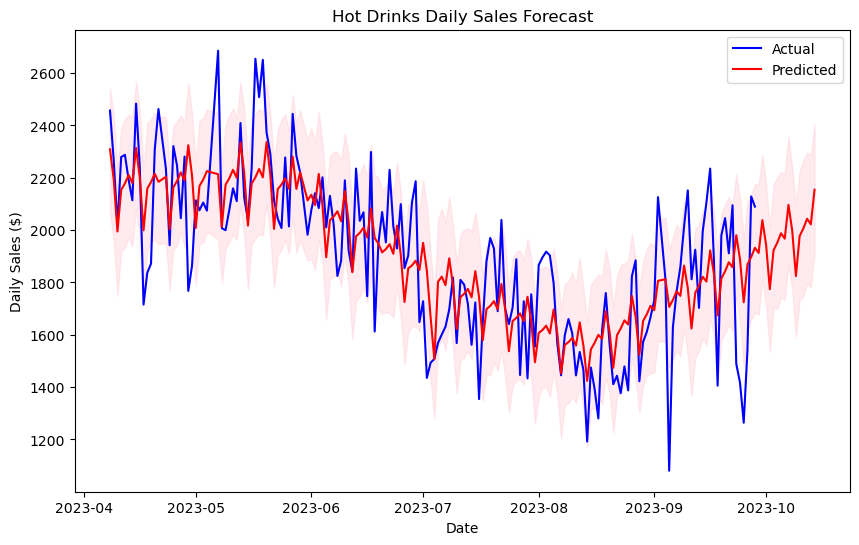

22:42:27 - cmdstanpy - INFO - Chain [1] start processing
22:42:27 - cmdstanpy - INFO - Chain [1] done processing


Pastries MAPE on test set: 15.922221216824362%


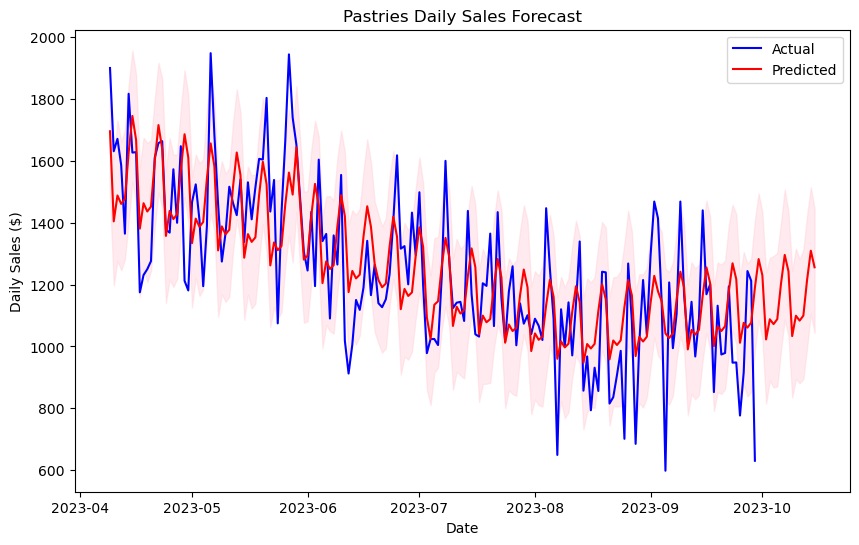

22:42:28 - cmdstanpy - INFO - Chain [1] start processing
22:42:28 - cmdstanpy - INFO - Chain [1] done processing


Breakfast Foods MAPE on test set: 22.64121989748906%


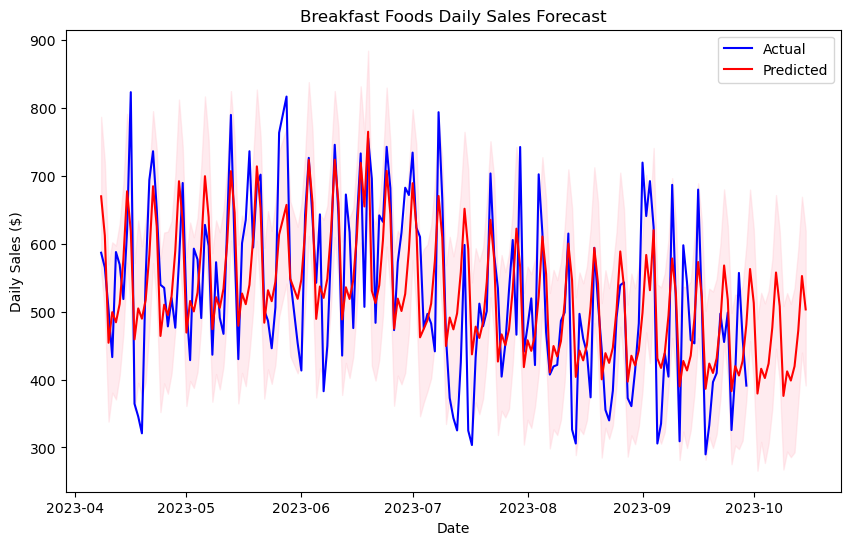

22:42:29 - cmdstanpy - INFO - Chain [1] start processing
22:42:29 - cmdstanpy - INFO - Chain [1] done processing


Cold Drinks MAPE on test set: 42.52428035064706%


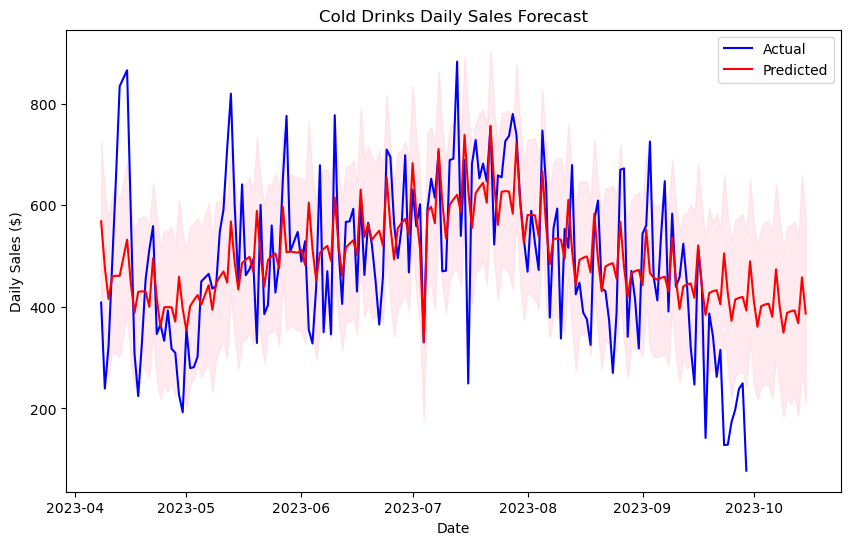

22:42:30 - cmdstanpy - INFO - Chain [1] start processing
22:42:30 - cmdstanpy - INFO - Chain [1] done processing
22:42:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:42:30 - cmdstanpy - INFO - Chain [1] start processing
22:42:30 - cmdstanpy - INFO - Chain [1] done processing


Lunch Meals MAPE on test set: 25.462859029981296%


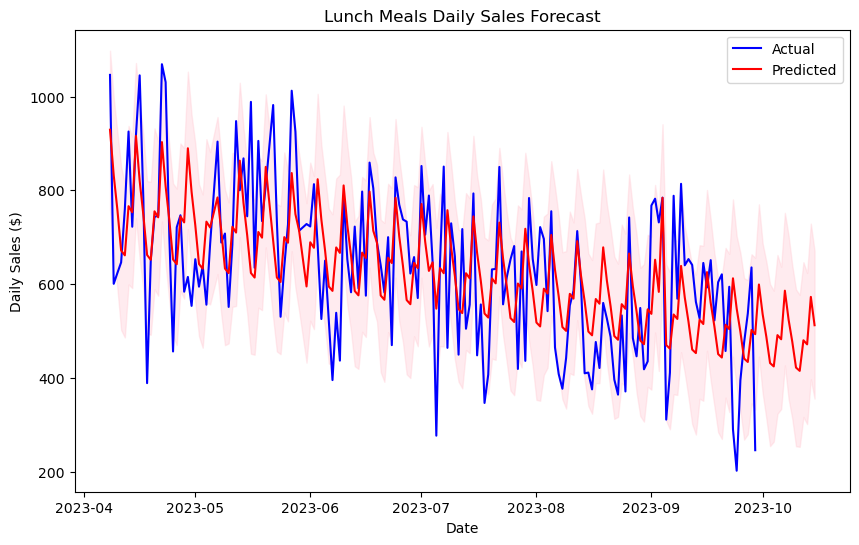

22:42:31 - cmdstanpy - INFO - Chain [1] start processing
22:42:31 - cmdstanpy - INFO - Chain [1] done processing


Other MAPE on test set: 22.098065829275455%


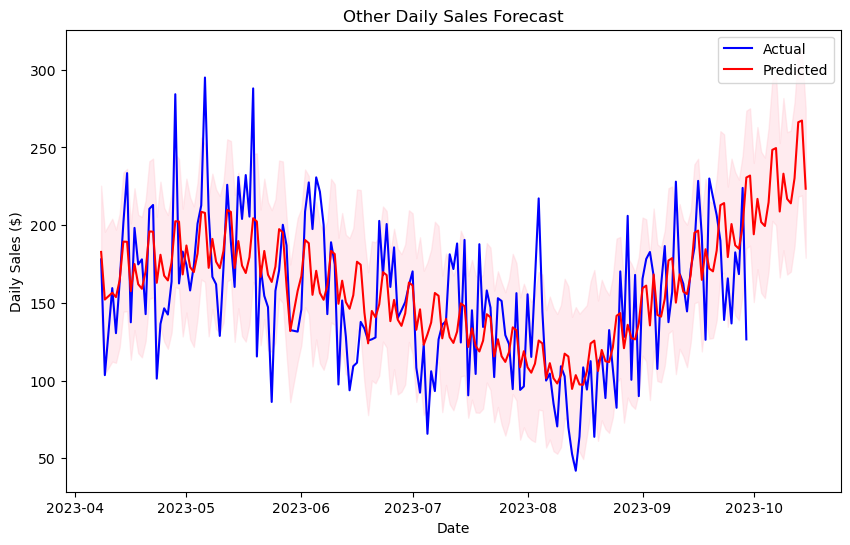

22:42:32 - cmdstanpy - INFO - Chain [1] start processing
22:42:32 - cmdstanpy - INFO - Chain [1] done processing


Snacks MAPE on test set: 47.55126446284589%


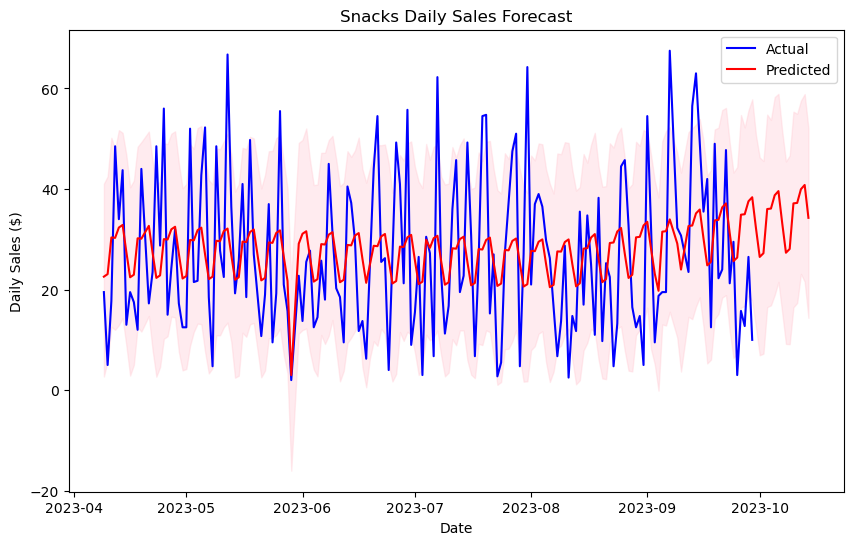

In [107]:
import matplotlib.pyplot as plt

forecasted_dfs = []
index = 0
test_size = 14

for df in prediction_df_list:
    feature = orders['product_category'].unique()[index]
    df_copy = df.reset_index().copy()
    df_copy.columns = ['ds', 'y']
    train_set = df_copy[:-test_size]
    test_set = df_copy[-test_size:]
    
    params_dict = dicts[feature]
    
    m = Prophet(changepoint_prior_scale=params_dict['changepoint_prior_scale'] * 2,
                seasonality_prior_scale=params_dict['seasonality_prior_scale'] * 10,
                seasonality_mode='multiplicative',
                weekly_seasonality=True)
    
    m.add_country_holidays(country_name='US')
    m.fit(train_set)
    
    future = m.make_future_dataframe(periods=30)
    
    forecast = m.predict(future)
    
    predictions_test = forecast[-test_size:]
    mape_value = mean_absolute_percentage_error(test_set['y'], predictions_test['yhat'])
    print(f"{feature} MAPE on test set: {mape_value}%")
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(df_copy['ds'], df_copy['y'], label='Actual', color='blue')
    plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='red')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
    
    plt.title(f"{feature} Daily Sales Forecast")
    plt.xlabel('Date')
    plt.ylabel('Daily Sales ($)')
    plt.legend()
    plt.show()
    
    index += 1

    

22:52:52 - cmdstanpy - INFO - Chain [1] start processing
22:52:52 - cmdstanpy - INFO - Chain [1] done processing
22:52:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:52:52 - cmdstanpy - INFO - Chain [1] start processing
22:52:52 - cmdstanpy - INFO - Chain [1] done processing
22:52:53 - cmdstanpy - INFO - Chain [1] start processing
22:52:53 - cmdstanpy - INFO - Chain [1] done processing
22:52:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:52:53 - cmdstanpy - INFO - Chain [1] start processing
22:52:53 - cmdstanpy - INFO - Chain [1] done processing
22:52:53 - cmdstanpy - INFO - Chain [1] start processing
22:52:54 - cmdstanpy - INFO - Chain [1] done processing
22:52:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

22:53:16 - cmdstanpy - INFO - Chain [1] start processing
22:53:16 - cmdstanpy - INFO - Chain [1] done processing
22:53:17 - cmdstanpy - INFO - Chain [1] start processing
22:53:17 - cmdstanpy - INFO - Chain [1] done processing
22:53:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:53:17 - cmdstanpy - INFO - Chain [1] start processing
22:53:17 - cmdstanpy - INFO - Chain [1] done processing
22:53:17 - cmdstanpy - INFO - Chain [1] start processing
22:53:17 - cmdstanpy - INFO - Chain [1] done processing
22:53:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:53:17 - cmdstanpy - INFO - Chain [1] start processing
22:53:18 - cmdstanpy - INFO - Chain [1] done processing
22:53:18 - cmdstanpy - INFO - Chain [1] start processing
22:53:18 - cmdstanpy - INFO - Chain [1] done processing
22:53:18 -

22:53:40 - cmdstanpy - INFO - Chain [1] start processing
22:53:40 - cmdstanpy - INFO - Chain [1] done processing
22:53:40 - cmdstanpy - INFO - Chain [1] start processing
22:53:40 - cmdstanpy - INFO - Chain [1] done processing
22:53:41 - cmdstanpy - INFO - Chain [1] start processing
22:53:41 - cmdstanpy - INFO - Chain [1] done processing
22:53:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:53:41 - cmdstanpy - INFO - Chain [1] start processing
22:53:41 - cmdstanpy - INFO - Chain [1] done processing
22:53:42 - cmdstanpy - INFO - Chain [1] start processing
22:53:42 - cmdstanpy - INFO - Chain [1] done processing
22:53:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:53:42 - cmdstanpy - INFO - Chain [1] start processing
22:53:42 - cmdstanpy - INFO - Chain [1] done processing
22:53:42 -

22:54:03 - cmdstanpy - INFO - Chain [1] start processing
22:54:04 - cmdstanpy - INFO - Chain [1] done processing
22:54:04 - cmdstanpy - INFO - Chain [1] start processing
22:54:04 - cmdstanpy - INFO - Chain [1] done processing
22:54:04 - cmdstanpy - INFO - Chain [1] start processing
22:54:04 - cmdstanpy - INFO - Chain [1] done processing
22:54:05 - cmdstanpy - INFO - Chain [1] start processing
22:54:05 - cmdstanpy - INFO - Chain [1] done processing
22:54:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:54:05 - cmdstanpy - INFO - Chain [1] start processing
22:54:05 - cmdstanpy - INFO - Chain [1] done processing
22:54:05 - cmdstanpy - INFO - Chain [1] start processing
22:54:06 - cmdstanpy - INFO - Chain [1] done processing
22:54:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:54:06 -

22:54:27 - cmdstanpy - INFO - Chain [1] start processing
22:54:27 - cmdstanpy - INFO - Chain [1] done processing
22:54:27 - cmdstanpy - INFO - Chain [1] start processing
22:54:27 - cmdstanpy - INFO - Chain [1] done processing
22:54:28 - cmdstanpy - INFO - Chain [1] start processing
22:54:28 - cmdstanpy - INFO - Chain [1] done processing
22:54:28 - cmdstanpy - INFO - Chain [1] start processing
22:54:28 - cmdstanpy - INFO - Chain [1] done processing
22:54:29 - cmdstanpy - INFO - Chain [1] start processing
22:54:29 - cmdstanpy - INFO - Chain [1] done processing
22:54:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:54:29 - cmdstanpy - INFO - Chain [1] start processing
22:54:29 - cmdstanpy - INFO - Chain [1] done processing
22:54:29 - cmdstanpy - INFO - Chain [1] start processing
22:54:29 - cmdstanpy - INFO - Chain [1] done processing
22:54:29 - cmdstanpy - ERROR - Chain [1] error: error

22:54:53 - cmdstanpy - INFO - Chain [1] start processing
22:54:53 - cmdstanpy - INFO - Chain [1] done processing
22:54:53 - cmdstanpy - INFO - Chain [1] start processing
22:54:53 - cmdstanpy - INFO - Chain [1] done processing
22:54:54 - cmdstanpy - INFO - Chain [1] start processing
22:54:54 - cmdstanpy - INFO - Chain [1] done processing
22:54:54 - cmdstanpy - INFO - Chain [1] start processing
22:54:54 - cmdstanpy - INFO - Chain [1] done processing
22:54:55 - cmdstanpy - INFO - Chain [1] start processing
22:54:55 - cmdstanpy - INFO - Chain [1] done processing
22:54:55 - cmdstanpy - INFO - Chain [1] start processing
22:54:55 - cmdstanpy - INFO - Chain [1] done processing
22:54:55 - cmdstanpy - INFO - Chain [1] start processing
22:54:55 - cmdstanpy - INFO - Chain [1] done processing
22:54:56 - cmdstanpy - INFO - Chain [1] start processing
22:54:56 - cmdstanpy - INFO - Chain [1] done processing
22:54:56 - cmdstanpy - INFO - Chain [1] start processing
22:54:56 - cmdstanpy - INFO - Chain [1]

22:55:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:55:20 - cmdstanpy - INFO - Chain [1] start processing
22:55:20 - cmdstanpy - INFO - Chain [1] done processing
22:55:21 - cmdstanpy - INFO - Chain [1] start processing
22:55:21 - cmdstanpy - INFO - Chain [1] done processing
22:55:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:55:21 - cmdstanpy - INFO - Chain [1] start processing
22:55:21 - cmdstanpy - INFO - Chain [1] done processing
22:55:21 - cmdstanpy - INFO - Chain [1] start processing
22:55:22 - cmdstanpy - INFO - Chain [1] done processing
22:55:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:55:22 - cmdstanpy - INFO - Chain [1] start processing
22:55:22 - cmdstanpy - 

Hot Drinks MAPE on test set: 15.290900910058774%


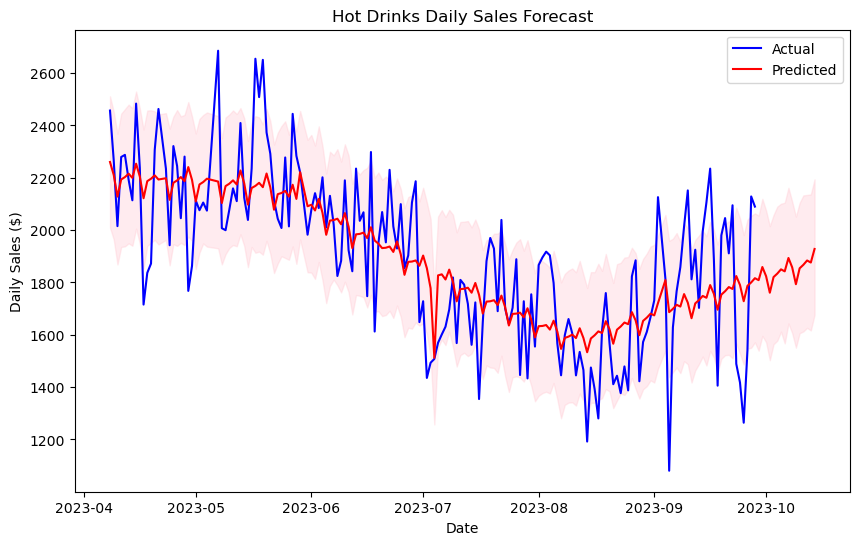

22:55:42 - cmdstanpy - INFO - Chain [1] start processing
22:55:42 - cmdstanpy - INFO - Chain [1] done processing


Pastries MAPE on test set: 16.740039317834928%


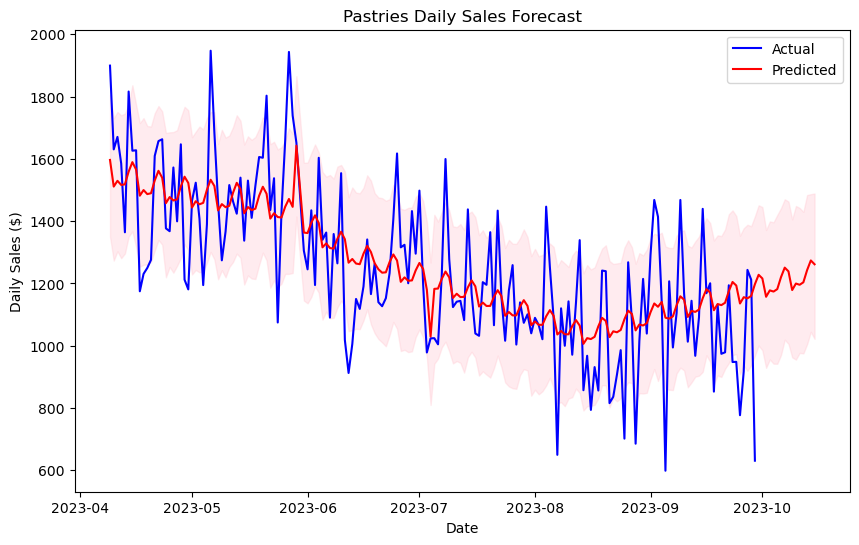

22:55:43 - cmdstanpy - INFO - Chain [1] start processing
22:55:43 - cmdstanpy - INFO - Chain [1] done processing


Breakfast Foods MAPE on test set: 23.12402033453487%


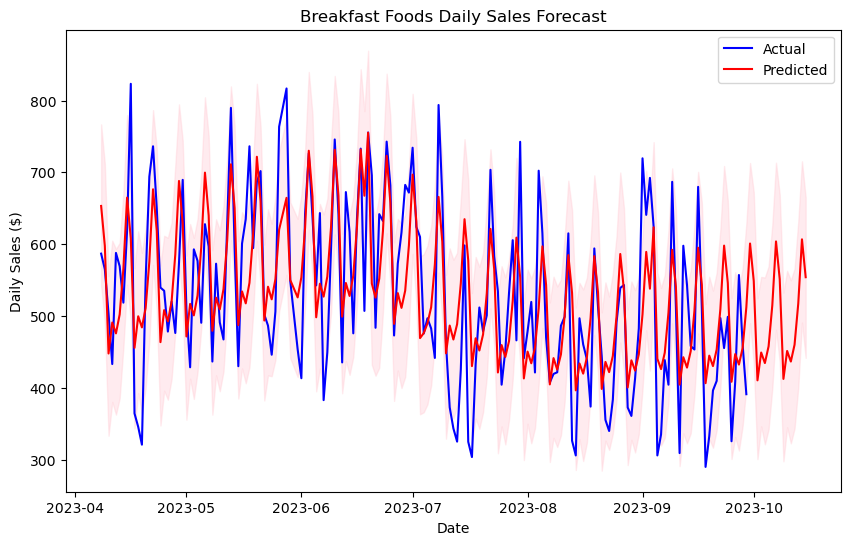

22:55:44 - cmdstanpy - INFO - Chain [1] start processing
22:55:44 - cmdstanpy - INFO - Chain [1] done processing
22:55:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:55:44 - cmdstanpy - INFO - Chain [1] start processing
22:55:44 - cmdstanpy - INFO - Chain [1] done processing


Cold Drinks MAPE on test set: 54.24618020330937%


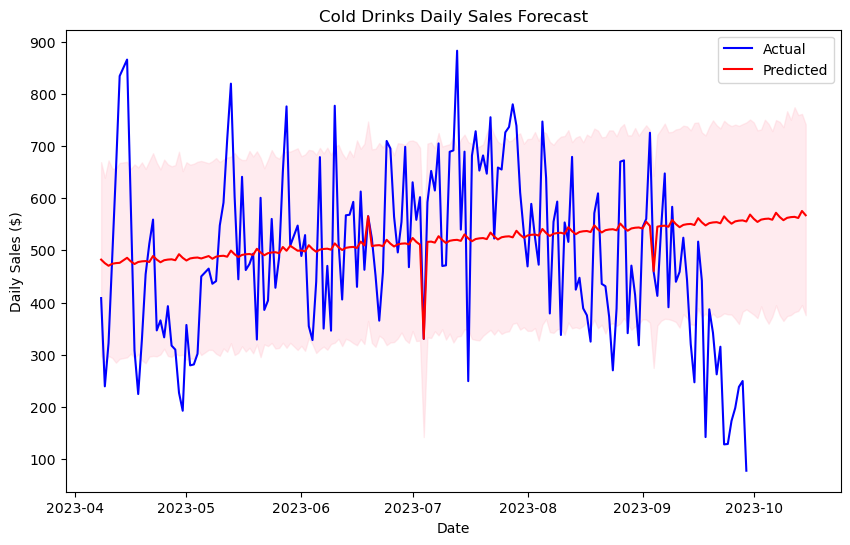

22:55:45 - cmdstanpy - INFO - Chain [1] start processing
22:55:45 - cmdstanpy - INFO - Chain [1] done processing


Lunch Meals MAPE on test set: 26.378063972485737%


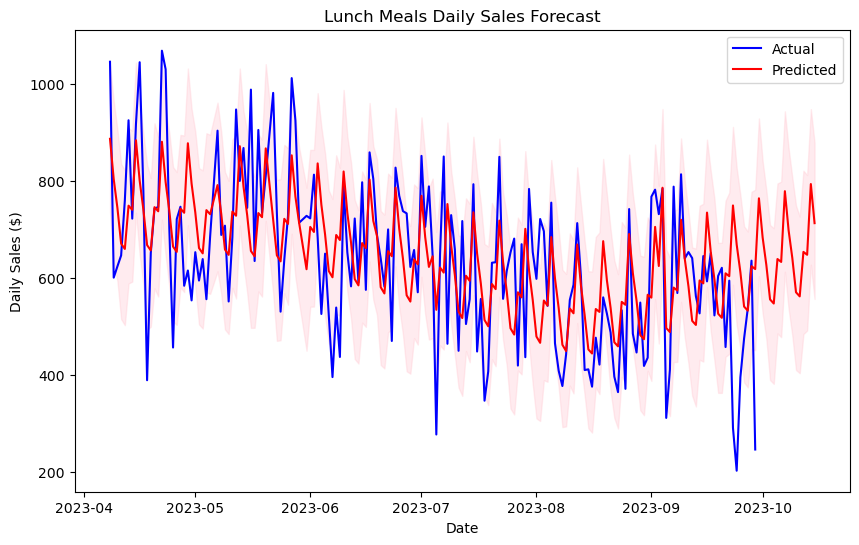

22:55:46 - cmdstanpy - INFO - Chain [1] start processing
22:55:46 - cmdstanpy - INFO - Chain [1] done processing


Other MAPE on test set: 20.687532863458006%


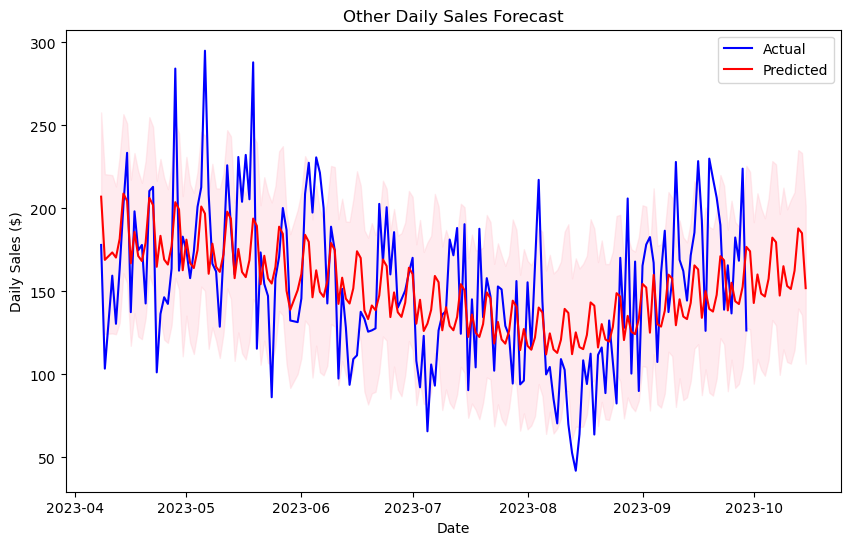

22:55:47 - cmdstanpy - INFO - Chain [1] start processing
22:55:47 - cmdstanpy - INFO - Chain [1] done processing


Snacks MAPE on test set: 42.86319416672645%


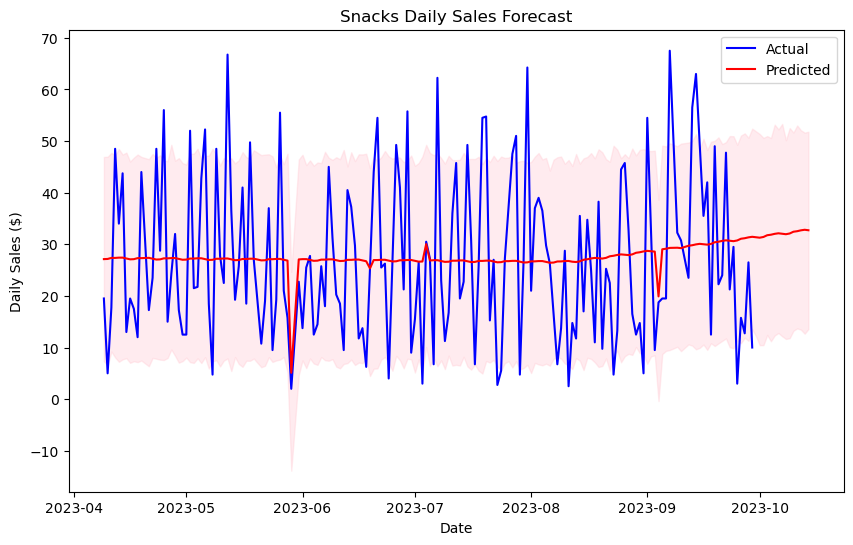

In [114]:
changepoint_prior_scale_range = np.linspace(0.001, 3.0, num=5).tolist()
seasonality_prior_scale_range = np.linspace(0.01, 3.0, num=5).tolist()
holidays_prior_scale_fixed = 5.0
seasonality_modes = ['additive', 'multiplicative']

dicts = {}
index1 = 0

for df in prediction_df_list:
    feature = orders['product_category'].unique()[index1]
    cat_df = df.reset_index()
    cat_df = cat_df.rename(mapper={'Order Date': 'ds', 'Total Price': 'y'}, axis=1)
    cat_df['y'] = cat_df[['y']].apply(pd.to_numeric)
    cat_df['ds'] = pd.to_datetime(cat_df['ds'])

    best_mape = float('inf')
    best_params = {}
    
    for changepoint_prior_scale, seasonality_prior_scale, seasonality_mode in itertools.product(
            changepoint_prior_scale_range, seasonality_prior_scale_range, seasonality_modes):
        
        m = Prophet(changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale,
                    holidays_prior_scale=holidays_prior_scale_fixed, seasonality_mode=seasonality_mode)
        m.fit(cat_df)
        
        future = m.make_future_dataframe(periods=len(df) + 14)
        forecast = m.predict(future)
        
        test_set = cat_df[-14:]
        predictions_test = forecast[-14:]
        mape_value = mean_absolute_percentage_error(test_set['y'], predictions_test['yhat'])
        
        if mape_value < best_mape:
            best_mape = mape_value
            best_params['changepoint_prior_scale'] = changepoint_prior_scale
            best_params['seasonality_prior_scale'] = seasonality_prior_scale
            best_params['seasonality_mode'] = seasonality_mode
    
    best_params['column'] = feature
    dicts[feature] = best_params
    
    index1 += 1



index = 0
test_size = 14

for df in prediction_df_list:
    feature = orders['product_category'].unique()[index]
    df_copy = df.reset_index().copy()
    df_copy.columns = ['ds', 'y']
    train_set = df_copy[:-test_size]
    test_set = df_copy[-test_size:]
    
    params_dict = dicts[feature]
    
    m = Prophet(changepoint_prior_scale=params_dict['changepoint_prior_scale'] ,
                seasonality_prior_scale=params_dict['seasonality_prior_scale'],
                holidays_prior_scale=holidays_prior_scale_fixed,
                seasonality_mode=params_dict['seasonality_mode'])
    
    m.add_country_holidays(country_name='US')
    m.fit(train_set)
    future = m.make_future_dataframe(periods=30)
    
    forecast = m.predict(future)
    
    predictions_test = forecast[-test_size:]
    mape_value = mean_absolute_percentage_error(test_set['y'], predictions_test['yhat'])
    print(f"{feature} MAPE on test set: {mape_value}%")

    plt.figure(figsize=(10, 6))
    
    plt.plot(df_copy['ds'], df_copy['y'], label='Actual', color='blue')
    
    plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='red')

    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
    
    plt.title(f"{feature} Daily Sales Forecast")
    plt.xlabel('Date')
    plt.ylabel('Daily Sales ($)')
    plt.legend()
    plt.show()
    
    index += 1


23:35:32 - cmdstanpy - INFO - Chain [1] start processing
23:35:32 - cmdstanpy - INFO - Chain [1] done processing
23:35:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:35:32 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:34 - cmdstanpy - INFO - Chain [1] start processing
23:35:34 - cmdstanpy - INFO - Chain [1] done processing
23:35:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Optimization terminated abnormally. Falling back to Newton.
23:35:43 - cmdstanpy - INFO - Chain [1] start processing
23:35:44 - cmdstanpy - INFO - Chain [1] done processing
23:35:44 - cmdstanpy - INFO - Chain [1] start processing
23:35:44 - cmdstanpy - INFO - Chain [1] done processing
23:35:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:35:44 - cmdstanpy - INFO - Chain [1] start processing
23:35:44 - cmdstanpy - INFO - Chain [1] done processing
23:35:44 - cmdstanpy - INFO - Chain [1] start processing
23:35:44 - cmdstanpy - INFO - Chain [1] done processing
23:35:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:35:44 - cmdstanpy - INFO - Chain [1] start processing
23:35:45 - cmdstanpy - INFO - Chain [1] done processing
23:35:45 - cmdstanpy - INFO - Chain [1] start processing
23:35:

23:35:56 - cmdstanpy - INFO - Chain [1] done processing
23:35:56 - cmdstanpy - INFO - Chain [1] start processing
23:35:56 - cmdstanpy - INFO - Chain [1] done processing
23:35:56 - cmdstanpy - INFO - Chain [1] start processing
23:35:56 - cmdstanpy - INFO - Chain [1] done processing
23:35:56 - cmdstanpy - INFO - Chain [1] start processing
23:35:56 - cmdstanpy - INFO - Chain [1] done processing
23:35:57 - cmdstanpy - INFO - Chain [1] start processing
23:35:57 - cmdstanpy - INFO - Chain [1] done processing
23:35:57 - cmdstanpy - INFO - Chain [1] start processing
23:35:57 - cmdstanpy - INFO - Chain [1] done processing
23:35:57 - cmdstanpy - INFO - Chain [1] start processing
23:35:57 - cmdstanpy - INFO - Chain [1] done processing
23:35:57 - cmdstanpy - INFO - Chain [1] start processing
23:35:57 - cmdstanpy - INFO - Chain [1] done processing
23:35:58 - cmdstanpy - INFO - Chain [1] start processing
23:35:58 - cmdstanpy - INFO - Chain [1] done processing
23:35:58 - cmdstanpy - INFO - Chain [1] 

23:36:17 - cmdstanpy - INFO - Chain [1] done processing
23:36:17 - cmdstanpy - INFO - Chain [1] start processing
23:36:17 - cmdstanpy - INFO - Chain [1] done processing
23:36:17 - cmdstanpy - INFO - Chain [1] start processing
23:36:18 - cmdstanpy - INFO - Chain [1] done processing
23:36:18 - cmdstanpy - INFO - Chain [1] start processing
23:36:18 - cmdstanpy - INFO - Chain [1] done processing
23:36:18 - cmdstanpy - INFO - Chain [1] start processing
23:36:18 - cmdstanpy - INFO - Chain [1] done processing
23:36:19 - cmdstanpy - INFO - Chain [1] start processing
23:36:19 - cmdstanpy - INFO - Chain [1] done processing
23:36:19 - cmdstanpy - INFO - Chain [1] start processing
23:36:19 - cmdstanpy - INFO - Chain [1] done processing
23:36:20 - cmdstanpy - INFO - Chain [1] start processing
23:36:20 - cmdstanpy - INFO - Chain [1] done processing
23:36:20 - cmdstanpy - INFO - Chain [1] start processing
23:36:20 - cmdstanpy - INFO - Chain [1] done processing
23:36:21 - cmdstanpy - INFO - Chain [1] 

23:36:40 - cmdstanpy - INFO - Chain [1] done processing
23:36:40 - cmdstanpy - INFO - Chain [1] start processing
23:36:40 - cmdstanpy - INFO - Chain [1] done processing
23:36:40 - cmdstanpy - INFO - Chain [1] start processing
23:36:40 - cmdstanpy - INFO - Chain [1] done processing
23:36:41 - cmdstanpy - INFO - Chain [1] start processing
23:36:41 - cmdstanpy - INFO - Chain [1] done processing
23:36:41 - cmdstanpy - INFO - Chain [1] start processing
23:36:41 - cmdstanpy - INFO - Chain [1] done processing
23:36:41 - cmdstanpy - INFO - Chain [1] start processing
23:36:41 - cmdstanpy - INFO - Chain [1] done processing
23:36:42 - cmdstanpy - INFO - Chain [1] start processing
23:36:42 - cmdstanpy - INFO - Chain [1] done processing
23:36:42 - cmdstanpy - INFO - Chain [1] start processing
23:36:42 - cmdstanpy - INFO - Chain [1] done processing
23:36:42 - cmdstanpy - INFO - Chain [1] start processing
23:36:42 - cmdstanpy - INFO - Chain [1] done processing
23:36:42 - cmdstanpy - INFO - Chain [1] 

23:37:01 - cmdstanpy - INFO - Chain [1] done processing
23:37:01 - cmdstanpy - INFO - Chain [1] start processing
23:37:01 - cmdstanpy - INFO - Chain [1] done processing
23:37:02 - cmdstanpy - INFO - Chain [1] start processing
23:37:02 - cmdstanpy - INFO - Chain [1] done processing
23:37:02 - cmdstanpy - INFO - Chain [1] start processing
23:37:02 - cmdstanpy - INFO - Chain [1] done processing
23:37:02 - cmdstanpy - INFO - Chain [1] start processing
23:37:02 - cmdstanpy - INFO - Chain [1] done processing
23:37:02 - cmdstanpy - INFO - Chain [1] start processing
23:37:02 - cmdstanpy - INFO - Chain [1] done processing
23:37:03 - cmdstanpy - INFO - Chain [1] start processing
23:37:03 - cmdstanpy - INFO - Chain [1] done processing
23:37:03 - cmdstanpy - INFO - Chain [1] start processing
23:37:03 - cmdstanpy - INFO - Chain [1] done processing
23:37:03 - cmdstanpy - INFO - Chain [1] start processing
23:37:03 - cmdstanpy - INFO - Chain [1] done processing
23:37:03 - cmdstanpy - INFO - Chain [1] 

23:37:23 - cmdstanpy - INFO - Chain [1] done processing
23:37:23 - cmdstanpy - INFO - Chain [1] start processing
23:37:23 - cmdstanpy - INFO - Chain [1] done processing
23:37:23 - cmdstanpy - INFO - Chain [1] start processing
23:37:23 - cmdstanpy - INFO - Chain [1] done processing
23:37:23 - cmdstanpy - INFO - Chain [1] start processing
23:37:24 - cmdstanpy - INFO - Chain [1] done processing
23:37:24 - cmdstanpy - INFO - Chain [1] start processing
23:37:24 - cmdstanpy - INFO - Chain [1] done processing
23:37:24 - cmdstanpy - INFO - Chain [1] start processing
23:37:24 - cmdstanpy - INFO - Chain [1] done processing
23:37:24 - cmdstanpy - INFO - Chain [1] start processing
23:37:24 - cmdstanpy - INFO - Chain [1] done processing
23:37:25 - cmdstanpy - INFO - Chain [1] start processing
23:37:25 - cmdstanpy - INFO - Chain [1] done processing
23:37:25 - cmdstanpy - INFO - Chain [1] start processing
23:37:25 - cmdstanpy - INFO - Chain [1] done processing
23:37:25 - cmdstanpy - INFO - Chain [1] 

23:37:43 - cmdstanpy - INFO - Chain [1] done processing
23:37:43 - cmdstanpy - INFO - Chain [1] start processing
23:37:43 - cmdstanpy - INFO - Chain [1] done processing
23:37:44 - cmdstanpy - INFO - Chain [1] start processing
23:37:44 - cmdstanpy - INFO - Chain [1] done processing
23:37:44 - cmdstanpy - INFO - Chain [1] start processing
23:37:44 - cmdstanpy - INFO - Chain [1] done processing
23:37:44 - cmdstanpy - INFO - Chain [1] start processing
23:37:44 - cmdstanpy - INFO - Chain [1] done processing
23:37:44 - cmdstanpy - INFO - Chain [1] start processing
23:37:44 - cmdstanpy - INFO - Chain [1] done processing
23:37:45 - cmdstanpy - INFO - Chain [1] start processing
23:37:45 - cmdstanpy - INFO - Chain [1] done processing
23:37:45 - cmdstanpy - INFO - Chain [1] start processing
23:37:45 - cmdstanpy - INFO - Chain [1] done processing
23:37:45 - cmdstanpy - INFO - Chain [1] start processing
23:37:45 - cmdstanpy - INFO - Chain [1] done processing
23:37:45 - cmdstanpy - INFO - Chain [1] 

23:38:03 - cmdstanpy - INFO - Chain [1] done processing
23:38:03 - cmdstanpy - INFO - Chain [1] start processing
23:38:03 - cmdstanpy - INFO - Chain [1] done processing
23:38:03 - cmdstanpy - INFO - Chain [1] start processing
23:38:03 - cmdstanpy - INFO - Chain [1] done processing
23:38:03 - cmdstanpy - INFO - Chain [1] start processing
23:38:03 - cmdstanpy - INFO - Chain [1] done processing
23:38:04 - cmdstanpy - INFO - Chain [1] start processing
23:38:04 - cmdstanpy - INFO - Chain [1] done processing
23:38:04 - cmdstanpy - INFO - Chain [1] start processing
23:38:04 - cmdstanpy - INFO - Chain [1] done processing
23:38:04 - cmdstanpy - INFO - Chain [1] start processing
23:38:04 - cmdstanpy - INFO - Chain [1] done processing
23:38:04 - cmdstanpy - INFO - Chain [1] start processing
23:38:05 - cmdstanpy - INFO - Chain [1] done processing
23:38:05 - cmdstanpy - INFO - Chain [1] start processing
23:38:05 - cmdstanpy - INFO - Chain [1] done processing
23:38:05 - cmdstanpy - INFO - Chain [1] 

23:38:24 - cmdstanpy - INFO - Chain [1] done processing
23:38:24 - cmdstanpy - INFO - Chain [1] start processing
23:38:24 - cmdstanpy - INFO - Chain [1] done processing
23:38:24 - cmdstanpy - INFO - Chain [1] start processing
23:38:24 - cmdstanpy - INFO - Chain [1] done processing
23:38:25 - cmdstanpy - INFO - Chain [1] start processing
23:38:25 - cmdstanpy - INFO - Chain [1] done processing
23:38:25 - cmdstanpy - INFO - Chain [1] start processing
23:38:25 - cmdstanpy - INFO - Chain [1] done processing
23:38:26 - cmdstanpy - INFO - Chain [1] start processing
23:38:26 - cmdstanpy - INFO - Chain [1] done processing
23:38:26 - cmdstanpy - INFO - Chain [1] start processing
23:38:26 - cmdstanpy - INFO - Chain [1] done processing
23:38:26 - cmdstanpy - INFO - Chain [1] start processing
23:38:26 - cmdstanpy - INFO - Chain [1] done processing
23:38:27 - cmdstanpy - INFO - Chain [1] start processing
23:38:27 - cmdstanpy - INFO - Chain [1] done processing
23:38:27 - cmdstanpy - INFO - Chain [1] 

23:38:46 - cmdstanpy - INFO - Chain [1] done processing
23:38:47 - cmdstanpy - INFO - Chain [1] start processing
23:38:47 - cmdstanpy - INFO - Chain [1] done processing
23:38:47 - cmdstanpy - INFO - Chain [1] start processing
23:38:47 - cmdstanpy - INFO - Chain [1] done processing
23:38:47 - cmdstanpy - INFO - Chain [1] start processing
23:38:47 - cmdstanpy - INFO - Chain [1] done processing
23:38:47 - cmdstanpy - INFO - Chain [1] start processing
23:38:48 - cmdstanpy - INFO - Chain [1] done processing
23:38:48 - cmdstanpy - INFO - Chain [1] start processing
23:38:48 - cmdstanpy - INFO - Chain [1] done processing
23:38:48 - cmdstanpy - INFO - Chain [1] start processing
23:38:48 - cmdstanpy - INFO - Chain [1] done processing
23:38:48 - cmdstanpy - INFO - Chain [1] start processing
23:38:48 - cmdstanpy - INFO - Chain [1] done processing
23:38:49 - cmdstanpy - INFO - Chain [1] start processing
23:38:49 - cmdstanpy - INFO - Chain [1] done processing
23:38:49 - cmdstanpy - INFO - Chain [1] 

23:39:08 - cmdstanpy - INFO - Chain [1] done processing
23:39:08 - cmdstanpy - INFO - Chain [1] start processing
23:39:08 - cmdstanpy - INFO - Chain [1] done processing
23:39:09 - cmdstanpy - INFO - Chain [1] start processing
23:39:09 - cmdstanpy - INFO - Chain [1] done processing
23:39:09 - cmdstanpy - INFO - Chain [1] start processing
23:39:09 - cmdstanpy - INFO - Chain [1] done processing
23:39:09 - cmdstanpy - INFO - Chain [1] start processing
23:39:09 - cmdstanpy - INFO - Chain [1] done processing
23:39:10 - cmdstanpy - INFO - Chain [1] start processing
23:39:10 - cmdstanpy - INFO - Chain [1] done processing
23:39:10 - cmdstanpy - INFO - Chain [1] start processing
23:39:10 - cmdstanpy - INFO - Chain [1] done processing
23:39:10 - cmdstanpy - INFO - Chain [1] start processing
23:39:10 - cmdstanpy - INFO - Chain [1] done processing
23:39:11 - cmdstanpy - INFO - Chain [1] start processing
23:39:11 - cmdstanpy - INFO - Chain [1] done processing
23:39:11 - cmdstanpy - INFO - Chain [1] 

23:39:39 - cmdstanpy - INFO - Chain [1] done processing
23:39:39 - cmdstanpy - INFO - Chain [1] start processing
23:39:39 - cmdstanpy - INFO - Chain [1] done processing
23:39:39 - cmdstanpy - INFO - Chain [1] start processing
23:39:39 - cmdstanpy - INFO - Chain [1] done processing
23:39:40 - cmdstanpy - INFO - Chain [1] start processing
23:39:40 - cmdstanpy - INFO - Chain [1] done processing
23:39:40 - cmdstanpy - INFO - Chain [1] start processing
23:39:40 - cmdstanpy - INFO - Chain [1] done processing
23:39:40 - cmdstanpy - INFO - Chain [1] start processing
23:39:40 - cmdstanpy - INFO - Chain [1] done processing
23:39:41 - cmdstanpy - INFO - Chain [1] start processing
23:39:41 - cmdstanpy - INFO - Chain [1] done processing
23:39:41 - cmdstanpy - INFO - Chain [1] start processing
23:39:41 - cmdstanpy - INFO - Chain [1] done processing
23:39:41 - cmdstanpy - INFO - Chain [1] start processing
23:39:41 - cmdstanpy - INFO - Chain [1] done processing
23:39:42 - cmdstanpy - INFO - Chain [1] 

Daily Revenue MAPE on test set: 26.42950701388293%


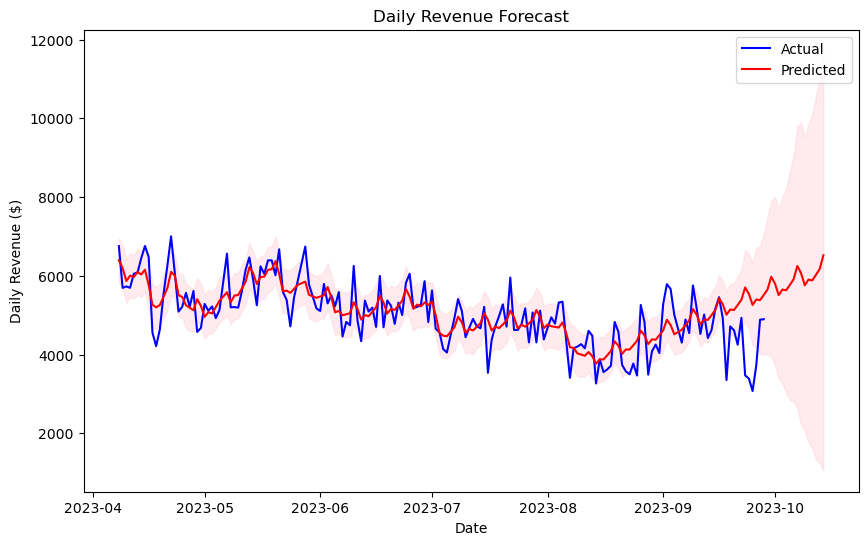

In [123]:

daily_sales = orders.groupby(orders['order time (utc)'].dt.date).agg({'Total Price': 'sum'}).reset_index()
daily_sales.set_index('order time (utc)', inplace=True)

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

daily_sales_cleaned = remove_outliers_iqr(daily_sales, 'Total Price')


changepoint_prior_scale_range = np.linspace(0.001, 6.0, num=20).tolist()
seasonality_prior_scale_range = np.linspace(0.01, 6.0, num=20).tolist()

holidays_prior_scale_fixed = 5.0
seasonality_modes = ['additive', 'multiplicative']

dicts = {}
index1 = 0

for df in [daily_sales_cleaned]:
    feature = 'Daily Revenue'
    cat_df = df.reset_index()
    cat_df.columns = ['ds', 'y']
    
    best_mape = float('inf')
    best_params = {}
    
    for changepoint_prior_scale, seasonality_prior_scale, seasonality_mode in itertools.product(
            changepoint_prior_scale_range, seasonality_prior_scale_range, seasonality_modes):
        
        m = Prophet(changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale,
                    holidays_prior_scale=holidays_prior_scale_fixed, seasonality_mode=seasonality_mode)
        m.add_country_holidays(country_name='US')
        m.fit(cat_df)
        
        future = m.make_future_dataframe(periods=len(cat_df) + 14)
        forecast = m.predict(future)
        
        test_set = cat_df[-14:]
        predictions_test = forecast[-14:]
        mape_value = mean_absolute_percentage_error(test_set['y'], predictions_test['yhat'])
        
        if mape_value < best_mape:
            best_mape = mape_value
            best_params['changepoint_prior_scale'] = changepoint_prior_scale
            best_params['seasonality_prior_scale'] = seasonality_prior_scale
            best_params['seasonality_mode'] = seasonality_mode
    
    best_params['column'] = feature
    dicts[feature] = best_params
    
    index1 += 1

index = 0
test_size = 14

for df in [daily_sales_cleaned]:
    feature = 'Daily Revenue'
    df_copy = df.reset_index().copy()
    df_copy.columns = ['ds', 'y']
    train_set = df_copy[:-test_size]
    test_set = df_copy[-test_size:]
    
    params_dict = dicts[feature]
    
    m = Prophet(changepoint_prior_scale=params_dict['changepoint_prior_scale'] ,
                seasonality_prior_scale=params_dict['seasonality_prior_scale'],
                holidays_prior_scale=holidays_prior_scale_fixed,
                seasonality_mode=params_dict['seasonality_mode'])
    
    m.fit(train_set)
    
    future = m.make_future_dataframe(periods=30)
    
    forecast = m.predict(future)
    

    predictions_test = forecast[-test_size:]
    mape_value = mean_absolute_percentage_error(test_set['y'], predictions_test['yhat'])
    print(f"{feature} MAPE on test set: {mape_value}%")
 
    plt.figure(figsize=(10, 6))
    
    plt.plot(df_copy['ds'], df_copy['y'], label='Actual', color='blue')
    

    plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='red')
   
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
    
    plt.title(f"{feature} Forecast")
    plt.xlabel('Date')
    plt.ylabel('Daily Revenue ($)')
    plt.legend()
    plt.show()
    
    index += 1